In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from scipy.stats import pearsonr
from pingouin import partial_corr
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection, multipletests
from datetime import datetime, timedelta
from tqdm import tqdm

METABO_DIR_ROOT = '/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/Analyses/davidkro/batch_normalizations'
DIET_PAPER_DIR = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper'
tomer_dir = '/net/mraid20/export/genie/LabData/Analyses/tomerse/david_colab/'
DVIDKRO_DIR = '/net/mraid20/export/genie/LabData/Analyses/davidkro/'
output_data_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/'
FIGS_DIR = os.path.join(DIET_PAPER_DIR, 'Figs_paper')
from LabData.DataLoaders import BodyMeasuresLoader, GutMBLoader, LifeStyleLoader, BloodTestsLoader

In [69]:
bml = BodyMeasuresLoader.BodyMeasuresLoader()
bm = bml.get_data()
lfs = LifeStyleLoader.LifeStyleLoader()
lifestyle = lfs.get_data()
blood_loader = BloodTestsLoader.BloodTestsLoader()

In [70]:
blood_data = blood_loader.get_data()

In [71]:
blood_data_df = blood_data.df.join(blood_data.df_metadata[['research_stage']], how='inner')

In [72]:
blood_data_df_baseline = blood_data_df[blood_data_df['research_stage'] == 'baseline'].drop(columns=['research_stage'])

In [73]:
blood_data_df_baseline = blood_data_df_baseline.groupby('RegistrationCode').last()

In [74]:
# drop rows with high percentage of nans
blood_data_df_baseline_filtered = blood_data_df_baseline.loc[:, blood_data_df_baseline.isnull().sum()/len(blood_data_df_baseline) < 0.9].copy()

<Axes: ylabel='Count'>

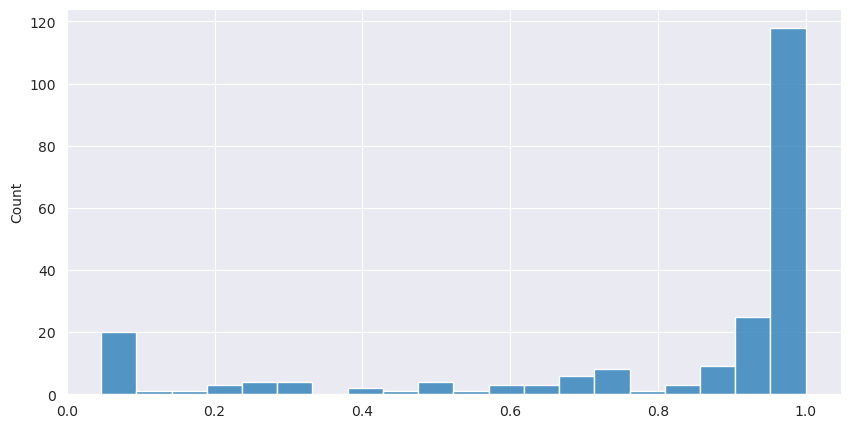

In [75]:
blood_data_df_baseline.isnull().sum()/len(blood_data_df_baseline)
# plot the distribution of missing values
plt.figure(figsize=(10, 5))
sns.histplot(blood_data_df_baseline.isnull().sum()/len(blood_data_df_baseline), bins=20)

In [76]:
lifestyle_data = lifestyle.df.join(lifestyle.df_metadata[['research_stage']], how='inner')

In [77]:
lifestyle_data_baseline = lifestyle_data[lifestyle_data['research_stage'] == 'baseline'].drop(columns=['research_stage'])

In [78]:
# lifestyle_data_baseline.head(20).to_excel('/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/lifestyle_data_baseline_head.xlsx')

In [79]:
lifestyle_data_baseline.shape

(11411, 261)

In [80]:
(lifestyle_data_baseline.isnull().sum()/len(lifestyle_data_baseline) < 0.93).value_counts()

True     237
False     24
Name: count, dtype: int64

In [81]:
lifestyle_data_baseline.isnull().sum()/len(lifestyle_data_baseline)

accommodation_type                             0.083165
accommodation_years                            0.084743
add_salt_to_food                               0.573306
age_last_smoking_regularly1                    0.997108
age_last_smoking_regularly_age                 0.886425
                                                 ...   
transportaion_to_work__Walk                    0.000526
transportaion_to_work__Walking                 0.000526
transportaion_to_work__no                      0.000526
transportaion_to_work__prefer not to answer    0.000526
transportaion_to_work__אף אחד מהנ"ל            0.000526
Length: 261, dtype: float64

In [82]:
# filter columns with less than 10% missing values
lifestyle_data_baseline_filtered = lifestyle_data_baseline.loc[:, lifestyle_data_baseline.isnull().sum()/len(lifestyle_data_baseline) < 0.93].copy()

In [83]:
lifestyle_data_baseline_filtered.reset_index(inplace=True)
lifestyle_data_baseline_filtered.set_index('RegistrationCode', inplace=True)
lifestyle_data_baseline_filtered.drop(columns=['Date'], inplace=True)

In [84]:
gut_loader = GutMBLoader.GutMBLoader()
gut_mb = gut_loader.get_data(df='mpa_species', study_ids=[10], groupby_reg='first')

/home/davidkro/PycharmProjects/LabData/LabData/DataLoaders/Loader.py:215: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata = metadata[~metadata[self.metadata_filter_column].fillna(False)]
/home/davidkro/PycharmProjects/LabData/LabData/DataLoaders/Loader.py:215: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata = metadata[~metadata[self.metadata_filter_column].fillna(False)]


In [85]:
gut_mpa = gut_mb.df.join(gut_mb.df_metadata[['research_stage', 'RegistrationCode']], how='inner')

In [86]:
gut_mpa_baseline = gut_mpa[gut_mpa['research_stage'] == 'baseline'].drop(columns=['research_stage'])

In [87]:
gut_mpa_baseline.set_index('RegistrationCode', inplace=True)

In [88]:
bm_df = bm.df
bm_meta = bm.df_metadata

In [89]:
baseline_fatures = bm_df[['bmi']].join(bm_meta[['age', 'gender', 'research_stage']], how='inner')
baseline_height = bm_df[['height']].join(bm_meta[['research_stage']], how='inner')

In [90]:
agb_baseline = baseline_fatures[baseline_fatures['research_stage'] == 'baseline'].drop(columns=['research_stage'])
height_baseline = baseline_height[baseline_height['research_stage'] == 'baseline'].drop(columns=['research_stage'])

In [91]:
# agb_baseline.to_csv('/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/Xs/agb_baseline.csv')

In [92]:
agb_baseline.reset_index(inplace=True)
height_baseline.reset_index(inplace=True)

In [93]:
agb_baseline.set_index('RegistrationCode', inplace=True)
agb_baseline.drop(columns=['Date'], inplace=True)
height_baseline.set_index('RegistrationCode', inplace=True)
height_baseline.drop(columns=['Date'], inplace=True)

In [94]:
batches = 36
serrf_ms_data = pd.read_csv(f'/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations/SERRF/SERRF Result{batches}_no1/normalized by - SERRF.csv', index_col=0)
# classic_ms_data = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations/inter_batch_normalized/normalized_compounds_batches_1_29_.csv', index_col=0)
ms_metadata = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations/metadata_with_date.csv', index_col=0)
fuzzy_join_ms = pd.read_csv(os.path.join(METABO_DIR_ROOT, 'fuzzy_joined', f'fuzzy_join_batches4_final_super_batches{batches}_no1.csv'), index_col=0)

In [95]:
nightingale_data = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/Ys/nightingale.csv', index_col=0)
nightingale_data.drop(columns=['Esterified_C', 'Free_C', 'Glycerol', 'HDL2_C', 'HDL3_C'], inplace=True)
nightingale_data = nightingale_data.join(agb_baseline)
# rename column 'Glucose' to 'Glucose_NMR'
nightingale_data.rename(columns={'Glucose': 'Glucose_NMR'}, inplace=True)

In [96]:
cluster_data09 = pd.read_csv(f'/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations/clustered/clustered_{batches}_thr09_no1.csv', index_col=0)
cluster_data08 = pd.read_csv(f'/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations/clustered/clustered_{batches}_thr08_no1.csv', index_col=0)
cluster_data07 = pd.read_csv(f'/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations/clustered/clustered_{batches}_thr07_no1.csv', index_col=0) 

In [97]:
# ms_for_hpp = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations/inter_batch_normalized/normalized_compounds_batches_1_6_log.csv', index_col=0)

In [98]:
def process_ms_ccs_data(serrf_ms_data, fuzzy_join_ms, ms_metadata, metadata_join_method='inner'):
    """
    Process MS data by joining with CCS values and metadata, including transposition of the data.
    
    Parameters:
    -----------
    serrf_ms_data : pandas.DataFrame
        The main MS data DataFrame
    fuzzy_join_ms : pandas.DataFrame
        DataFrame containing the CCS values to join
    ms_metadata : pandas.DataFrame
        DataFrame containing metadata with columns: 'name_dna', 'RegistrationCode',
        'research_stage', 'age', 'gender', 'bmi'
        
    Returns:
    --------
    pandas.DataFrame
        Processed DataFrame with metadata and updated indices including CCS values
    """
    # Join the CCS values
    processed_data = serrf_ms_data.join(fuzzy_join_ms['CCS (angstrom^2)'], how='inner')

    # Round CCS values to 2 decimal places
    processed_data['CCS (angstrom^2)'] = processed_data['CCS (angstrom^2)'].round(2)

    # Update index by concatenating with CCS values
    processed_data.index = processed_data.index + "_" + processed_data['CCS (angstrom^2)'].astype(str)

    # Remove the CCS column
    processed_data.drop(columns=['CCS (angstrom^2)'], inplace=True)

    # Transpose the data
    processed_data_transposed = processed_data.T
    
    # Set the index for metadata
    ms_metadata = ms_metadata.copy()  # Create a copy to avoid modifying the original
    ms_metadata.set_index('name_dna', inplace=True)
    
    # Join with metadata
    final_data = processed_data_transposed.join(
        ms_metadata[['RegistrationCode', 'research_stage', 'age', 'gender', 'bmi']], 
        how=metadata_join_method
    )
    return final_data

In [99]:
fuzzy_join_ms_latest = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations/fuzzy_joined/fuzzy_join_batches4_final_super_batches36_no1.csv', index_col=0)

In [100]:
try_ms = fuzzy_join_ms_latest.T.merge(ms_metadata, left_index=True, right_on='name_dna', how='inner')
try_ms.set_index('RegistrationCode', inplace=True)
try_ms_base = try_ms[try_ms['research_stage'] == 'baseline'].drop(columns=['research_stage'])

In [101]:
serf_full = process_ms_ccs_data(serrf_ms_data, fuzzy_join_ms, ms_metadata)
clusterd_09 = process_ms_ccs_data(cluster_data09.T, fuzzy_join_ms, ms_metadata)
clusterd_08 = process_ms_ccs_data(cluster_data08.T, fuzzy_join_ms, ms_metadata)
clusterd_07 = process_ms_ccs_data(cluster_data07.T, fuzzy_join_ms, ms_metadata)
# ms_classic = process_ms_ccs_data(classic_ms_data, fuzzy_join_ms, ms_metadata)
# hpp_ms = process_ms_ccs_data(ms_for_hpp, fuzzy_join_ms, ms_metadata)
serrf_all = process_ms_ccs_data(serrf_ms_data, fuzzy_join_ms, ms_metadata, metadata_join_method='left')
clustered_09_all = process_ms_ccs_data(cluster_data09.T, fuzzy_join_ms, ms_metadata, metadata_join_method='left')    

In [102]:
serrf_all.shape

(14413, 2252)

In [103]:
# keep rows with LV in index
serrf_all = serrf_all[serrf_all.index.str.contains('LV')]
clusterd_09_all = clusterd_09[clusterd_09.index.str.contains('LV')]

In [104]:
serrf_all.shape

(11023, 2252)

In [105]:
serf_full = serf_full.drop_duplicates(subset=['RegistrationCode', 'research_stage'], keep='first')
clusterd_09 = clusterd_09.drop_duplicates(subset=['RegistrationCode', 'research_stage'], keep='first')
# serrf_all = serrf_all.drop_duplicates(subset=['RegistrationCode', 'research_stage'], keep='first')
# clusterd_09_all = clustered_09_all.drop_duplicates(subset=['RegistrationCode', 'research_stage'], keep='first')

In [106]:
serrf_all.to_csv(DIET_PAPER_DIR + '/serrf_all.csv') 
clusterd_09_all.to_csv(DIET_PAPER_DIR + '/clusterd_09_all.csv')

In [107]:
df = ms_metadata.copy()
# Find all duplicate rows based on the two columns
duplicates = df[df.duplicated(subset=['RegistrationCode', 'research_stage'], keep=False)]

# Sort by those columns to see duplicates grouped together
duplicates = duplicates.sort_values(['RegistrationCode', 'research_stage'])

# To see the count of duplicates for each combination
duplicate_counts = df.groupby(['RegistrationCode', 'research_stage']).size().reset_index(name='count')
duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1]

In [108]:
serf_full['research_stage'].value_counts()

research_stage
baseline       5900
02_00_visit    3352
04_00_visit     688
03_01_visit      59
01_01_visit      57
Name: count, dtype: int64

In [109]:
# create a column combining the RegistrationCode and research_stage
# hpp_ms['RegistrationCode_research_stage'] = hpp_ms['RegistrationCode'] + '_' + hpp_ms['research_stage']

In [110]:
# hpp_ms.set_index('RegistrationCode_research_stage', inplace=True)

In [111]:
# hpp_ms_metabo = hpp_ms.drop(columns=['RegistrationCode', 'research_stage', 'age', 'gender', 'bmi'])

In [112]:
# standardize the data
# scaler = StandardScaler()
# hpp_ms_metabo_scaled = pd.DataFrame(scaler.fit_transform(hpp_ms_metabo), index=hpp_ms_metabo.index, columns=hpp_ms_metabo.columns)

In [113]:
# # corr_matrix = hpp_ms_metabo.T.corr()
# corr_matrix = hpp_ms_metabo_scaled.T.corr()

In [114]:
# corr_matrix.to_csv('/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/hpp_ms_metabo_corr_scaled.csv')

In [115]:
# fuzzy_test = process_ms_ccs_data(fuzzy_join_ms_latest, fuzzy_join_ms_latest, ms_metadata)

In [116]:
serrf_full_base = serf_full[serf_full['research_stage'] == 'baseline'].drop(columns=['research_stage']).set_index('RegistrationCode')

In [117]:
clusterd_09_base = clusterd_09[clusterd_09['research_stage'] == 'baseline'].drop(columns=['research_stage']).set_index('RegistrationCode')
clusterd_08_base = clusterd_08[clusterd_08['research_stage'] == 'baseline'].drop(columns=['research_stage']).set_index('RegistrationCode')
clusterd_07_base = clusterd_07[clusterd_07['research_stage'] == 'baseline'].drop(columns=['research_stage']).set_index('RegistrationCode')

In [208]:
### import diet data
diet_mb = pd.read_pickle(tomer_dir + 'diet_mb.pkl').drop(columns=['age', 'gender'])
diet_mb_mpa = pd.read_pickle(tomer_dir + 'diet_mb_mpa.pkl').drop(columns=['age', 'gender'])
diet_features = pd.read_pickle(tomer_dir + 'diet_features_v2.pkl').drop(columns=['age'])
diet_features_v2 = pd.read_pickle(tomer_dir + 'diet_features_02_visit_v2.pkl').drop(columns=['age'])
diet_features_with_disease = pd.read_pickle(tomer_dir + 'diet_features_v4.pkl').drop(columns=['age'])
diet_features_pre = pd.read_pickle(tomer_dir + 'diet_features_pre_visit.pkl').drop(columns=['age'])
# diet_features_version2 = pd.read_pickle(tomer_dir + 'diet_features_v2.pkl').drop(columns=['age', 'gender'])
my_lists_diet = pd.read_pickle(tomer_dir + 'my_lists_diet_v2.pkl')

In [119]:
ms_diet_baseline = serrf_full_base.join(diet_features, how='inner')

In [120]:
ms_diet_baseline.shape

(5163, 2950)

### Validate the scores with Lifestyle

In [836]:
diet_feature_lifestyle = diet_features.join(lifestyle_data_baseline_filtered, how='inner')

In [837]:
diet_feature_lifestyle.shape

(8855, 956)

In [838]:
diet_features.shape

(10769, 719)

In [844]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_vegan_adherence_comparison(df, adherence_col, question_cols, 
                                   title="Vegan Adherence by Food Restrictions",
                                   palette=None, 
                                   figsize=(12, 8), 
                                   save_path=None):
    """
    Palette is set to use Seaborn's Set2 by default
    """
    # Set default palette to Set2 if none provided
    if palette is None:
        palette = sns.color_palette("Set2")[:2]
    """
    Creates box plots comparing vegan adherence scores for 'yes' and 'no' responses 
    to multiple dietary restriction questions.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    adherence_col : str
        Column name for the continuous adherence variable (values between 0 and 1)
    question_cols : list
        List of column names for the dietary restriction questions
        (expected to be binary: 0 for No, 1 for Yes)
    title : str, optional
        Title for the plot
    palette : list, optional
        Color palette to use for No/Yes responses
    figsize : tuple, optional
        Figure size (width, height) in inches
    save_path : str, optional
        If provided, the plot will be saved to this path
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Create a copy of the dataframe
    plot_df = df.copy()
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Number of question columns
    n_questions = len(question_cols)
    
    # Create labels for x-axis categories
    category_labels = ['Eggs', 'Dairy', 'Wheat']
    if len(category_labels) != n_questions:
        category_labels = [col.split('__')[-1].replace('_', ' ') for col in question_cols]
    
    # Define positions for box plots
    positions = []
    tick_positions = []
    tick_labels = []
    
    # Setup positions for each group of box plots
    box_width = 0.35  # Width of each box
    group_padding = 0.5  # Padding between groups
    
    # Calculate statistics for annotation
    stats_results = []
    
    # Process each question column
    for i, col in enumerate(question_cols):
        # Base position for this category
        base_pos = i * (2 * box_width + group_padding)
        
        # Position for No (0) and Yes (1) boxes
        no_pos = base_pos
        yes_pos = base_pos + box_width
        
        positions.extend([no_pos, yes_pos])
        
        # Center position for this category
        tick_positions.append(base_pos + box_width/2)
        tick_labels.append(category_labels[i])
        
        # Prepare data for plotting
        no_data = plot_df[plot_df[col] == 0][adherence_col].dropna()
        yes_data = plot_df[plot_df[col] == 1][adherence_col].dropna()
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(yes_data, no_data, equal_var=False)
        
        # Determine significance level
        if p_value < 0.001:
            sig_stars = "***"
        elif p_value < 0.01:
            sig_stars = "**"
        elif p_value < 0.05:
            sig_stars = "*"
        else:
            sig_stars = "ns"
            
        stats_results.append({
            'category': category_labels[i],
            'no_mean': no_data.mean(),
            'yes_mean': yes_data.mean(),
            'no_n': len(no_data),
            'yes_n': len(yes_data),
            'p_value': p_value,
            'sig_stars': sig_stars
        })
    
    # Create a list of all data points for boxplot
    all_data = []
    for i, col in enumerate(question_cols):
        # Add No data
        no_data = plot_df[plot_df[col] == 0][adherence_col].dropna()
        all_data.append(no_data)
        
        # Add Yes data
        yes_data = plot_df[plot_df[col] == 1][adherence_col].dropna()
        all_data.append(yes_data)
    
    # Create boxplots
    boxprops = {'edgecolor': 'black', 'linewidth': 1.5}
    whiskerprops = {'linewidth': 1.5, 'color': 'black'}
    medianprops = {'linewidth': 2, 'color': 'black'}
    
    box_plot = ax.boxplot(all_data, positions=positions, widths=box_width, patch_artist=True,
                          boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops)
    
    # Color the boxes
    for i, box in enumerate(box_plot['boxes']):
        box.set_facecolor(palette[i % 2])  # Alternate colors for No/Yes
    
    # Add significance brackets
    y_max = max([max(data) if len(data) > 0 else 0 for data in all_data])
    y_max = max(y_max, 1) + 0.1
    
    for i, result in enumerate(stats_results):
        base_pos = i * (2 * box_width + group_padding)
        bracket_y = y_max + 0.05
        bracket_height = 0.03
        
        # Draw bracket
        ax.plot([base_pos, base_pos, base_pos + box_width, base_pos + box_width], 
                [bracket_y, bracket_y + bracket_height, bracket_y + bracket_height, bracket_y], 
                color='black', linewidth=1.5)
        
        # Add significance stars
        ax.text(base_pos + box_width/2, bracket_y + bracket_height/2, result['sig_stars'], 
                ha='center', va='center', fontsize=14, fontweight='bold')
        
        # Add sample sizes
        ax.text(base_pos, -0.07, f"n={result['no_n']}", transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize=9)
        ax.text(base_pos + box_width, -0.07, f"n={result['yes_n']}", transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize=9)
    
    # Set x-axis ticks and labels
    ax.set_xticks([pos + box_width/2 for pos in [i * (2 * box_width + group_padding) for i in range(n_questions)]])
    ax.set_xticklabels(category_labels, fontsize=12)
    
    # Set y-axis limits (capped at 1 for adherence scores)
    ax.set_ylim(-0.05, min(1.05, y_max + 0.15))
    
    # Set y-axis ticks to go from 0 to 1 with 0.2 increments
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    
    # Set labels and title
    ax.set_ylabel("Vegan Score", fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    
    # Add legend outside the plot
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor=palette[0], edgecolor='black', label='No'),
        plt.Rectangle((0, 0), 1, 1, facecolor=palette[1], edgecolor='black', label='Yes')
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
              title="Restriction", ncol=2, frameon=True)
    
    # Add grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Adjust layout to make room for the external legend
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    
    # Save plot if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


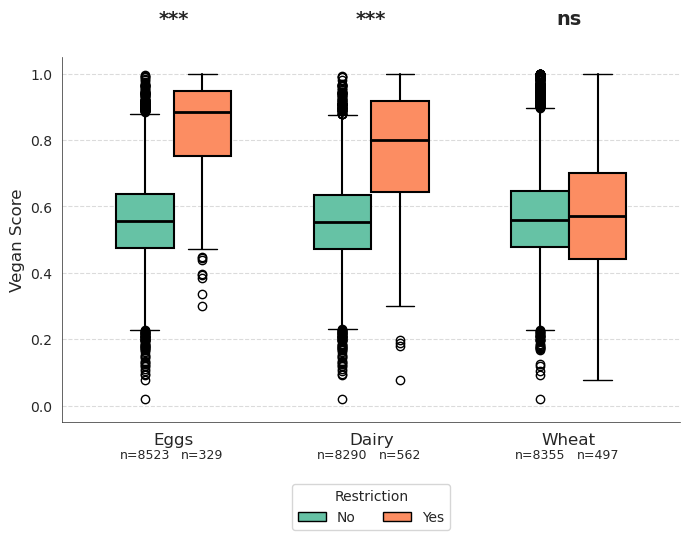

In [846]:
question_cols = ['never_eat__Eggs or foods that contain eggs', 
                 'never_eat__Dairy products', 
                 'never_eat__Wheat products']
fig = plot_vegan_adherence_comparison(diet_feature_lifestyle, 'vegan_score_per_day', question_cols, figsize=(7, 7),
                                      save_path=FIGS_DIR + '/diet_adherence_vegan_score_per_day_boxplot.png', title='')
plt.show()

In [849]:
def plot_diet_adherence_by_status(df, adherence_col, status_col, 
                                  title="Diet Adherence Score",
                                  palette=None, 
                                  figsize=(8, 10), 
                                  save_path=None):
    """
    Creates a box plot comparing diet adherence scores for 'yes' and 'no' responses 
    to a vegetarian/vegan status question.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    adherence_col : str
        Column name for the continuous adherence variable (values between 0 and 1)
    status_col : str
        Column name for the dietary status question (expected to be binary: 0 for No, 1 for Yes)
    title : str, optional
        Title for the plot (will be placed on x-axis)
    palette : list, optional
        Color palette to use for No/Yes responses
    figsize : tuple, optional
        Figure size (width, height) in inches
    save_path : str, optional
        If provided, the plot will be saved to this path
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Set default palette to Set2 if none provided
    if palette is None:
        palette = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]]
    
    # Create a copy of the dataframe
    plot_df = df.copy()
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare data for plotting
    no_data = plot_df[plot_df[status_col] == 0][adherence_col].dropna()
    yes_data = plot_df[plot_df[status_col] == 1][adherence_col].dropna()
    
    # Calculate sample sizes
    no_n = len(no_data)
    yes_n = len(yes_data)
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(yes_data, no_data, equal_var=False)
    
    # Determine significance level
    if p_value < 0.001:
        sig_stars = "***"
    elif p_value < 0.01:
        sig_stars = "**"
    elif p_value < 0.05:
        sig_stars = "*"
    else:
        sig_stars = "ns"
    
    # Create a list of all data points for boxplot
    all_data = [no_data, yes_data]
    
    # Define positions for box plots
    box_width = 0.4  # Width of each box
    positions = [0.7, 1.7]  # Positions for No and Yes boxes
    
    # Create boxplots
    boxprops = {'edgecolor': 'black', 'linewidth': 1.5}
    whiskerprops = {'linewidth': 1.5, 'color': 'black'}
    medianprops = {'linewidth': 2, 'color': 'black'}
    
    box_plot = ax.boxplot(all_data, positions=positions, widths=box_width, patch_artist=True,
                         boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops,
                         showfliers=True, flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'none'})
    
    # Color the boxes
    for i, box in enumerate(box_plot['boxes']):
        box.set_facecolor(palette[i])
    
    # Add significance bracket
    y_max = max([max(data) if len(data) > 0 else 0 for data in all_data])
    y_max = max(y_max, 1) * 1.05  # Make sure we have enough space for the significance stars
    
    # Draw bracket
    bracket_height = 0.03
    bracket_y = y_max + 0.02
    ax.plot([positions[0], positions[0], positions[1], positions[1]], 
            [bracket_y, bracket_y + bracket_height, bracket_y + bracket_height, bracket_y], 
            color='black', linewidth=1.5)
    
    # Add significance stars
    ax.text((positions[0] + positions[1]) / 2, bracket_y + bracket_height + 0.01, sig_stars, 
            ha='center', va='center', fontsize=14, fontweight='bold')
    
    # Add sample sizes at the bottom
    ax.text(positions[0], -0.01, f"n={no_n}", transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=11)
    ax.text(positions[1], -0.01, f"n={yes_n}", transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=11)
    
    # Set x-axis ticks and labels
    ax.set_xticks([])  # Remove x-ticks
    
    # Set y-axis limits
    ax.set_ylim(-0.05, min(1.05, y_max + 0.15))
    
    # Set y-axis ticks to go from 0 to 1 with 0.2 increments
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    
    # Set labels
    ax.set_ylabel("Vegetarian Score", fontsize=12)
    
    # # Add title at the bottom of the plot
    # ax.text(1.2, -0.3, title, ha='center', va='center', fontsize=20, fontweight='bold', 
    #         transform=ax.transAxes)
    
    # Add legend outside the plot
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor=palette[0], edgecolor='black', label='No'),
        plt.Rectangle((0, 0), 1, 1, facecolor=palette[1], edgecolor='black', label='Yes')
    ]
    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.22), 
              title=title, ncol=2, frameon=True, title_fontsize=12)
    
    # Add grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)  # Hide bottom spine
    # ax.spines['left'].set_linewidth(0.5)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    # Save plot if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

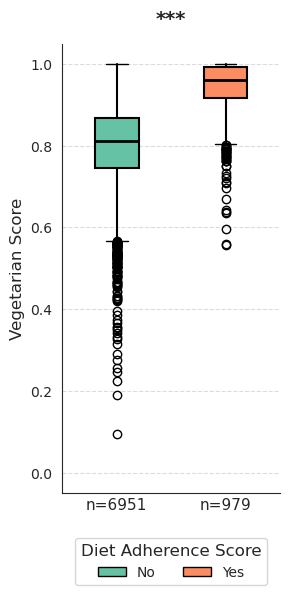

In [850]:
# plot diet adherence by status for vegetarian
fig = plot_diet_adherence_by_status(diet_feature_lifestyle, 'vegetarian_score_per_day', 'vegeterian_yes_no', figsize=(3, 7),
                                    save_path=FIGS_DIR + '/diet_adherence_vegetarian_score_per_day_boxplot.png')

## Elad's HR

In [694]:
# # import Elad's hazard ratios
# hr = pd.read_csv(DVIDKRO_DIR + '/risk_factor_project/X_and_predictions.csv', index_col=0)
# shaps_hr = pd.read_csv(DVIDKRO_DIR + '/risk_factor_project/shaps_for_david.csv', index_col=0)

In [695]:
# hr_diet = hr.join(diet_features, how='inner').join(agb_baseline['bmi'], how='inner')
# ms_hr = serrf_full_base.join(hr.drop(columns=['age','sex']), how='inner')
# ms_blood = serrf_full_base.join(blood_data_df_baseline, how='inner')

In [696]:
# # keep only rows with age between 40 and 70
# hr_clean = hr[(hr['age'] >= 40) & (hr['age'] <= 70)]
# hr_diet_clean = hr_diet[(hr_diet['age'] >= 40) & (hr_diet['age'] <= 70)]
# ms_hr_clean = ms_hr[(ms_hr['age'] >= 40) & (ms_hr['age'] <= 70)]

In [697]:
def create_age_bin_ranks(df, bin_size=5, age_col='age', pheno_age_col='phenotypic_age'):
    """
    Create age bins and rank phenotypic age within each bin.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing age and phenotypic age columns
    bin_size : int, default=5
        Size of age bins in years
    age_col : str, default='age'
        Name of the chronological age column
    pheno_age_col : str, default='phenotypic_age'
        Name of the phenotypic age column
    
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with additional columns:
        - 'age_bin': The age bin category
        - 'pheno_age_rank': Rank of phenotypic age within the age bin
        - 'pheno_age_rank_pct': Percentile rank within the age bin (0-100)
    """
    # Create copy to avoid modifying original
    df_result = df.copy()
    
    # Calculate bin edges to ensure all ages are included
    min_age = df_result[age_col].min()
    max_age = df_result[age_col].max()
    
    # Calculate the lower edge of the first bin
    # Floor divide min_age by bin_size and multiply back to get the bin start
    first_bin_edge = (min_age // bin_size) * bin_size
    
    # Calculate the upper edge of the last bin
    # Ceiling divide max_age by bin_size, multiply by bin_size, and add bin_size to include all values
    last_bin_edge = ((max_age // bin_size) + 1) * bin_size
    
    # Create bins
    bins = np.arange(first_bin_edge, last_bin_edge + bin_size, bin_size)
    
    # Create age bins
    df_result['age_bin'] = pd.cut(
        df_result[age_col],
        bins=bins,
        labels=False,
        include_lowest=True  # Include the lowest edge in the first bin
    )
    
    # Create age bin labels for better readability
    df_result['age_bin_label'] = pd.cut(
        df_result[age_col],
        bins=bins,
        include_lowest=True
    ).astype(str)
    
    # Calculate ranks within each bin
    df_result['pheno_age_rank'] = df_result.groupby('age_bin')[pheno_age_col].rank()
    
    # Calculate percentile ranks within each bin (0-100 scale)
    df_result['pheno_age_rank_pct'] = df_result.groupby('age_bin')[pheno_age_col].rank(pct=True) * 100
    
    # calculate the phenotypic age minus the minimal age in the bin
    df_result['phenotypic_age_reduced'] = df_result[pheno_age_col] - df_result.groupby('age_bin')[age_col].transform('min')
    
    return df_result

In [73]:
# ms_hr_clean_ranked = create_age_bin_ranks(ms_hr_clean)
# hr_diet_clean_ranked = create_age_bin_ranks(hr_diet_clean)

In [80]:
# pheno_age_ranked_cols = ['pheno_age_rank', 'pheno_age_rank_pct','age', 'phenotypic_age', 'phenotypic_age_reduced', 'gender', 'bmi']
# ms_hr_clean_ranked[pheno_age_ranked_cols].to_csv(output_data_dir + '/MS/y_hr_clean_ranked.csv')

In [81]:
# cols_ms_age = list(serrf_full_base.columns) + ['age_bin']
# ms_hr_clean_ranked[cols_ms_age].drop(columns=['age','gender','bmi']).to_csv(output_data_dir + '/MS/x_hr_clean_ranked.csv')
# ms_hr_clean_ranked[cols_ms_age].drop(columns=['age']).to_csv(output_data_dir + '/MS/x_hr_clean_ranked_w_GB.csv')

KeyboardInterrupt: 

In [ ]:
# import re
# # rename all columns with specail chras to _ 
# ms_hr_clean_ranked.columns = [re.sub(r'\W+', '_', col) for col in ms_hr_clean_ranked.columns]

In [ ]:
# # read feature importance column from wfpb diet
# wfpb_feature_importance = pd.read_csv(DIET_PAPER_DIR + '/Matched_Oral_wCCS/x_ms_matched/y_diet_adherence_scores/results/wfpb_score_per_day/feature_importance_wfpb_score_per_day.csv', index_col=0)
# top1000_wfpb = wfpb_feature_importance.head(1900)

In [ ]:
# # remove all indexes with top 100 impotance values in wfpb diet from columns in ms_hr_clean_ranked
# ms_hr_clean_ranked_filtered = ms_hr_clean_ranked.drop(columns=top1000_wfpb.index)

In [ ]:
# ms_hr_clean_ranked_filtered_diet = ms_hr_clean_ranked_filtered.join(diet_features[diet_scores_no_NOVA], how='inner')

In [ ]:
# # get all column with 'm_z' in the name or 'n_' in the name
# mz_cols = ms_hr_clean_ranked_filtered.columns[ms_hr_clean_ranked_filtered.columns.str.contains('m_z')]
# n_cols = ms_hr_clean_ranked_filtered.columns[ms_hr_clean_ranked_filtered.columns.str.contains('n_')]
# all_metabo_cols = mz_cols.union(n_cols)
# ms_hr_clean_ranked_filtered[all_metabo_cols].drop(columns=['age_bin_label']).to_csv(output_data_dir + '/MS/x_hr_clean_ranked_filtered_wfpb_1900.csv')

In [ ]:
# ms_hr_clean_ranked_filtered_diet.drop(columns=['age_bin_label']).to_csv(output_data_dir + '/MS/x_hr_clean_ranked_filtered_wfpb_0_diet.csv')

In [ ]:
# ms_hr_clean_ranked_filtered_diet[diet_scores_no_NOVA].to_csv(output_data_dir + '/MS/y_filtered_wfpb_1000_diet.csv')

In [ ]:
# # save sepereatly for each age_bin value
# for age_bin in ms_hr_clean_ranked['age_bin'].unique():
#     ms_hr_clean_ranked[ms_hr_clean_ranked['age_bin'] == age_bin][serrf_full_base.columns].drop(columns=['age','gender','bmi']).to_csv(output_data_dir + f'/MS/x_hr_clean_ranked_{age_bin}.csv')
#     ms_hr_clean_ranked[ms_hr_clean_ranked['age_bin'] == age_bin][serrf_full_base.columns].drop(columns=['age']).to_csv(output_data_dir + f'/MS/x_hr_clean_ranked_w_GB_{age_bin}.csv')
#     ms_hr_clean_ranked[ms_hr_clean_ranked['age_bin'] == age_bin][pheno_age_ranked_cols].to_csv(output_data_dir + f'/MS/y_hr_clean_ranked_{age_bin}.csv')

In [ ]:
# all columns starting wiht 's__'  from df
# mpa_only = diet_mb_mpa.loc[:, diet_mb_mpa.columns.str.startswith('s__')].join(diet_mb_mpa[['Richness', 'Shannon_diversity']])

## Joining the data

In [191]:
serrf_full_base.columns

Index(['1.81_904.4772n_290.2', '1.95_1076.5247n_352.29',
       '2.04_558.1404n_207.0', '1.88_1090.4203n_344.04',
       '1.66_334.0144n_180.66', '2.14_630.1615n_222.67',
       '2.13_602.0943n_294.0', '2.21_1106.4885n_353.01',
       '2.24_863.4035n_279.77', '2.35_856.3247n_269.15',
       ...
       '0.64_213.0860m/z_151.39', '0.62_244.0314m/z_142.91',
       '0.62_403.0312m/z_177.76', '0.60_145.0984m/z_134.63',
       '0.59_129.0044m/z_127.63', '0.59_143.0200m/z_136.23',
       '0.57_114.9885m/z_117.44', 'age', 'gender', 'bmi'],
      dtype='object', length=2250)

In [121]:
ms_joined_diet_features = serrf_full_base.join(diet_features, how='inner')
clusterd_09_base_joined = clusterd_09_base.join(diet_features, how='inner')
clusterd_08_base_joined = clusterd_08_base.join(diet_features, how='inner')
clusterd_07_base_joined = clusterd_07_base.join(diet_features, how='inner')
nightingale_data_diet = nightingale_data.join(diet_features, how='inner')
ms_joined_lifestyle = serrf_full_base.join(lifestyle_data_baseline_filtered, how='inner')

In [122]:
clusterd_09_base.shape

(5900, 1567)

In [123]:
clusterd_09_base_joined.shape

(5163, 2267)

In [124]:
ms_joined_diet_features.shape

(5163, 2950)

In [125]:
# load oral microbiome data
oral_mb = pd.read_parquet('/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/Data/10K/oral_microbiome/Data/species_oral_strict_preprocess.parquet')

In [126]:
oral_mb.shape

(7525, 122)

In [127]:
oral_mb.columns = oral_mb.columns.str.split('|').str[-1]
oral_mb.columns = oral_mb.columns.str.split('__').str[-1]

In [128]:
ms_oral_mb = serrf_full_base.join(oral_mb, how='inner')
oral_mb_diet = oral_mb.join(diet_features, how='inner')

In [129]:
ms_oral_mb.shape

(4083, 2372)

In [130]:
gut_mpa_baseline_agb = gut_mpa_baseline.join(agb_baseline, how='inner')
gut_mpa_baseline_agb_diet = gut_mpa_baseline_agb.join(diet_features, how='inner')
ms_mpa_baseline = serrf_full_base.join(gut_mpa_baseline, how='inner')

In [131]:
def filter_prevalence(df, baseline_cols, threshold=0.1):
   global_min = df[baseline_cols].min().min()
   baseline_mask = (df[baseline_cols] > global_min).mean() >= threshold
   other_cols = df.columns.difference(baseline_cols)
   # print number of columns kept out of baseline columns
   print(f'Number of columns kept: {df[baseline_cols].loc[:, baseline_mask].shape[1]} out of {df[baseline_cols].shape[1]}')
   return df[df[baseline_cols].loc[:, baseline_mask].columns.union(other_cols)], df[baseline_cols].loc[:, baseline_mask].columns

In [132]:
filtered_mpa_diet, filtered_diet_mpa_cols = filter_prevalence(gut_mpa_baseline_agb_diet, gut_mpa_baseline.columns, threshold=0.1)
filtered_ms_mpa, ms_mpa_cols = filter_prevalence(ms_mpa_baseline, gut_mpa_baseline.columns, threshold=0.1)

Number of columns kept: 378 out of 3512
Number of columns kept: 377 out of 3512


In [133]:
# import NOVA food scores
nova_scores_baseline = pd.read_csv('/net/mraid20/export/genie/LabData/Data/10K/foods/upf_baseline.csv', index_col=0)
nova_scores_visit2 = pd.read_csv('/net/mraid20/export/genie/LabData/Data/10K/foods/upf_2y.csv', index_col=0)
short_names_food_categories = pd.read_excel('/net/mraid20/export/genie/LabData/Data/10K/foods/scores_categories_short_names.xlsx', index_col=0)
nova_fiber = pd.read_csv('/home/godnean/PycharmProjects/nastyaPapers/fiber_per_person.csv', index_col=0)

In [134]:
# rename nova_fiber columns with _fiber suffix
nova_fiber.columns = [col + '_nova_fiber' for col in nova_fiber.columns]

In [135]:
nova_scores_baseline.columns

Index(['1', '2', '3', '4', 'NOVA Score'], dtype='object')

In [136]:
joined_diet_mpa_serrf_nightinglae = serrf_full_base.join(gut_mpa_baseline, how='inner').join(nightingale_data.drop(columns=['age', 'gender','bmi']), how='inner').join(diet_features, how='inner').join(nova_scores_baseline.drop('NOVA Score', axis=1), how='inner').join(nova_fiber, how='inner')
joined_diet_mpa_serrf_nightinglae_pre = serrf_full_base.join(gut_mpa_baseline, how='inner').join(nightingale_data.drop(columns=['age', 'gender','bmi']), how='inner').join(diet_features_pre, how='inner')
ms_mpa_nmr_oral_nova_baseline = serrf_full_base.join(gut_mpa_baseline, how='inner').join(nightingale_data.drop(columns=['age', 'gender','bmi']), how='inner').join(oral_mb, how='inner').join(nova_scores_baseline, how='inner').join(nova_fiber, how='inner')

In [137]:
joined_diet_mpa_serrf_nightinglae.shape

(3863, 6638)

In [138]:
joined_diet_mpa_serrf_nightinglae_pre.shape

(1921, 6286)

In [139]:
ms_mpa_nmr_diet_oral = joined_diet_mpa_serrf_nightinglae.join(oral_mb, how='inner')
ms_mpa_nmr_diet_oral_pre = joined_diet_mpa_serrf_nightinglae_pre.join(oral_mb, how='inner')

In [140]:
ms_mpa_nmr_diet_oral.shape

(3190, 6760)

In [141]:
ms_mpa_nmr_diet_oral_pre.shape

(1598, 6408)

In [142]:
ms_mpa_nmr_oral_lifestyle = serrf_full_base.join(gut_mpa_baseline, how='inner').join(nightingale_data.drop(columns=['age', 'gender','bmi']), how='inner').join(oral_mb, how='inner').join(lifestyle_data_baseline_filtered, how='inner')

In [143]:
ms_mpa_nmr_oral_lifestyle.shape

(2920, 6288)

In [144]:
ms_mpa_nmr_diet_oral.shape

(3190, 6760)

In [145]:
ms_mpa_nmr_oral_lifestyle.shape

(2920, 6288)

In [146]:
# print the shapes of all modalities sepreately 
print(f'Blood data shape: {serrf_full_base.shape}')
print(f'Gut microbiome data shape: {gut_mpa_baseline.shape}')
print(f'Nightgale data shape: {nightingale_data.shape}')
print(f'Diet data shape: {diet_features.shape}')
print(f'Lifestyle data shape: {lifestyle_data_baseline_filtered.shape}')
print(f'Oral microbiome data shape: {oral_mb.shape}')
print(f'MS Metabolites data shape: {serrf_full_base.shape}')
print(f'Joined data shape: {ms_mpa_nmr_diet_oral.shape}')

Blood data shape: (5900, 2250)
Gut microbiome data shape: (10902, 3512)
Nightgale data shape: (8495, 170)
Diet data shape: (10769, 700)
Lifestyle data shape: (11411, 237)
Oral microbiome data shape: (7525, 122)
MS Metabolites data shape: (5900, 2250)
Joined data shape: (3190, 6760)


In [147]:
joined_diet_mpa_serrf_nightinglae_filtered, filtered_cols = filter_prevalence(joined_diet_mpa_serrf_nightinglae, gut_mpa_baseline.columns, threshold=0.1)
ms_mpa_nmr_diet_oral_filtered, filtered_cols_w_oral = filter_prevalence(ms_mpa_nmr_diet_oral, gut_mpa_baseline.columns, threshold=0.1)

Number of columns kept: 382 out of 3512
Number of columns kept: 385 out of 3512


In [148]:
# Save the data
# # ms_joined_diet_features[serrf_full_base.columns].to_csv(output_data_dir + '/MS/x_diet_adherence.csv')
# ms_hr[serrf_full_base.columns].drop(columns=['age','bmi']).to_csv(output_data_dir + '/MS/x_hr.csv')
# ms_hr[['predicted', 'logprob',  'phenotypic_age', 'age']].to_csv(output_data_dir + '/MS/y_hr.csv')
# # ms_blood[serrf_full_base.columns].to_csv(output_data_dir + '/MS/x_blood.csv')
# # ms_blood[blood_data_df_baseline.columns].to_csv(output_data_dir + '/MS/y_blood.csv')

In [956]:
# ms_mpa_baseline[serrf_full_base.columns].to_csv(output_data_dir + '/MS/x_ms_mpa.csv')
# ms_mpa_baseline[ms_mpa_cols].to_csv(output_data_dir + '/MS/y_ms_mpa.csv')

In [204]:
diet_scores = [
    'IMEDAS_score_per_day',
    'eatLANCET_score_per_day',
    'aHEI_score_per_day',
    'DASH_score',
    'hPDI_score_per_day',
    'vegetarian_score_per_day',
    'vegan_score_per_day',
    'carnivore_score_per_day',
    'low_carb_diet',
    'pct_NOVA_4',
]
diet_scores_no_NOVA = ['med_score_per_day', 'paleo_score_per_day', 'vegetarian_score_per_day', 'wfpb_score_per_day', 'vegan_score_per_day', 'carnivore_score_per_day', 'keto']
pct_macros = ['pct_protein_calories', 'pct_fat_calories', 'pct_carb_calories', 'pct_saturated_fat_calories']
lipids_ratios = ['sat_to_total_lipids_ratio', 'trans_to_total_lipids_ratio', 'mono_to_total_lipids_ratio', 'poly_to_total_lipids_ratio', 'omega3_to_total_lipids_ratio', 'omega6_to_total_lipids_ratio', 'omega6_to_omega3_ratio']
plant_ratios = ['plant_energy_pct', 'plant_protein_pct', 'plant_fat_pct']

In [252]:
nutrients = ['Fiber, total dietary',
 'Calcium, Ca',
 'Iron, Fe',
 'Magnesium, Mg',
 'Phosphorus, P',
 'Potassium, K',
 'Sodium, Na',
 'Zinc, Zn',
 'Copper, Cu',
 'Vitamin C, total ascorbic acid',
 'Thiamin',
 'Riboflavin',
 'Niacin',
 'Vitamin B-6',
 'Folate, total',
 'Vitamin B-12',
 'Cholesterol',
             'Fiber, total dietary',
 'Fatty acids, total saturated',
 'Fatty acids, total monounsaturated',
 'Fatty acids, total polyunsaturated',
 'Vitamin D (D2 + D3)',
 'Sugars, Total',
 'Fatty acids, total trans',
 'Vitamin A, RAE',
 'Isoleucine',
 'Leucine',
 'Valine',
 'Lysine',
 'Threonine',
 'Methionine',
 'Phenylalanine',
 'Tryptophan',
 'Histidine',
 'Tyrosine',
 'Arginine',
 'Cystine',
 'Serine',
 'Pantothenic acid',
 'Selenium, Se',
 'Choline, total',
 'Manganese, Mn',
 'Fructose',
 'Vitamin K',
 'Iodine',
 'Sugar alcohols',
 'Biotin',
 'Alanine',
 'Ash',
 'Aspartic acid',
 'Betaine',
 'Caffeine',
 'Campesterol',
 'Fluoride, F',
 'Glucose',
 'Glutamic acid',
 'Glycine',
 'Hydroxyproline',
 'Lutein + zeaxanthin',
 'Lycopene',
 'Phytosterols',
 'Proline',
 'Starch',
 'omega_6',
 'omega_3',
 'vitamin_E',
 # 'Protein',
 # 'Total lipid (fat)',
 # 'Carbohydrate, by difference',
 'Energy',
 # 'Alcohol, ethyl',
 'Water']

In [145]:
never_eaters = [ 'never_eat__Dairy products',
 'never_eat__Eggs or foods that contain eggs',
 'never_eat__I eat everything above',
 'never_eat__Sugar or foods / beverages that contain sugar',
 'never_eat__Wheat products']

In [146]:
bread_types = [ 'bread_type_mainly_eat__Dark',
 'bread_type_mainly_eat__Hot',
 'bread_type_mainly_eat__White',
 'bread_type_mainly_eat__Whole wheat',
 'bread_type_mainly_eat__no']

In [147]:
cereal_types = [ 'cereal_type__Cornflakes or branflakes',
 'cereal_type__Cornflakes with sugar (cookies, pillows, etc.)',
 'cereal_type__Granola',
 'cereal_type__Oatmeal',
 'cereal_type__no']

In [228]:
food_categories = [ 'AlcoholicDrinks',
 'Beefveallambandothermeatproducts',
 'Bread_cat',
 'Bread_wholewheat',
 'Cannedvegandfruits',
 'Cereals_cat',
 'Deepfriedfoods',
 'Drinks',
 'Eggsandtheirproducts',
 'FastFoods',
 'Fishandseafood',
 'Fruits',
 'Hardcheese',
 'Industrializedvegetarianfoodreadytoeat',
 'MedOilandfats',
 'Nutsseedsandproducts',
 'Oilsandfats',
 'Others',
 'PastaGrainsandSidedishes',
 'PastaGrainsandSidedishes_wholewheat',
 'Poultryanditsproducts',
 'Proccessedmeatproducts',
 'Pulsesandproducts',
 'Snacks',
 'Soupsandsauces',
 'Spicesandherbs',
 'Vegetables',
 'bakedgoods',
 'fruitjuicesandsoftdrinks',
 'milkcreamcheeseandyogurts',
 'sweetmilkproducts',
 'sweets']

In [149]:
oil_types = [ 'oil_press_type_frying__Butter',
 'oil_press_type_frying__Cold pressed olive oil',
 'oil_press_type_frying__Margarine',
 'oil_press_type_frying__Olive oil',
 'oil_press_type_frying__Refined oil',
 'oil_press_type_frying__no',
 'oil_type_frying__Butter',
 'oil_type_frying__Coconut oil',
 'oil_type_frying__Margarine',
 'oil_type_frying__Olive oil',
 'oil_type_frying__Soy',
 'oil_type_frying__Soy Oil',
 'oil_type_frying__canola oil',
 'oil_type_frying__no',
 'oil_type_frying__sunflower oil']

In [150]:
foods = ['Acorn squash',
 'Alfalfa sprouts',
 'Almond Beverage',
 'Almond flour',
 'Almond spread',
 'Almonds',
 'Amba',
 'Apple',
 'Apple Cake',
 'Apple Vinegar',
 'Apple juice',
 'Apricot',
 'Apropo',
 'Artichoke',
 'Arugula',
 'Asparagus',
 'Avocado',
 'Avocado Sandwich',
 'Bagel',
 'Baguette',
 'Baked apple',
 'Baklava',
 'Balsamic vinegar',
 'Bamba',
 'Banana',
 'Banana Cake',
 'Barbecue sauce',
 'Barley soup',
 'Basil',
 'Bean Noodles',
 'Bean soup',
 'Beans',
 'Beans black-eyed peas',
 'Beef',
 'Beef Cholent',
 'Beef Lasagna',
 'Beef Shawarma',
 'Beer',
 'Beet',
 'Beet Salad',
 'Berries',
 'Biscuit',
 'Bissli',
 'Black beans',
 'Blintzes',
 'Blue Cheese',
 'Blueberries',
 'Boiled corn',
 'Bolognese',
 'Bounty',
 'Brazil nuts',
 'Bread',
 'Bread Crumbs',
 'Brioche',
 'Broccoli',
 'Broth',
 'Brown Rice',
 'Brown Sugar',
 'Brownies',
 'Buckwheat Bread',
 'Buckwheat crackers',
 'Bulgur',
 'Burekas',
 'Butter',
 'Butter Cookies',
 'Caesar Salad',
 'Cake',
 'Calamari',
 'Camembert or Brie',
 'Campari',
 'Candies',
 'Canned Sardine',
 'Canned Tuna Fish',
 'Canned corn',
 'Cappuccino',
 'Carpaccio',
 'Carrot Cake',
 'Carrot Juice',
 'Carrot Salad',
 'Carrots',
 'Cashew',
 'Cauliflower',
 'Cauliflower Patties',
 'Cauliflower Pie',
 'Celery',
 'Cereal Bar',
 'Cereals',
 'Ceviche',
 'Challah',
 'Chard',
 'Cheddar',
 'Cheese Pastry',
 'Cheese Pie',
 'Cheesecake',
 'Cherries',
 'Cherry tomatoes',
 'Chestnuts',
 'Chia seeds',
 'Chicken',
 'Chicken Liver',
 'Chicken Meatballs',
 'Chicken Pad Thai',
 'Chicken Shawarma',
 'Chicken Steak',
 'Chicken breast',
 'Chicken drumstick',
 'Chicken legs',
 'Chicken soup',
 'Chicken wings',
 'Chili pepper',
 'Chili sauce',
 'Chilli Con Carne',
 'Chocolate',
 'Chocolate Cookies',
 'Chocolate Mousse',
 'Chocolate balls',
 'Chocolate cake',
 'Chocolate spread',
 'Chopped Liver',
 'Ciabatta',
 'Cinnamon',
 'Cinnamon Danish',
 'Coated Biscuits',
 'Coated Wafers',
 'Coated peanuts',
 'Cocktail',
 'Coconut',
 'Coconut Oil',
 'Coconut milk',
 'Coconut water',
 'Coffee',
 'Coke',
 'Cold cut',
 'Coleslaw',
 'Cooked Okra',
 'Cooked Pumpkin',
 'Cooked Sweet potato',
 'Cooked broccoli',
 'Cooked cabbage',
 'Cooked green beans',
 'Cooked tomatoes',
 'Cooked vegetables',
 'Cooked zucchini',
 'Cookies',
 'Cookies Oreo',
 'Cooking cream',
 'Coriander',
 'Corn',
 'Corn Soup',
 'Corn casserole',
 'Corn crackers',
 'Corn schnitzel',
 'Cottage cheese',
 'Couscous',
 'Cracker',
 'Crackers',
 'Cranberries',
 'Cream Cake',
 'Cream Cheese',
 'Creme Brulee',
 'Croissant',
 'Croutons',
 'Crushed tomatoes',
 'Cuba',
 'Cucumber',
 'Curry Paste',
 'Danish',
 'Dark Chocolate',
 'Date honey',
 'Dates',
 'Dessert Wine',
 'Diet Cheesecake',
 'Diet Coke',
 'Dill',
 'Doritos',
 'Dried Fruit',
 'Dried Herring',
 'Dried Mango',
 'Dried apple',
 'Dried cranberries',
 'Dried fig',
 'Dried pineapple',
 'Edamame',
 'Eel',
 'Egg',
 'Egg Roll',
 'Egg Salad',
 'Egg Sandwich',
 'Egg noodles',
 'Egg yolk',
 'Eggplant',
 'Eggplant Salad',
 'Emmental cheese',
 'Empanadas',
 'Energy bar',
 'English cake',
 'Entrecote',
 'Eshel',
 'Falafel',
 'Fava beans',
 'Fennel',
 'Fennel Salad',
 'Feta Cheese',
 'Fig',
 'Fish Roe Salad',
 'Fish balls',
 'Fish schnitzel',
 'Flavored Waters',
 'Flavored Yogurt',
 'Flax seeds',
 'French fries',
 'Fried Bread',
 'Fried Sweet potato',
 'Fried cauliflower',
 'Fried eggplant',
 'Fried onions',
 'Fruit Drink',
 'Fruit flavored Yogurt',
 'Fruit juice',
 'Fruit salad',
 'Garlic',
 'Gefilte fish',
 'Gilthead Bream',
 'Gin and tonic',
 'Gluten free bread',
 'Gnocchi',
 'Goat Cheese',
 'Goat Milk Yogurt',
 'Goji berry',
 'Gouda Cheese',
 'Granola',
 'Granola Cookies',
 'Granola bar',
 'Grapefruit',
 'Grapefruit juice',
 'Grapes',
 'Greek Yogurt',
 'Greek salad',
 'Green Salad',
 'Green Tea',
 'Green beans',
 'Green cabbage',
 'Green onions',
 'Green pepper',
 'Grilled vegetables',
 'Grits',
 'Guacamole',
 'Guava',
 'Gumdrops',
 'Halloumi Cheese',
 'Halva',
 'Hamantaschen',
 'Hamburger',
 'Hazelnuts',
 'Heavy cream',
 'Herring',
 'Honey',
 'Honey Cake',
 'Hummus',
 'Hummus Salad',
 'Ice cream',
 'Ice cream bar',
 'Israeli couscous',
 'Jachnun',
 'Jam',
 'Jerusalem mixed grill',
 'Jewish donut',
 'Kashkaval',
 'Kebab',
 'Ketchup',
 'Kif Kef',
 'Kiwi',
 'Knafeh',
 'Knaidlach',
 'Kohlrabi',
 'Krembo',
 'Kugel',
 'Labneh Cheese',
 'Lamb Kebabs',
 'Lasagna',
 'Leek',
 'Lemon',
 'Lemon Pie',
 'Lemon juice',
 'Lemonade',
 'Lentil Patties',
 'Lentil Soup',
 'Lentils',
 'Lettuce',
 'Lettuce Salad',
 'Light Beer',
 'Light Bread',
 'Light Cream Cheese',
 'Light Soymilk',
 'Light Yellow Cheese',
 'Loquat',
 'Low fat Milk',
 'Lychee',
 'Macadamia nuts',
 'Majadra',
 'Malabi',
 'Malt beverage',
 'Manchego Cheese',
 'Mandarin',
 'Mango',
 'Maple Cake',
 'Maple syrup',
 'Mark Hariri',
 'Mars',
 'Marzipan',
 'Matbucha',
 'Matzo',
 'Mayonnaise',
 'Meagre Fish',
 'Meat Ravioli',
 'Meat Stuffed Burekas',
 'Meatballs',
 'Mekupelet',
 'Melon',
 'Milk',
 'Milky',
 'Mille-feuille',
 'Minced meat',
 'Mint',
 'Miso soup',
 'Mixed Vegetables',
 'Mixed nuts',
 'Moussaka',
 'Mousse Cake',
 'Mozzarella Cheese',
 'Mulberry',
 'Mushroom Pie',
 'Mushroom soup',
 'Mushrooms',
 'Mustard',
 'Mutton',
 'Natural Yogurt',
 'Natural Yogurt Drinks',
 'Nectarine',
 'Noodle Pie',
 'Noodles',
 'Nut cake',
 'Nuts',
 'Oat Drink',
 'Oatmeal',
 'Oatmeal Cereal',
 'Oil',
 'Olive Bread',
 'Olive oil',
 'Olive spread',
 'Olives',
 'Omelet sandwich',
 'Omelette',
 'Onion',
 'Onion Pie',
 'Onion Rings',
 'Onion soup',
 'Orange',
 'Orange Cake',
 'Orange Soup',
 'Orange juice',
 'Ouzo',
 'Pancake',
 'Papaya',
 'Parmesan cheese',
 'Parsley',
 'Passionflower',
 'Pasta',
 'Pasta Bolognese',
 'Pasta With Cheese',
 'Pasta with tomato sauce',
 'Pastrami',
 'Pate',
 'Pea soup',
 'Peach',
 'Peanut Butter',
 'Peanuts',
 'Pear',
 'Peas',
 'Peas and carrots',
 'Pecan',
 'Pecans',
 'Pepper',
 'Persimmon',
 'Pesek Zman snack',
 'Pesto',
 'Pickled Chili pepper',
 'Pickled Herring',
 'Pickled cucumber',
 'Pickled vegetables',
 'Pine nuts',
 'Pineapple',
 'Pistachio',
 'Pita',
 'Pizza',
 'Plum',
 'Polenta',
 'Pomegranate',
 'Pomegranate juice',
 'Pomelo',
 'Popcorn',
 'Popsicle',
 'Pork',
 'Portobello mushroom',
 'Potato chips',
 'Potato pancakes',
 'Potato pie',
 'Potato salad',
 'Potatoes',
 'Pretzels',
 'Prickly pears',
 'Protein Powder',
 'Protein bar',
 'Prune',
 'Puffs',
 'Pullet',
 'Pumpkin',
 'Pumpkin seeds',
 'Pumpkin soup',
 'Quinoa',
 'Quinoa Salad',
 'Radish',
 'Raisins',
 'Ravioli',
 'Red Cabbage Salad',
 'Red beans',
 'Red pepper',
 'Rice',
 'Rice Noodles',
 'Rice crackers',
 'Rice drink',
 'Rice paper',
 'Ricotta Cheese',
 'Risotto',
 'Roast beef',
 'Roasted eggplant',
 'Roll',
 'Roquefort',
 'Rugelach',
 'Rye Bread',
 'Sabih Sandwich',
 'Salmon',
 'Salmon Sandwich',
 'Salty Cheese',
 'Salty Cookies',
 'Sambusak',
 'Sauerkraut',
 'Sausages',
 'Sauteed vegetables',
 'Schnitzel',
 'Schug',
 'Seabass Fish',
 'Seaweeds',
 'Sesame oil',
 'Sesame seeds',
 'Shakshouka',
 'Sheep Milk Yoghurt',
 'Sheep milk Labaneh',
 'Sherbet',
 'Shrimp',
 'Small radish',
 'Smoked Mackerel Fish',
 'Smoked Salmon',
 'Smoothies',
 'Snickers',
 'Soup mandels',
 'Soy Patties',
 'Soy Pudding',
 'Soy sauce',
 'Soymilk',
 'Spelled',
 'Spinach',
 'Spinach Quiche',
 'Spongecake',
 'Sprouted lentils',
 'Sprouts',
 'Squash casserole',
 'Steak',
 'Steamed vegetables',
 'Strawberry',
 'Stuffed Cabbage',
 'Stuffed Chard',
 'Stuffed Vine leaves',
 'Sugar',
 'Sugar substitute',
 'Sunflower seeds',
 'Sushi',
 'Sweet Challah',
 'Sweet Potato Fries',
 'Sweet Potato Pie',
 'Sweet Potato Soup',
 'Sweet Roll',
 'Sweet potato',
 'Sweet wine',
 'Sweetened Cocoa Powder',
 'Sweetened White Cheese',
 'Tabbouleh Salad',
 'Tahini',
 'Tahini Bread',
 'Tea',
 'Teami waffle snack',
 'Teriyaki Sauce',
 'Thousand Island dressing',
 'Tilapia',
 'Tiramisu',
 'Toblerone',
 'Tofu',
 'Tofu Pad Thai',
 'Tom Yum soup',
 'Tomato paste',
 'Tomato sauce',
 'Tomato soup',
 'Tomato soup and rice',
 'Tomatoes',
 'Tomatoes Salad',
 'Tortilla',
 'Tuna Salad',
 'Tuna Sandwich',
 'Turkey',
 'Turkey Shawarma',
 'Turkey and vegetables',
 'Turkey breast',
 'Turkish Salad',
 'Turmeric powder',
 'Twix',
 'Tzatziki Cheese',
 'Tzfatit Cheese',
 'Veal Meatballs',
 'Veal kebabs',
 'Vegan Cheese',
 'Vegetable Pie',
 'Vegetable Salad',
 'Vegetable Soup',
 'Vegetable patties',
 'Veggie burger',
 'Vinaigrette',
 'Vodka or Arak',
 'Wafers',
 'Walnuts',
 'Watermelon',
 'Watermelon Seeds',
 'Wheat',
 'Whipped Cream Pudding',
 'Whipped cream',
 'Whiskey',
 'White Cheese',
 'White Chocolate',
 'White beans',
 'White cabbage salad',
 'Wholemeal Baguette',
 'Wholemeal Bread',
 'Wholemeal Crackers',
 'Wholemeal Light Bread',
 'Wholemeal Pita',
 'Wholemeal Roll',
 'Wild Rice',
 'Wine',
 'Yellow Cheese',
 'Yellow Cheese Sandwich',
 'Yellow beans',
 'Yellow pepper',
 'Yogurt',
 'Zaatar',
 'Zucchini',
 'Zucchini Patties',
 'black pepper',
 'dried tomato spread',
 'emmer wheat bread',
 'ginger',
 'kale',]

In [151]:
# get all columns with _distance_from_DRI in the columns name 
min_consumption = [col for col in diet_features.columns if '_distance_from_DRI' in col]
max_consumption = [col for col in diet_features.columns if '_distance_from_UL' in col]

In [152]:
ms_diet = serrf_full_base.join(diet_features, how='inner')

In [153]:
def create_quantile_features(df, nutrient_columns, quantile=0.1, include_top=False, include_bottom=True):
    """
    Create binary features indicating whether each nutrient is in its top and/or bottom quantile.
    Returns a defragmented DataFrame with new binary features.
    
    Parameters:
    df (pandas.DataFrame): Input dataframe containing nutrient columns
    nutrient_columns (list): List of column names for nutrients
    quantile (float): Quantile threshold (default 0.1 for 10%)
    include_top (bool): Whether to create features for top quantile (default False)
    include_bottom (bool): Whether to create features for bottom quantile (default True)
    
    Returns:
    pandas.DataFrame: Defragmented DataFrame with original and new binary features
    """
    # Initialize dictionary to store new feature series
    new_features = {}
    
    # Create binary features for each nutrient
    for nutrient in nutrient_columns:
        if include_bottom:
            bottom_threshold = df[nutrient].quantile(quantile)
            bottom_column = f"{nutrient}_bottom_{int(quantile*100)}pct"
            new_features[bottom_column] = (df[nutrient] <= bottom_threshold).astype(int)
        
        if include_top:
            top_threshold = df[nutrient].quantile(1 - quantile)
            top_column = f"{nutrient}_top_{int(quantile*100)}pct"
            new_features[top_column] = (df[nutrient] >= top_threshold).astype(int)
    
    # Combine original dataframe with new features efficiently
    result_df = pd.concat([df, pd.DataFrame(new_features)], axis=1)
    
    # Return a defragmented copy
    return result_df.copy()

In [154]:
ms_diet_quantiles = create_quantile_features(ms_diet, nutrients, quantile=0.1, include_bottom=True, include_top=True)

KeyError: 'Fatty acids, total saturated'

### Save the data

In [163]:
ms_mpa_nmr_diet_oral_filtered.reset_index()['index'].to_csv(output_data_dir + '/matched_3190_registration_codes.csv', index=False)

In [164]:
# save ms_mpa_nmr_diet_oral_filtered index to a csv file
ms_mpa_nmr_diet_oral_filtered[['age', 'bmi']].describe()

,age,bmi
count,3190.000000,3187.000000
mean,51.947022,25.991883
std,7.808102,4.044971
min,33.000000,16.121168
25%,46.000000,23.167230
50%,51.000000,25.529791
75%,57.000000,28.257738
max,75.000000,42.071159


In [165]:
ms_mpa_nmr_diet_oral_filtered.gender.value_counts()

gender
0.0    1612
1.0    1578
Name: count, dtype: int64

In [171]:
ms_mpa_nmr_diet_oral_filtered_lifestyle = ms_mpa_nmr_diet_oral_filtered.join(lifestyle_data_baseline.reset_index().set_index('RegistrationCode'), how='inner')

In [175]:
lifestyle_data_baseline.smoke_tobacco_now.value_counts()

smoke_tobacco_now
 0.0    8792
 0.5     834
 1.0     647
-1.0      45
Name: count, dtype: int64

In [189]:
ms_mpa_nmr_diet_oral_filtered_lifestyle.shape

(2697, 3895)

In [179]:
ms_mpa_nmr_diet_oral_filtered_lifestyle.smoke_tobacco_now.value_counts()

smoke_tobacco_now
 0.0    2096
 0.5     182
 1.0     137
-1.0      10
Name: count, dtype: int64

In [180]:
# import medical conditions
medical_conditions = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/DeepVoiceFolder/nastya_medical_conditions_baseline_consolidated_above1percent.csv', index_col=0)

In [186]:
ms_mpa_nmr_diet_oral_filtered_medical_conds = ms_mpa_nmr_diet_oral_filtered.join(medical_conditions, how='inner')

In [188]:
ms_mpa_nmr_diet_oral_filtered_medical_conds['Diabetes'].value_counts()

Diabetes
0    2708
1      10
Name: count, dtype: int64

In [160]:
### save the final joined data MS X MPA X NIGHTINGALE X Oral
nightingale_cols = list(nightingale_data.columns) + ['age', 'gender', 'bmi']
mpa_cols = list(filtered_cols_w_oral) + ['age', 'gender', 'bmi']
oral_cols = list(oral_mb.columns) + ['age', 'gender', 'bmi']
ms_cols = clusterd_09.drop(columns=['RegistrationCode', 'research_stage']).columns

ms_mpa_cols = list(set(ms_cols).union(set(filtered_cols_w_oral)))
ms_oral_cols = list(set(ms_cols).union(set(oral_mb.columns)))
ms_nmr_cols = list(set(ms_cols).union(set(nightingale_cols)))
ms_mpa_nmr_cols = list(set(ms_cols).union(set(filtered_cols_w_oral)).union(set(nightingale_cols)))
ms_mpa_nmr_oral_cols = list(set(ms_mpa_nmr_cols).union(set(oral_mb.columns)))

ms_mpa_nmr_diet_oral_filtered[ms_cols].to_csv(output_data_dir + '/x_ms_matched.csv')
ms_mpa_nmr_diet_oral_pre[ms_cols].to_csv(output_data_dir + '/Previsit/x_ms_matched_pre.csv')
ms_mpa_nmr_oral_lifestyle[ms_cols].to_csv(output_data_dir + '/Lifestyle/x_ms_matched.csv')


ms_mpa_nmr_diet_oral_filtered[nightingale_cols].to_csv(output_data_dir + '/x_NMR_matched.csv')
ms_mpa_nmr_diet_oral_pre[nightingale_cols].to_csv(output_data_dir + '/Previsit/x_NMR_matched_pre.csv')

ms_mpa_nmr_oral_lifestyle[nightingale_cols].to_csv(output_data_dir + '/Lifestyle/x_NMR_matched.csv')
ms_mpa_nmr_diet_oral_filtered[mpa_cols].to_csv(output_data_dir + '/x_mpa_matched.csv')
ms_mpa_nmr_diet_oral_pre[mpa_cols].to_csv(output_data_dir + '/Previsit/x_mpa_matched_pre.csv')

ms_mpa_nmr_oral_lifestyle[mpa_cols].to_csv(output_data_dir + '/Lifestyle/x_mpa_matched.csv')
ms_mpa_nmr_diet_oral_filtered[oral_cols].to_csv(output_data_dir + '/x_oral_matched.csv')
ms_mpa_nmr_diet_oral_pre[oral_cols].to_csv(output_data_dir + '/Previsit/x_oral_matched_pre.csv')
ms_mpa_nmr_oral_lifestyle[oral_cols].to_csv(output_data_dir + '/Lifestyle/x_oral_matched.csv')

ms_mpa_nmr_diet_oral_filtered[ms_mpa_cols].to_csv(output_data_dir + '/x_ms_mpa_matched.csv')
ms_mpa_nmr_oral_lifestyle[ms_mpa_cols].to_csv(output_data_dir + '/Lifestyle/x_ms_mpa_matched.csv')
ms_mpa_nmr_diet_oral_filtered[ms_oral_cols].to_csv(output_data_dir + '/x_ms_oral_matched.csv')
ms_mpa_nmr_oral_lifestyle[ms_oral_cols].to_csv(output_data_dir + '/Lifestyle/x_ms_oral_matched.csv')
ms_mpa_nmr_oral_lifestyle[lifestyle_data_baseline_filtered.columns].to_csv(output_data_dir + '/Lifestyle/y_lifestyle_matched.csv')

ms_mpa_nmr_diet_oral_filtered[ms_nmr_cols].to_csv(output_data_dir + '/x_ms_NMR_matched.csv')
ms_mpa_nmr_oral_lifestyle[ms_nmr_cols].to_csv(output_data_dir + '/Lifestyle/x_ms_NMR_matched.csv')
ms_mpa_nmr_diet_oral_filtered[ms_oral_cols].to_csv(output_data_dir + '/x_ms_oral_matched.csv')
ms_mpa_nmr_diet_oral_filtered[ms_mpa_nmr_cols].to_csv(output_data_dir + '/x_ms_mpa_NMR_matched.csv')

In [974]:
nova_cols = list(nova_scores_baseline.columns) + list(nova_fiber.columns)
ms_mpa_nmr_diet_oral_filtered[nova_cols].to_csv(output_data_dir + '/y_nova_scores.csv')

In [975]:
# ms_mpa_nmr_diet_oral_filtered[ms_mpa_nmr_oral_cols].to_csv(output_data_dir + '/x_ms_mpa_NMR_oral_matched.csv')

In [976]:
ms_mpa_nmr_diet_oral_filtered[diet_scores].to_csv(output_data_dir + '/y_diet_adherence_scores.csv')
ms_mpa_nmr_diet_oral_filtered[food_categories].to_csv(output_data_dir + '/y_food_categories.csv')
ms_mpa_nmr_diet_oral_filtered[pct_macros].to_csv(output_data_dir + '/y_diet_macros.csv')
ms_mpa_nmr_diet_oral_filtered[lipids_ratios].to_csv(output_data_dir + '/y_lipid_ratios.csv')
ms_mpa_nmr_diet_oral_filtered[plant_ratios].to_csv(output_data_dir + '/y_plant_ratios.csv')
ms_mpa_nmr_diet_oral_filtered[nutrients].to_csv(output_data_dir + '/y_nutrients.csv')
# joined_diet_mpa_serrf_nightinglae_filtered[never_eaters].to_csv(output_data_dir + '/y_never_eaters.csv')
# joined_diet_mpa_serrf_nightinglae_filtered[bread_types].to_csv(output_data_dir + '/y_bread_types.csv')
# joined_diet_mpa_serrf_nightinglae_filtered[oil_types].to_csv(output_data_dir + '/y_oil_types.csv')
# joined_diet_mpa_serrf_nightinglae_filtered[cereal_types].to_csv(output_data_dir + '/y_cereal_types.csv')
ms_mpa_nmr_diet_oral_filtered[foods].to_csv(output_data_dir + '/y_foods.csv')

In [162]:
diet_scores

['IMEDAS_score_per_day',
 'eatLANCET_score_per_day',
 'aHEI_score_per_day',
 'DASH_score',
 'hPDI_score_per_day',
 'vegetarian_score_per_day',
 'vegan_score_per_day',
 'carnivore_score_per_day',
 'keto',
 'low_carb_diet',
 'pct_NOVA_4']

In [172]:
filtered_list = [x for x in diet_scores if x not in ['hPDI_score_per_day', 'pct_NOVA_4']]
filtered_list_nutr = [x for x in nutrients if x not in ['Fatty acids, total saturated', 'Isoleucine', 'Leucine', 'Valine', 'Lysine', 'Threonine', 'Methionine', 'Phenylalanine', 'Tryptophan', 'Histidine', 'Tyrosine', 'Arginine', 'Cystine', 'Serine', 'Alanine', 'Aspartic acid', 'Glutamic acid', 'Glycine', 'Hydroxyproline', 'Proline']]

In [176]:
foods_pre = ['Almond Beverage',
 'Almonds',
 'Apple',
 'Apple Cake',
 'Apricot',
 'Artichoke',
 'Arugula',
 'Avocado',
 'Bagel',
 'Baguette',
 'Bamba',
 'Banana',
 'Beans',
 'Beans black-eyed peas',
 'Beef',
 'Beer',
 'Beet',
 'Beet Salad',
 'Biscuit',
 'Blueberries',
 'Brazil nuts',
 'Bread',
 'Broccoli',
 'Brown Sugar',
 'Burekas',
 'Butter',
 'Butter Cookies',
 'Camembert or Brie',
 'Canned Tuna Fish',
 'Canned corn',
 'Cappuccino',
 'Carrot Salad',
 'Carrots',
 'Cashew',
 'Cauliflower',
 'Celery',
 'Cereals',
 'Cheesecake',
 'Cherries',
 'Cherry tomatoes',
 'Chia seeds',
 'Chicken',
 'Chicken Meatballs',
 'Chicken Steak',
 'Chicken breast',
 'Chicken drumstick',
 'Chicken legs',
 'Chicken soup',
 'Chili pepper',
 'Chocolate',
 'Chocolate Cookies',
 'Chocolate cake',
 'Chocolate spread',
 'Ciabatta',
 'Cinnamon',
 'Coffee',
 'Coke',
 'Cold cut',
 'Coleslaw',
 'Cooked green beans',
 'Cooked vegetables',
 'Cookies',
 'Coriander',
 'Corn',
 'Cottage cheese',
 'Couscous',
 'Cracker',
 'Crackers',
 'Cranberries',
 'Cream Cheese',
 'Croissant',
 'Cucumber',
 'Danish',
 'Dark Chocolate',
 'Date honey',
 'Dates',
 'Diet Coke',
 'Egg',
 'Egg Salad',
 'Eggplant',
 'Eggplant Salad',
 'English cake',
 'Falafel',
 'Feta Cheese',
 'Fig',
 'Flavored Yogurt',
 'Flax seeds',
 'French fries',
 'Fried onions',
 'Garlic',
 'Goat Cheese',
 'Goat Milk Yogurt',
 'Goji berry',
 'Gouda Cheese',
 'Granola',
 'Grapes',
 'Green Salad',
 'Green Tea',
 'Green cabbage',
 'Green onions',
 'Grilled vegetables',
 'Guacamole',
 'Halva',
 'Hamburger',
 'Hazelnuts',
 'Heavy cream',
 'Honey',
 'Hummus',
 'Hummus Salad',
 'Ice cream',
 'Israeli couscous',
 'Jam',
 'Kebab',
 'Ketchup',
 'Kiwi',
 'Kohlrabi',
 'Labneh Cheese',
 'Lemon',
 'Lemon juice',
 'Lentil Soup',
 'Lentils',
 'Lettuce',
 'Lettuce Salad',
 'Light Bread',
 'Light Yellow Cheese',
 'Low fat Milk',
 'Macadamia nuts',
 'Majadra',
 'Mandarin',
 'Mango',
 'Matbucha',
 'Mayonnaise',
 'Meatballs',
 'Melon',
 'Milk',
 'Mixed nuts',
 'Mozzarella Cheese',
 'Mushrooms',
 'Mustard',
 'Natural Yogurt',
 'Nectarine',
 'Noodles',
 'Oat Drink',
 'Oatmeal',
 'Oatmeal Cereal',
 'Olive oil',
 'Olives',
 'Omelette',
 'Onion',
 'Orange',
 'Orange juice',
 'Pancake',
 'Parmesan cheese',
 'Parsley',
 'Pasta',
 'Pasta with tomato sauce',
 'Pastrami',
 'Peach',
 'Peanut Butter',
 'Peanuts',
 'Pear',
 'Peas',
 'Pecan',
 'Pepper',
 'Persimmon',
 'Pesto',
 'Pickled cucumber',
 'Pistachio',
 'Pita',
 'Pizza',
 'Plum',
 'Pomegranate',
 'Pomelo',
 'Popcorn',
 'Popsicle',
 'Potatoes',
 'Pretzels',
 'Prune',
 'Pullet',
 'Pumpkin',
 'Pumpkin seeds',
 'Quinoa',
 'Raisins',
 'Red Cabbage Salad',
 'Rice',
 'Rice crackers',
 'Rice drink',
 'Roasted eggplant',
 'Roll',
 'Rye Bread',
 'Salmon',
 'Salty Cheese',
 'Salty Cookies',
 'Sausages',
 'Sauteed vegetables',
 'Schnitzel',
 'Shakshouka',
 'Sheep Milk Yoghurt',
 'Small radish',
 'Smoked Salmon',
 'Smoothies',
 'Soup mandels',
 'Soy sauce',
 'Soymilk',
 'Spelled',
 'Spinach',
 'Sprouts',
 'Steak',
 'Strawberry',
 'Stuffed Vine leaves',
 'Sugar',
 'Sunflower seeds',
 'Sushi',
 'Sweet potato',
 'Tahini',
 'Tea',
 'Tilapia',
 'Tofu',
 'Tomato paste',
 'Tomato sauce',
 'Tomatoes',
 'Tortilla',
 'Tuna Salad',
 'Turkey Shawarma',
 'Tzfatit Cheese',
 'Vegetable Salad',
 'Vegetable Soup',
 'Wafers',
 'Walnuts',
 'Watermelon',
 'Whipped cream',
 'Whiskey',
 'White Cheese',
 'Wholemeal Bread',
 'Wholemeal Crackers',
 'Wholemeal Roll',
 'Wine',
 'Yellow Cheese',
 'Yellow pepper',
 'Yogurt',
 'Zucchini',
 'emmer wheat bread',
 'ginger']

In [177]:
ms_mpa_nmr_diet_oral_pre[filtered_list].to_csv(output_data_dir + '/Previsit/y_diet_adherence_scores.csv')
ms_mpa_nmr_diet_oral_pre[food_categories].to_csv(output_data_dir + '/Previsit/y_food_categories.csv')
ms_mpa_nmr_diet_oral_pre[pct_macros].to_csv(output_data_dir + '/Previsit/y_diet_macros.csv')
ms_mpa_nmr_diet_oral_pre[lipids_ratios].to_csv(output_data_dir + '/Previsit/y_lipid_ratios.csv')
ms_mpa_nmr_diet_oral_pre[plant_ratios].to_csv(output_data_dir + '/Previsit/y_plant_ratios.csv')
ms_mpa_nmr_diet_oral_pre[filtered_list_nutr].to_csv(output_data_dir + '/Previsit/y_nutrients.csv')
ms_mpa_nmr_diet_oral_pre[foods_pre].to_csv(output_data_dir + '/Previsit/y_foods.csv')

In [175]:
diet_features_pre.columns.to_list()

['Almond Beverage',
 'Almonds',
 'Apple',
 'Apple Cake',
 'Apricot',
 'Artichoke',
 'Arugula',
 'Avocado',
 'Bagel',
 'Baguette',
 'Bamba',
 'Banana',
 'Beans',
 'Beans black-eyed peas',
 'Beef',
 'Beer',
 'Beet',
 'Beet Salad',
 'Biscuit',
 'Blueberries',
 'Brazil nuts',
 'Bread',
 'Broccoli',
 'Brown Sugar',
 'Burekas',
 'Butter',
 'Butter Cookies',
 'Camembert or Brie',
 'Canned Tuna Fish',
 'Canned corn',
 'Cappuccino',
 'Carrot Salad',
 'Carrots',
 'Cashew',
 'Cauliflower',
 'Celery',
 'Cereals',
 'Cheesecake',
 'Cherries',
 'Cherry tomatoes',
 'Chia seeds',
 'Chicken',
 'Chicken Meatballs',
 'Chicken Steak',
 'Chicken breast',
 'Chicken drumstick',
 'Chicken legs',
 'Chicken soup',
 'Chili pepper',
 'Chocolate',
 'Chocolate Cookies',
 'Chocolate cake',
 'Chocolate spread',
 'Ciabatta',
 'Cinnamon',
 'Coffee',
 'Coke',
 'Cold cut',
 'Coleslaw',
 'Cooked green beans',
 'Cooked vegetables',
 'Cookies',
 'Coriander',
 'Corn',
 'Cottage cheese',
 'Couscous',
 'Cracker',
 'Crackers',
 

In [1516]:
ms_joined_diet_features.shape

(4818, 2792)

In [1517]:
ms_diet.shape

(4818, 2792)

In [1518]:
ms_joined_diet_features[diet_scores].to_csv(output_data_dir + '/MS/y_diet_adherence_scores.csv')
ms_joined_diet_features[min_consumption].to_csv(output_data_dir + '/MS/y_min_consumption.csv')
ms_joined_diet_features[max_consumption].to_csv(output_data_dir + '/MS/y_max_consumption.csv')
ms_joined_diet_features[serrf_full_base.columns].to_csv(output_data_dir + '/MS/x_diet_features.csv')
# ms_joined_diet_features[pct_macros].to_csv(output_data_dir + '/y_diet_macros.csv')
# ms_joined_diet_features[lipids_ratios].to_csv(output_data_dir + '/y_diet_lipids.csv')
# ms_joined_diet_features[plant_ratios].to_csv(output_data_dir + '/y_diet_plant_ratios.csv')

In [328]:
# ms_joined_diet_features[nutrients].to_csv(output_data_dir + '/y_diet_nutrients.csv')
# ms_joined_diet_features[never_eaters].to_csv(output_data_dir + '/y_diet_never_eaters.csv')
# ms_joined_diet_features[bread_types].to_csv(output_data_dir + '/y_diet_bread_types.csv')
# ms_joined_diet_features[oil_types].to_csv(output_data_dir + '/y_diet_oil_types.csv')
# ms_joined_diet_features[cereal_types].to_csv(output_data_dir + '/y_diet_cereal_types.csv')
# ms_joined_diet_features[food_categories].to_csv(output_data_dir + '/y_diet_food_categories.csv')
# ms_joined_diet_features[foods].to_csv(output_data_dir + '/y_diet_foods.csv')

In [669]:
### save mpa with diet features
filtered_mpa_diet[diet_scores].to_csv(output_data_dir + '/MPA/y_diet_adherence_scores_mpa.csv')
mpa_cols_to_save = list(filtered_diet_mpa_cols) + ['age', 'gender', 'bmi']
filtered_mpa_diet[mpa_cols_to_save].to_csv(output_data_dir + '/MPA/x_mpa_diet.csv')

In [ ]:
# # save combined MPA + SERRF data
# joined_diet_mpa_serrf[diet_scores].to_csv(output_data_dir + '/y_diet_adherence_scores_mpa_serrf.csv')
# joined_diet_mpa_serrf[pct_macros].to_csv(output_data_dir + '/y_diet_macros_mpa_serrf.csv')
# joined_diet_mpa_serrf[lipids_ratios].to_csv(output_data_dir + '/y_diet_lipids_mpa_serrf.csv')
# joined_diet_mpa_serrf[plant_ratios].to_csv(output_data_dir + '/y_diet_plant_ratios_mpa_serrf.csv')
# joined_diet_mpa_serrf[nutrients].to_csv(output_data_dir + '/y_diet_nutrients_mpa_serrf.csv')
# joined_diet_mpa_serrf[never_eaters].to_csv(output_data_dir + '/y_diet_never_eaters_mpa_serrf.csv')
# joined_diet_mpa_serrf[bread_types].to_csv(output_data_dir + '/y_diet_bread_types_mpa_serrf.csv')
# joined_diet_mpa_serrf[oil_types].to_csv(output_data_dir + '/y_diet_oil_types_mpa_serrf.csv')
# joined_diet_mpa_serrf[cereal_types].to_csv(output_data_dir + '/y_diet_cereal_types_mpa_serrf.csv')
# joined_diet_mpa_serrf[food_categories].to_csv(output_data_dir + '/y_diet_food_categories_mpa_serrf.csv')
# joined_diet_mpa_serrf[foods].to_csv(output_data_dir + '/y_diet_foods_mpa_serrf.csv')

In [1519]:
### save lifesytle ms
ms_joined_lifestyle[serrf_full_base.columns].to_csv(output_data_dir + '/MS/x_lifestyle.csv')
ms_joined_lifestyle[lifestyle_data_baseline_filtered.columns].to_csv(output_data_dir + '/MS/y_lifestyle_answers.csv')

In [334]:
# hr_x_diet = hr.join(diet_features, how='inner')

In [335]:
# hr_x_diet.to_csv(os.path.join(output_data_dir, '../x_hr_diet.csv'))

In [118]:
# show all columns containing '220.0172m/z_147.92'
ms_joined_diet_features.filter(like='220.0172').columns

Index(['2.17_220.0172m/z_147.96'], dtype='object')

## Medical Condtions

In [ ]:
nastya_mc_baseline_above1 = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/DeepVoiceFolder/nastya_medical_conditions_baseline_above1percent.csv', index_col=0)
nastya_mc_followup_above1 = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/DeepVoiceFolder/nastya_medical_conditions_followup_above1percent.csv', index_col=0)
nastya_mc_baseline_above1_consolidate = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/DeepVoiceFolder/nastya_medical_conditions_baseline_consolidated_above1percent.csv', index_col=0)
nastya_mc_followup_above1_consolidate = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/DeepVoiceFolder/nastya_medical_conditions_followup_consolidated_above1percent.csv', index_col=0)
nastya_mc_followup_above1_consolidate = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/DeepVoiceFolder/nastya_medical_conditions_followup_consolidated_above1percent.csv', index_col=0)

In [266]:
# Get the actual duplicate index values
duplicated_values = serrf_full_base.index[serrf_full_base.index.duplicated()].unique()

In [339]:
ms_medical_conditions = serrf_full_base.join(nastya_mc_baseline_above1, how='left')
ms_medical_conditions_consolidated = serrf_full_base.join(nastya_mc_baseline_above1_consolidate, how='left')
mpa_medical_conditions = gut_mpa_baseline.join(nastya_mc_baseline_above1, how='left')
mpa_medical_conditions_consolidated = gut_mpa_baseline.join(nastya_mc_baseline_above1_consolidate, how='left')

In [343]:
# fill all nastya_mc_baseline_above1 columns with 0
ms_medical_conditions.update(ms_medical_conditions[nastya_mc_baseline_above1.columns].fillna(0))
ms_medical_conditions_consolidated.update(ms_medical_conditions_consolidated[nastya_mc_baseline_above1_consolidate.columns].fillna(0))
mpa_medical_conditions.update(mpa_medical_conditions[nastya_mc_baseline_above1.columns].fillna(0))
mpa_medical_conditions_consolidated.update(mpa_medical_conditions_consolidated[nastya_mc_baseline_above1_consolidate.columns].fillna(0))

In [347]:
mpa_medical_conditions_filtered, mpa_conditions_cols = filter_prevalence(mpa_medical_conditions, gut_mpa_baseline.columns, 0.1)
mpa_medical_conditions_consolidated_filtered, mpa_conditions_consolidated_cols = filter_prevalence(mpa_medical_conditions_consolidated, gut_mpa_baseline.columns, 0.1)

Number of columns kept: 377 out of 3359
Number of columns kept: 377 out of 3359


In [270]:
# save the data
ms_medical_conditions[serrf_full_base.columns].to_csv(output_data_dir + '/MS/x_medical_conditions.csv')
ms_medical_conditions[nastya_mc_baseline_above1.columns].to_csv(output_data_dir + '/MS/y_medical_conditions.csv')
ms_medical_conditions_consolidated[serrf_full_base.columns].to_csv(output_data_dir + '/MS/x_medical_conditions_consolidated.csv')
ms_medical_conditions_consolidated[nastya_mc_baseline_above1_consolidate.columns].to_csv(output_data_dir + '/MS/y_medical_conditions_consolidated.csv')

In [349]:
mpa_medical_conditions_filtered[mpa_conditions_cols].to_csv(output_data_dir + '/MPA/x_medical_conditions.csv')
mpa_medical_conditions_filtered[nastya_mc_baseline_above1.columns].to_csv(output_data_dir + '/MPA/y_medical_conditions.csv')
mpa_medical_conditions_consolidated_filtered[mpa_conditions_cols].to_csv(output_data_dir + '/MPA/x_medical_conditions_consolidated.csv')
mpa_medical_conditions_consolidated_filtered[nastya_mc_baseline_above1_consolidate.columns].to_csv(output_data_dir + '/MPA/y_medical_conditions_consolidated.csv')

In [50]:
def correlate_columns(df1, df2, target_column, columns_list=None, method='pearson'):
    """
    Calculate correlations between a target column from df1 and columns from df2.

    Parameters:
    -----------
    df1 : pandas.DataFrame
        The first DataFrame containing the target column
    df2 : pandas.DataFrame
        The second DataFrame containing the columns to correlate with
    target_column : str
        The name of the column from df1 to correlate against others
    columns_list : list, optional
        List of column names from df2 to correlate with target_column. 
        If None, will use all numeric columns from df2.
    method : str, optional
        The correlation method to use ('pearson', 'spearman', or 'kendall')
        Default is 'pearson'

    Returns:
    --------
    pandas.Series
        Series containing correlation coefficients sorted by absolute value in descending order

    Raises:
    -------
    ValueError
        If target_column is not in df1
        If any column in columns_list is not in df2
        If invalid correlation method is specified
        If DataFrames have different lengths
    """
    # Validate DataFrames have same length
    if len(df1) != len(df2):
        raise ValueError("DataFrames must have the same length")

    # Validate target column exists in df1
    if target_column not in df1.columns:
        raise ValueError(f"Target column '{target_column}' not found in first DataFrame")

    # Validate correlation method
    valid_methods = ['pearson', 'spearman', 'kendall']
    if method.lower() not in valid_methods:
        raise ValueError(f"Invalid correlation method. Choose from: {valid_methods}")

    # If no columns list provided, use all numeric columns from df2
    if columns_list is None:
        columns_list = df2.select_dtypes(include=[np.number]).columns.tolist()
    else:
        # Validate all columns exist in df2
        missing_cols = [col for col in columns_list if col not in df2.columns]
        if missing_cols:
            raise ValueError(f"Columns not found in second DataFrame: {missing_cols}")

    # Calculate correlations
    correlations = {}
    for col in columns_list:
        # Handle non-numeric columns
        if not np.issubdtype(df2[col].dtype, np.number):
            print(f"Warning: Skipping non-numeric column '{col}'")
            continue

        corr = df1[target_column].corr(df2[col], method=method)
        correlations[col] = corr

    # Convert to series and sort by absolute value
    corr_series = pd.Series(correlations)
    corr_series = corr_series.sort_values(key=abs, ascending=False)

    return corr_series

In [226]:
# Example usage
correlations = correlate_columns(df1=ms_joined_diet_features, df2=ms_joined_diet_features, target_column='2.17_220.0172m/z_147.96', columns_list=foods, method='pearson')

In [1466]:
def calculate_partial_correlations(data, metabolites, risk_factors, covariates=['age', 'gender', 'bmi'], method='pearson'):
    """
    Calculate partial correlations between metabolites and risk factors, filtering NaN values per pair.
    Also includes correlation values for covariates.
    """
    results = []
    
    for metabolite in metabolites:
        for risk_factor in risk_factors:
            # Select relevant columns
            cols_to_check = [metabolite, risk_factor] + covariates
            subset = data[cols_to_check].copy()
            
            # Filter rows where both metabolite and risk factor are not NaN
            valid_pairs = subset[metabolite].notna() & subset[risk_factor].notna()
            subset = subset[valid_pairs]
            
            # Check complete cases after pair-wise filtering
            n_complete = len(subset.dropna())
            min_samples = len(covariates) + 3
            
            result_dict = {
                'Metabolite': metabolite,
                'Risk_Factor': risk_factor,
                'N_Complete_Cases': n_complete
            }
            
            if n_complete < min_samples:
                result_dict.update({
                    'Partial_Correlation': np.nan,
                    'P_value': np.nan,
                    'Warning': f'Insufficient cases (n={n_complete}, min={min_samples})'
                })
                # Add NaN values for covariate correlations
                for cov in covariates:
                    result_dict.update({
                        f'{cov}_correlation': np.nan,
                        f'{cov}_pvalue': np.nan
                    })
                results.append(result_dict)
                continue
                
            try:
                # Calculate partial correlation
                pcorr = partial_corr(
                    data=subset.dropna(),
                    x=metabolite,
                    y=risk_factor,
                    covar=covariates,
                    method=method
                )
                
                result_dict.update({
                    'Partial_Correlation': pcorr['r'].values[0],
                    'P_value': pcorr['p-val'].values[0],
                    'Warning': None
                })
                
                # Calculate correlations for each covariate
                clean_data = subset.dropna()
                for cov in covariates:
                    # Calculate correlation with metabolite
                    corr_result = stats.pearsonr(clean_data[metabolite], clean_data[cov])
                    result_dict.update({
                        f'{cov}_correlation': corr_result[0],
                        f'{cov}_pvalue': corr_result[1]
                    })
                
            except Exception as e:
                result_dict.update({
                    'Partial_Correlation': np.nan,
                    'P_value': np.nan,
                    'Warning': str(e)
                })
                # Add NaN values for covariate correlations
                for cov in covariates:
                    result_dict.update({
                        f'{cov}_correlation': np.nan,
                        f'{cov}_pvalue': np.nan
                    })
            
            results.append(result_dict)
    
    results_df = pd.DataFrame(results)
    
    # Apply FDR correction to main partial correlation p-values
    valid_pvals = results_df['P_value'].notna()
    if valid_pvals.any():
        results_df.loc[valid_pvals, 'FDR_Adjusted_P'] = multipletests(
            results_df.loc[valid_pvals, 'P_value'],
            method='fdr_bh'
        )[1]
    else:
        results_df['FDR_Adjusted_P'] = np.nan
    
    # Apply FDR correction to covariate p-values
    for cov in covariates:
        pval_col = f'{cov}_pvalue'
        valid_cov_pvals = results_df[pval_col].notna()
        if valid_cov_pvals.any():
            results_df.loc[valid_cov_pvals, f'{cov}_FDR_Adjusted_P'] = multipletests(
                results_df.loc[valid_cov_pvals, pval_col],
                method='fdr_bh'
            )[1]
        else:
            results_df[f'{cov}_FDR_Adjusted_P'] = np.nan
        
    return results_df.sort_values('FDR_Adjusted_P', na_position='last')

In [412]:
# calculate_partial_correlations(hr_diet, metabolites=diet_scores, risk_factors=list(risk_factors_hr), covariates=['age', 'sex', 'bmi'], method='pearson').to_csv(output_data_dir + '/partial_correlations_hr_diet_adherence_pearson.csv')

In [417]:
# calculate_partial_correlations(hr_diet, metabolites=food_categories, risk_factors=list(risk_factors_hr), covariates=['age', 'sex', 'bmi'], method='spearman').to_csv(output_data_dir + '/partial_correlations_hr_food_categories_spearman.csv')

In [881]:
diet_features_agb = diet_features.join(agb_baseline, how='inner')

In [1277]:
diet_nutrients_corrs = calculate_partial_correlations(diet_features_agb, metabolites=nutrients, risk_factors=diet_scores, covariates=['age','gender', 'bmi'], method='pearson')

In [887]:
diet_nutrients_corrs.to_csv(DIET_PAPER_DIR + '/Partial Corrs/partial_correlations_diet_nutrients_adherence_pearson.csv')

In [ ]:
diet_mb_mpa[diet_scores].to_csv(output_data_dir + '/y_diet_adherence_scores_mpa.csv')
diet_mb_mpa[pct_macros].to_csv(output_data_dir + '/y_diet_macros_mpa.csv')
diet_mb_mpa[lipids_ratios].to_csv(output_data_dir + '/y_diet_lipids_mpa.csv')
diet_mb_mpa[plant_ratios].to_csv(output_data_dir + '/y_diet_plant_ratios_mpa.csv')

In [117]:
diet_mb_mpa[nutrients].to_csv(output_data_dir + '/y_diet_nutrients_mpa.csv')
diet_mb_mpa[never_eaters].to_csv(output_data_dir + '/y_diet_never_eaters_mpa.csv')
diet_mb_mpa[bread_types].to_csv(output_data_dir + '/y_diet_bread_types_mpa.csv')
diet_mb_mpa[oil_types].to_csv(output_data_dir + '/y_diet_oil_types_mpa.csv')
diet_mb_mpa[cereal_types].to_csv(output_data_dir + '/y_diet_cereal_types_mpa.csv')
diet_mb_mpa[food_categories].to_csv(output_data_dir + '/y_diet_food_categories_mpa.csv')

In [39]:
nightingale_data_diet[diet_scores].to_csv(output_data_dir + '/y_diet_adherence_scores_nightingale.csv')
nightingale_data_diet[pct_macros].to_csv(output_data_dir + '/y_diet_macros_nightingale.csv')
nightingale_data_diet[lipids_ratios].to_csv(output_data_dir + '/y_diet_lipids_nightingale.csv')
nightingale_data_diet[plant_ratios].to_csv(output_data_dir + '/y_diet_plant_ratios_nightingale.csv')
nightingale_data_diet[food_categories].to_csv(output_data_dir + '/y_diet_food_categories_nightingale.csv')
nightingale_data_diet[nutrients].to_csv(output_data_dir + '/y_diet_nutrients_nightingale.csv')

In [1091]:
import scipy.stats as stats
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

def analyze_nutrient_adherence_association(
    df, 
    nutrient_columns, 
    adherence_score_col,
    covariates=None,
    quantile=0.1
):
    """
    Analyze association between bottom-quantile nutrient consumption and diet adherence scores.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing nutrient and adherence data
    nutrient_columns (list): List of nutrient column names
    adherence_score_col (str): Name of the diet adherence score column (assumed 0-1 range)
    covariates (list): Optional list of covariate column names for regression
    quantile (float): Quantile threshold (default 0.1 for bottom 10%)
    
    Returns:
    dict: Dictionary containing statistical test results and regression results
    """
    results = {
        'statistical_tests': {},
        'regression_results': {}
    }
    
    # Create bottom quantile indicators first
    df_with_quantiles = create_quantile_features(
        df, 
        nutrient_columns, 
        quantile=quantile, 
        include_top=False, 
        include_bottom=True
    )
    
    # 1. Statistical Tests
    for nutrient in nutrient_columns:
        bottom_col = f"{nutrient}_bottom_{int(quantile*100)}pct"
        
        # Split adherence scores into bottom quantile and other groups
        bottom_group = df_with_quantiles[df_with_quantiles[bottom_col] == 1][adherence_score_col]
        other_group = df_with_quantiles[df_with_quantiles[bottom_col] == 0][adherence_score_col]
        
        # Perform both t-test and Wilcoxon rank-sum test
        t_stat, t_pval = stats.ttest_ind(bottom_group, other_group)
        w_stat, w_pval = stats.ranksums(bottom_group, other_group)
        
        # Calculate effect size (Cohen's d)
        cohens_d = (bottom_group.mean() - other_group.mean()) / np.sqrt(
            ((len(bottom_group) - 1) * bottom_group.std()**2 + 
             (len(other_group) - 1) * other_group.std()**2) /
            (len(bottom_group) + len(other_group) - 2)
        )
        
        results['statistical_tests'][nutrient] = {
            'bottom_quantile_mean': bottom_group.mean(),
            'others_mean': other_group.mean(),
            'mean_difference': bottom_group.mean() - other_group.mean(),
            't_statistic': t_stat,
            't_pvalue': t_pval,
            'wilcoxon_statistic': w_stat,
            'wilcoxon_pvalue': w_pval,
            'cohens_d': cohens_d,
        }
    
    # 2. Regression Analysis
    for nutrient in nutrient_columns:
        bottom_col = f"{nutrient}_bottom_{int(quantile*100)}pct"
        
        # Prepare regression variables
        X = df_with_quantiles[bottom_col]
        if covariates:
            X = pd.concat([X, df_with_quantiles[covariates]], axis=1)
        X = sm.add_constant(X)  # Add intercept
        y = df_with_quantiles[adherence_score_col]
        
        # Fit regression model
        model = OLS(y, X).fit()
        
        results['regression_results'][nutrient] = {
            'coefficients': model.params.to_dict(),
            'pvalues': model.pvalues.to_dict(),
            'r_squared': model.rsquared,
            'adj_r_squared': model.rsquared_adj,
            'conf_intervals': model.conf_int().to_dict(),
        }
    
    return results

def format_analysis_results(results, alpha=0.05, quantile=0.1):
    """
    Format the analysis results into a readable summary.
    
    Parameters:
    results (dict): Output from analyze_nutrient_adherence_association
    alpha (float): Significance level for highlighting significant results
    
    Returns:
    str: Formatted summary of results
    """
    summary = []
    
    summary.append("STATISTICAL TEST RESULTS")
    summary.append("-----------------------")
    for nutrient, stats in results['statistical_tests'].items():
        summary.append(f"\n{nutrient.upper()}:")
        summary.append(f"Mean Adherence Scores:")
        summary.append(f"  Bottom {int(quantile*100)}%: {stats['bottom_quantile_mean']:.3f}")
        summary.append(f"  Others: {stats['others_mean']:.3f}")
        summary.append(f"  Difference: {stats['mean_difference']:.3f}")
        
        # Add significance markers
        t_sig = '*' if stats['t_pvalue'] < alpha else ''
        w_sig = '*' if stats['wilcoxon_pvalue'] < alpha else ''
        
        summary.append(f"T-test p-value: {stats['t_pvalue']:.4f}{t_sig}")
        summary.append(f"Wilcoxon test p-value: {stats['wilcoxon_pvalue']:.4f}{w_sig}")
        summary.append(f"Effect size (Cohen's d): {stats['cohens_d']:.3f}")
    
    summary.append("\nREGRESSION RESULTS")
    summary.append("------------------")
    for nutrient, reg in results['regression_results'].items():
        summary.append(f"\n{nutrient.upper()}:")
        summary.append(f"R-squared: {reg['r_squared']:.3f}")
        summary.append("Coefficients:")
        for var, coef in reg['coefficients'].items():
            p_val = reg['pvalues'][var]
            sig = '*' if p_val < alpha else ''
            summary.append(f"  {var}: {coef:.3f} (p={p_val:.4f}){sig}")
    
    return '\n'.join(summary)


## PCA Analysis

In [192]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

def permanova_with_covariates(X, y, covariates, permutations=999, metric='euclidean'):
    """
    Perform PERMANOVA with covariates using partial regression approach
    """
    n = len(y)
    
    # Calculate distance matrices
    X_dist = squareform(pdist(X, metric=metric))
    y_dist = squareform(pdist(y.reshape(-1, 1), metric=metric))
    
    # Center matrices
    H = np.eye(n) - np.ones((n, n)) / n
    X_cent = H @ X_dist @ H
    y_cent = H @ y_dist @ H
    
    # Handle covariates
    if covariates is not None:
        # Calculate residuals for X after removing covariate effects
        covariates = np.column_stack([np.ones(n), covariates])  # Add intercept
        P = covariates @ np.linalg.pinv(covariates.T @ covariates) @ covariates.T
        X_resid = (np.eye(n) - P) @ X
        X_dist_resid = squareform(pdist(X_resid, metric=metric))
        X_cent = H @ X_dist_resid @ H
        
        # Calculate residuals for y after removing covariate effects
        y_resid = (np.eye(n) - P) @ y
        y_dist_resid = squareform(pdist(y_resid.reshape(-1, 1), metric=metric))
        y_cent = H @ y_dist_resid @ H
    
    # Calculate test statistic
    F_stat = np.sum(X_cent * y_cent) / np.sum(X_cent * X_cent)
    
    # Permutation test
    perms = np.zeros(permutations)
    for i in range(permutations):
        y_perm = np.random.permutation(y)
        if covariates is not None:
            y_perm_resid = (np.eye(n) - P) @ y_perm
            y_dist_perm = squareform(pdist(y_perm_resid.reshape(-1, 1), metric=metric))
        else:
            y_dist_perm = squareform(pdist(y_perm.reshape(-1, 1), metric=metric))
        y_cent_perm = H @ y_dist_perm @ H
        perms[i] = np.sum(X_cent * y_cent_perm) / np.sum(X_cent * X_cent)
    
    # Calculate p-value and R²
    p_value = (np.sum(perms >= F_stat) + 1) / (permutations + 1)
    R2 = F_stat  # In this context, F_stat is equivalent to R²
    
    return {
        'F_statistic': F_stat,
        'p_value': p_value,
        'R2': R2,
        'n_permutations': permutations
    }

In [197]:
def perform_pca_visualization(df, columns_for_pca, color_column, 
                            log_transform=False, 
                            standardize=True,
                            log_transform_color=False,
                            title=None,
                            color_scale='zscore',
                            cmap='RdBu_r',
                            center_colors=True,
                            covariates=None,
                            run_permanova=False,
                            use_quartiles=False,
                            show_histograms=False,
                            histogram_bins=30,
                            remove_borders=True,
                            figsize=(2.8, 2.8),    # Default changed to 2.8 x 2.8
                            fontsize=8,           # Parameter for controlling font sizes
                            show_colorbar=True,   # New parameter to control colorbar visibility
                            show_grid=False,    # New parameter to control grid visibility
                            show_correlations=True,
                            diet_variance_explained=False,  # New parameter to calculate variance explained
                            n_components_for_variance=3,
                            second_pc=2):     
    """Import necessary packages if they're not already imported""" 
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score


    import seaborn as sns
    """
    Perform PCA visualization with optional PERMANOVA analysis
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input data
    columns_for_pca : list
        List of column names to use for PCA
    color_column : str
        Column name to use for coloring points
    log_transform : bool or list, optional
        Whether to log-transform PCA features
    standardize : bool, optional
        Whether to standardize features before PCA
    log_transform_color : bool, optional
        Whether to log-transform the color column
    title : str, optional
        Plot title
    color_scale : str, optional
        Method for scaling color values ('zscore', 'minmax', 'center', 'none')
    cmap : str, optional
        Matplotlib colormap name
    center_colors : bool, optional
        Whether to center the colormap around zero
    covariates : list, optional
        List of covariate column names for PERMANOVA
    run_permanova : bool, optional
        Whether to run PERMANOVA analysis
    use_quartiles : bool, optional
        Whether to transform color values into quartiles
    show_histograms : bool, optional
        Whether to show histograms along the axes
    histogram_bins : int, optional
        Number of bins for histograms
    remove_borders : bool, optional
        Whether to remove borders/spines from plots
    figsize : tuple, optional
        Figure size in inches (width, height)
    fontsize : int, optional
        Font size for all text elements
    show_colorbar : bool, optional
        Whether to display the colorbar
    show_grid : bool, optional
        Whether to display grid lines
    
    Returns:
    --------
    pca : sklearn.decomposition.PCA
        Fitted PCA object
    X_pca : numpy.ndarray
        PCA-transformed data
    fig : matplotlib.figure.Figure
        Figure object
    permanova_results : dict or None
        PERMANOVA results if run_permanova=True
    """
    # Make a copy of the data
    data = df.copy()
    
    # Handle NaN values
    for col in columns_for_pca:
        if data[col].isnull().any():
            median_val = data[col].median()
            data[col].fillna(median_val, inplace=True)
    
    if data[color_column].isnull().any():
        median_color = data[color_column].median()
        data[color_column].fillna(median_color, inplace=True)
    
    # Handle covariates NaN values if provided
    if covariates is not None:
        for col in covariates:
            if data[col].isnull().any():
                if data[col].dtype in ['int64', 'float64']:
                    median_val = data[col].median()
                else:
                    median_val = data[col].mode()[0]
                data[col].fillna(median_val, inplace=True)
    
    # Handle log transformations
    if log_transform:
        if isinstance(log_transform, list):
            for col in log_transform:
                if col in columns_for_pca:
                    data[col] = np.log1p(data[col])
        else:
            for col in columns_for_pca:
                data[col] = np.log1p(data[col])
    
    if log_transform_color:
        data[color_column] = np.log1p(data[color_column])
    
    # Get color values
    color_values = data[color_column].values
    
    # Transform to quartiles if requested
    if use_quartiles:
        # Calculate quartiles from the color column
        q1, q2, q3 = np.percentile(color_values, [25, 50, 75])
        
        # Convert to quartile categories (0, 1, 2, 3 for Q1, Q2, Q3, Q4)
        quartile_values = np.zeros_like(color_values, dtype=int)
        quartile_values[(color_values >= q1) & (color_values < q2)] = 1
        quartile_values[(color_values >= q2) & (color_values < q3)] = 2
        quartile_values[color_values >= q3] = 3
        
        # Use these as the color values
        color_values = quartile_values
        
        # Override color scale setting since we've already categorized
        color_scale = 'none'
        
        # Adjust colormap settings for discrete values
        discrete_cmap = plt.cm.get_cmap(cmap, 4)
        cmap = discrete_cmap
    else:
        # Scale the color values for better visualization
        if color_scale == 'zscore':
            color_values = (color_values - np.mean(color_values)) / np.std(color_values)
        elif color_scale == 'minmax':
            color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        elif color_scale == 'center':
            color_values = color_values - np.mean(color_values)
    
    # Extract and potentially standardize features for PCA
    X = data[columns_for_pca].values
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    pc2 = second_pc - 1
    # Perform PCA
    max_components = max(2, n_components_for_variance) if diet_variance_explained else 2
    pca = PCA(n_components=max_components)
    X_pca = pca.fit_transform(X)
    
    # Get the first word of color_column (split by underscore)
    color_label = color_column.split('_')[0]
    # Calculate correlations between principal components and diet scores
    if show_correlations:
        pc1_corr, pc1_pval = pearsonr(X_pca[:, 0], data[color_column])
        pc2_corr, pc2_pval = pearsonr(X_pca[:, pc2], data[color_column])
        
        # Print correlation results to stdout
        print(f"Dataset: {title if title else color_column}")
        print(f"Correlation between PC1 and {color_column}: r = {pc1_corr:.3f}, p = {pc1_pval:.3e}")
        print(f"Correlation between PC2 and {color_column}: r = {pc2_corr:.3f}, p = {pc2_pval:.3e}")
        print("---")
        # Calculate Diet Score Variance Explained if requested
    variance_explained_results = None
    if diet_variance_explained:
        # Ensure we have the requested number of components
        if X_pca.shape[1] < n_components_for_variance:
            print(f"Warning: Requested {n_components_for_variance} components but only {X_pca.shape[1]} are available.")
            n_components = X_pca.shape[1]
        else:
            n_components = n_components_for_variance
        
        # Perform regression analysis using PCs to predict diet score
        model = LinearRegression()
        model.fit(X_pca[:, :n_components], data[color_column])
        
        # Predict values and calculate R²
        y_pred = model.predict(X_pca[:, :n_components])
        r2 = r2_score(data[color_column], y_pred)
        
        # Calculate R² for individual components
        individual_r2 = []
        for i in range(n_components):
            # Single component model
            model_single = LinearRegression()
            model_single.fit(X_pca[:, i].reshape(-1, 1), data[color_column])
            y_pred_single = model_single.predict(X_pca[:, i].reshape(-1, 1))
            r2_single = r2_score(data[color_column], y_pred_single)
            individual_r2.append(r2_single)
        
        # Store results
        variance_explained_results = {
            'total_r2': r2,
            'individual_r2': individual_r2,
            'n_components': n_components
        }
        
        # Print results
        print(f"Diet Score Variance Explained Results:")
        print(f"Dataset: {title if title else 'Unknown'}")
        print(f"Principal components 1-{n_components} explain {r2:.4f} (R²) of variance in {color_column}")
        print("Individual component contributions:")
        for i, r2_val in enumerate(individual_r2):
            print(f"  PC{i+1}: R² = {r2_val:.4f} ({r2_val*100:.2f}%)")
        print("---")
        
    # Set default font sizes for all text elements based on fontsize parameter
    plt.rcParams.update({
        'font.size': fontsize,
        'axes.labelsize': fontsize,
        'axes.titlesize': fontsize + 1,
        'xtick.labelsize': fontsize - 1,
        'ytick.labelsize': fontsize - 1,
        'legend.fontsize': fontsize - 1,
        'figure.titlesize': fontsize + 1
    })
    
    # Create visualization with GridSpec for better layout control
    if show_histograms:
        # For histograms, we need to adjust the layout for the compact size
        # Make histograms smaller relative to the main plot
        fig = plt.figure(figsize=figsize)
        
        # Define grid with histograms and optional colorbar on right
        if show_colorbar:
            # GridSpec with space for colorbar on right
            gs = plt.GridSpec(4, 5, figure=fig, 
                             height_ratios=[1, 5, 5, 5], 
                             width_ratios=[5, 5, 5, 0.5, 0.8])
            
            # Colorbar axis on the right
            cbar_ax = fig.add_subplot(gs[1:4, 4])
        else:
            # GridSpec without colorbar
            gs = plt.GridSpec(4, 4, figure=fig, 
                             height_ratios=[1, 5, 5, 5], 
                             width_ratios=[5, 5, 5, 1])
            cbar_ax = None
        
        # Main scatter plot in the center
        ax = fig.add_subplot(gs[1:4, 0:3])
        
        # Histograms at the top and right
        ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax)
        ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax)
        
        # Set white background for histograms and remove grid
        ax_histx.set_facecolor('white')
        ax_histx.grid(False)
        ax_histy.set_facecolor('white')
        ax_histy.grid(False)
        
        # Remove all ticks and labels from histograms
        ax_histx.tick_params(axis="both", which="both", bottom=False, top=False, 
                           labelbottom=False, left=False, right=False, labelleft=False)
        ax_histy.tick_params(axis="both", which="both", bottom=False, top=False, 
                           labelbottom=False, left=False, right=False, labelleft=False)
    else:
        # For compact size without histograms, adjust proportions
        fig = plt.figure(figsize=figsize)
        
        if show_colorbar:
            # Create layout with colorbar on right
            gs = plt.GridSpec(1, 2, figure=fig, width_ratios=[20, 1])
            
            # Main plot
            ax = fig.add_subplot(gs[0, 0])
            
            # Colorbar axis on the right
            cbar_ax = fig.add_subplot(gs[0, 1])
        else:
            # Simple layout without colorbar
            ax = fig.add_subplot(111)
            cbar_ax = None
    
    # Remove borders if specified
    if remove_borders:
        for spine in ax.spines.values():
            spine.set_visible(False)
        if show_histograms:
            for spine in ax_histx.spines.values():
                spine.set_visible(False)
            for spine in ax_histy.spines.values():
                spine.set_visible(False)
    
    # Set up colormap settings
    if use_quartiles:
        # For quartiles, use fixed range from 0 to 3
        vmin, vmax = -0.5, 3.5  # Slightly extended to ensure all categories are visible
    elif center_colors and cmap in ['RdBu_r', 'coolwarm', 'RdYlBu_r', 'seismic']:
        vmax = np.max(np.abs(color_values))
        vmin = -vmax
    else:
        vmax = np.max(color_values)
        vmin = np.min(color_values)
    
    # Create scatter plot - reduce point size for compact figure
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, pc2],
                        c=color_values,
                        cmap=cmap,
                        vmin=vmin,
                        vmax=vmax,
                        alpha=0.6,
                        s=3,  # Reduced point size for compact figure
                        edgecolors='none')
    
    ax.set_facecolor('white')
    
    if show_correlations:
        # Get the first word of color_column (split by underscore)
        color_label = color_column.split('_')[0]
        
        # Add PC1 correlation text in top right corner
        ax.text(0.98, 0.98, f"PC1-{color_label}\nr = {pc1_corr:.3f}\np = {pc1_pval:.2e}",
                transform=ax.transAxes, fontsize=fontsize-1,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        # Add PC2 correlation text in bottom left corner
        ax.text(0.02, 0.02, f"PC2-{color_label}\nr = {pc2_corr:.3f}\np = {pc2_pval:.2e}",
                transform=ax.transAxes, fontsize=fontsize-1,
                verticalalignment='bottom', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
    # Add Diet Score Variance Explained annotation if calculated
    if diet_variance_explained and variance_explained_results:
        # Create text for variance explained results
        r2 = variance_explained_results['total_r2']
        n = variance_explained_results['n_components']
        variance_text = f"PCs 1-{n} explain\n{r2:.3f} (R²) of\n{color_label} variance"
        
        # Add text box with results in the top left corner
        ax.text(0.98, 0.98, variance_text,
                transform=ax.transAxes, fontsize=fontsize-1,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Add colorbar if requested
    if show_colorbar and cbar_ax is not None:
        cbar = plt.colorbar(scatter, cax=cbar_ax, orientation='vertical')
        cbar.set_label(color_column, fontsize=fontsize-1)
        cbar.ax.tick_params(labelsize=fontsize-2)  # Smaller font for colorbar ticks
    
    # Add labels with controlled font size
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance explained)', fontsize=fontsize)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance explained)', fontsize=fontsize)
    # Remove tick marks on both axes while keeping labels
    ax.tick_params(axis='both', which='both', 
                   bottom=False, top=False, left=False, right=False,  # Hide the tick marks
                   labelbottom=True, labeltop=False, labelleft=True, labelright=False)  # Keep labels
    
    # Perform PERMANOVA if requested
    permanova_results = None
    if run_permanova and covariates is not None:
        # Prepare covariates matrix
        covar_matrix = data[covariates].values
        if standardize:
            covar_matrix = StandardScaler().fit_transform(covar_matrix)
        
        # Run PERMANOVA
        permanova_results = permanova_with_covariates(
            X_pca, 
            color_values, 
            covar_matrix,
            permutations=999
        )
    
    # Set title with PERMANOVA p-value if available
    if title is None:
        plot_title = f'Colored by {color_column}'
    else:
        plot_title = title
    
    # Add PERMANOVA p-value to title if available
    if permanova_results is not None:
        plot_title += f'\nPERMANOVA p = {permanova_results["p_value"]:.2e}'
    
    # Add title with controlled font size
    ax.set_title(plot_title, fontsize=fontsize)
    
    # Add grid if requested
    if show_grid:
        ax.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Thinner grid lines
    else:
        ax.grid(False)
        
    # Remove tick marks while keeping labels
    ax.tick_params(axis='both', which='both', length=0)
    
    # Add detailed PERMANOVA results to plot if available
    if permanova_results is not None:
        # Create text for PERMANOVA results
        stats_text = (
            f"PERMANOVA Results:\n"
            f"F = {permanova_results['F_statistic']:.3f}\n"
            f"p = {permanova_results['p_value']:.3e}\n"
            f"R² = {permanova_results['R2']:.3f}\n"
            f"Covariates: {', '.join(covariates)}"
        )
        
        # Add text box with results - smaller font for compact figure
        plt.text(0.02, 0.98, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=fontsize-2)
    
    # Add histograms if requested
    if show_histograms:
        # Calculate the bin edges for the histograms
        x_bins = np.linspace(np.min(X_pca[:, 0]), np.max(X_pca[:, 0]), histogram_bins + 1)
        y_bins = np.linspace(np.min(X_pca[:, 1]), np.max(X_pca[:, 1]), histogram_bins + 1)
        
        # Calculate bin centers for coloring
        x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
        y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2
        
        # Compute histograms
        x_hist, _ = np.histogram(X_pca[:, 0], bins=x_bins)
        y_hist, _ = np.histogram(X_pca[:, 1], bins=y_bins)
        
        # Initialize arrays to store color values for each bin
        x_colors = np.zeros(len(x_bins) - 1)
        y_colors = np.zeros(len(y_bins) - 1)
        
        # Calculate median color value for each bin
        for i in range(len(x_bins) - 1):
            bin_mask = (X_pca[:, 0] >= x_bins[i]) & (X_pca[:, 0] < x_bins[i+1])
            if np.any(bin_mask):
                if use_quartiles:
                    # For quartiles, use mode (most common quartile)
                    bin_colors = color_values[bin_mask]
                    if len(bin_colors) > 0:
                        x_colors[i] = np.median(bin_colors)
                else:
                    # For continuous colors, use median
                    bin_colors = data[color_column].values[bin_mask]
                    if len(bin_colors) > 0:
                        # Z-score normalize within each bin
                        x_colors[i] = (np.median(bin_colors) - np.mean(data[color_column])) / np.std(data[color_column])
        
        for i in range(len(y_bins) - 1):
            bin_mask = (X_pca[:, 1] >= y_bins[i]) & (X_pca[:, 1] < y_bins[i+1])
            if np.any(bin_mask):
                if use_quartiles:
                    # For quartiles, use mode (most common quartile)
                    bin_colors = color_values[bin_mask]
                    if len(bin_colors) > 0:
                        y_colors[i] = np.median(bin_colors)
                else:
                    # For continuous colors, use median
                    bin_colors = data[color_column].values[bin_mask]
                    if len(bin_colors) > 0:
                        # Z-score normalize within each bin
                        y_colors[i] = (np.median(bin_colors) - np.mean(data[color_column])) / np.std(data[color_column])
        
        # Normalize the histogram values
        x_hist_norm = x_hist / np.max(x_hist)
        y_hist_norm = y_hist / np.max(y_hist)
        
        # Create colored bars for histograms
        if use_quartiles:
            # For quartiles, use discrete colors
            if isinstance(cmap, str):
                colors = plt.cm.get_cmap(cmap, 4)
                x_bar_colors = [colors(int(val)) for val in x_colors]
                y_bar_colors = [colors(int(val)) for val in y_colors]
            else:
                x_bar_colors = [plt.cm.get_cmap(cmap.name)(val/3) for val in x_colors]
                y_bar_colors = [plt.cm.get_cmap(cmap.name)(val/3) for val in y_colors]
        else:
            # Normalize color values to [0, 1] for continuous colormap
            if center_colors and cmap in ['RdBu_r', 'coolwarm', 'RdYlBu_r', 'seismic']:
                max_color_abs = np.max(np.abs([np.min(x_colors), np.max(x_colors), 
                                              np.min(y_colors), np.max(y_colors)]))
                norm = plt.Normalize(-max_color_abs, max_color_abs)
            else:
                min_color = min(np.min(x_colors), np.min(y_colors))
                max_color = max(np.max(x_colors), np.max(y_colors))
                norm = plt.Normalize(min_color, max_color)
            
            if isinstance(cmap, str):
                cmap_func = plt.cm.get_cmap(cmap)
            else:
                cmap_func = cmap
                
            x_bar_colors = [cmap_func(norm(val)) for val in x_colors]
            y_bar_colors = [cmap_func(norm(val)) for val in y_colors]
        
        # Plot the colored histograms
        for i in range(len(x_hist)):
            ax_histx.bar(x_bin_centers[i], x_hist_norm[i], width=x_bins[1]-x_bins[0], 
                        color=x_bar_colors[i], edgecolor='none', alpha=0.7)
        
        for i in range(len(y_hist)):
            ax_histy.barh(y_bin_centers[i], y_hist_norm[i], height=y_bins[1]-y_bins[0],
                         color=y_bar_colors[i], edgecolor='none', alpha=0.7)
        
        # Adjust subplots for compact figure with histograms
        if show_colorbar:
            plt.subplots_adjust(top=0.92, bottom=0.15, left=0.15, right=0.85, hspace=0.12, wspace=0.12)
        else:
            plt.subplots_adjust(top=0.92, bottom=0.15, left=0.15, right=0.90, hspace=0.12, wspace=0.12)
    else:
        # Adjust layout for compact non-histogram plots
        if show_colorbar:
            plt.subplots_adjust(top=0.90, bottom=0.15, left=0.15, right=0.85)
        else:
            plt.subplots_adjust(top=0.90, bottom=0.15, left=0.15, right=0.95)
    return pca, X_pca, fig, permanova_results, {
        'correlations': (pc1_corr, pc1_pval, pc2_corr, pc2_pval) if show_correlations else None,
        'variance_explained': variance_explained_results if diet_variance_explained else None
    }

In [199]:
# Define column sets and their properties
dataset_configs = {
    'Gut_MB': {
        'columns': [col for col in filtered_cols_w_oral if col not in ['age', 'gender', 'bmi', 'Richness', 'Shannon_diversity']],
        'suffix': 'Gut_MB',
        'title': 'Gut Microbiome',
        'log_transform': True  # MPA doesn't need log transform,
    },
    'Oral_MB': {
        'columns': [col for col in oral_mb.columns if col not in ['age', 'gender', 'bmi', 'Richness', 'Shannon_diversity']],
        'suffix': 'Oral_MB',
        'title': 'Oral Microbiome',
        'log_transform': False  # MPA doesn't need log transform,
    },
    'NMR': {
        'columns': [col for col in nightingale_data.columns if col not in ['age', 'gender', 'bmi', 'Richness', 'Shannon_diversity'] and col in ms_mpa_nmr_diet_oral_filtered.columns],
        'suffix': 'NMR',
        'title': 'NMR Metabolomics',
        'log_transform': True
    },
    'MS': {
        'columns': [col for col in serrf_full_base.columns if col not in ['age', 'gender', 'bmi', 'Richness', 'Shannon_diversity'] and col in ms_mpa_nmr_diet_oral_filtered.columns],
        'suffix': 'MS',
        'title': 'Mass Spectrometry Full',
        'log_transform': True
    },
    'MS_09': {
        'columns': [col for col in clusterd_09_base.columns if col not in ['age', 'gender', 'bmi', 'Richness', 'Shannon_diversity'] and col in ms_mpa_nmr_diet_oral_filtered.columns],
        'suffix': 'MS_09',
        'title': 'Mass Spectrometry Clustered 0.9',
        'log_transform': True
    },
    'MS_07': {
        'columns': [col for col in clusterd_07_base.columns if col not in ['age', 'gender', 'bmi', 'Richness', 'Shannon_diversity'] and col in ms_mpa_nmr_diet_oral_filtered.columns],
        'suffix': 'MS_07',
        'title': 'Mass Spectrometry Clustered 0.7',
        'log_transform': True
    }
}

feature_to_color = 'hPDI_score_per_day'

# Perform PCA for each column set
for dataset_name, config in dataset_configs.items():
    print(f"\nProcessing {dataset_name}...")
    
    # Perform PCA and create visualization
    pca, X_pca, fig_pca, permanova_results, corr_results = perform_pca_visualization(
        df=ms_mpa_nmr_diet_oral_filtered,
        columns_for_pca=config['columns'],
        color_column=feature_to_color,
        log_transform=config['log_transform'],
        standardize=True,
        log_transform_color=False,
        color_scale='zscore',
        cmap='seismic',
        center_colors=True,
        # title=f"{config['title']} PCA\nColored by {feature_to_color}",
        title="",
        covariates=['age', 'gender', 'bmi'],
        run_permanova=False,
        use_quartiles=False,
        show_histograms=True,
        histogram_bins=30,
        remove_borders=True,
        figsize=(2.8, 2.8),
        fontsize=6,
        show_colorbar=False,
        show_grid=False,
        diet_variance_explained=True,
        n_components_for_variance=5,
        show_correlations=False,
        second_pc=2,
    )
    
    # Save figure
    output_filename = f'pca_{feature_to_color}_{config["suffix"]}_r2_withVariance.pdf'
    fig_pca.savefig(FIGS_DIR + '/' + output_filename, dpi=300)
    # save as png
    fig_pca.savefig(FIGS_DIR + '/' + output_filename.replace('.pdf', '.png'), dpi=300)
    plt.close(fig_pca)  # Close the figure to free memory


Processing Gut_MB...


/tmp/ipykernel_47486/2354921697.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)


Diet Score Variance Explained Results:
Dataset: Unknown
Principal components 1-5 explain 0.0911 (R²) of variance in hPDI_score_per_day
Individual component contributions:
  PC1: R² = 0.0101 (1.01%)
  PC2: R² = 0.0058 (0.58%)
  PC3: R² = 0.0363 (3.63%)
  PC4: R² = 0.0212 (2.12%)
  PC5: R² = 0.0176 (1.76%)
---


/tmp/ipykernel_47486/2354921697.py:503: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)



Processing Oral_MB...
Diet Score Variance Explained Results:
Dataset: Unknown
Principal components 1-5 explain 0.0231 (R²) of variance in hPDI_score_per_day
Individual component contributions:
  PC1: R² = 0.0053 (0.53%)
  PC2: R² = 0.0079 (0.79%)
  PC3: R² = 0.0015 (0.15%)
  PC4: R² = 0.0068 (0.68%)
  PC5: R² = 0.0015 (0.15%)
---


/tmp/ipykernel_47486/2354921697.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)
/tmp/ipykernel_47486/2354921697.py:503: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)



Processing NMR...
Diet Score Variance Explained Results:
Dataset: Unknown
Principal components 1-5 explain 0.0394 (R²) of variance in hPDI_score_per_day
Individual component contributions:
  PC1: R² = 0.0225 (2.25%)
  PC2: R² = 0.0114 (1.14%)
  PC3: R² = 0.0000 (0.00%)
  PC4: R² = 0.0000 (0.00%)
  PC5: R² = 0.0055 (0.55%)
---


/tmp/ipykernel_47486/2354921697.py:98: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)
/tmp/ipykernel_47486/2354921697.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u


Processing MS...


/tmp/ipykernel_47486/2354921697.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)


Diet Score Variance Explained Results:
Dataset: Unknown
Principal components 1-5 explain 0.2868 (R²) of variance in hPDI_score_per_day
Individual component contributions:
  PC1: R² = 0.1661 (16.61%)
  PC2: R² = 0.0116 (1.16%)
  PC3: R² = 0.0641 (6.41%)
  PC4: R² = 0.0331 (3.31%)
  PC5: R² = 0.0119 (1.19%)
---


/tmp/ipykernel_47486/2354921697.py:503: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)



Processing MS_09...


/tmp/ipykernel_47486/2354921697.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)


Diet Score Variance Explained Results:
Dataset: Unknown
Principal components 1-5 explain 0.3158 (R²) of variance in hPDI_score_per_day
Individual component contributions:
  PC1: R² = 0.1297 (12.97%)
  PC2: R² = 0.0052 (0.52%)
  PC3: R² = 0.1177 (11.77%)
  PC4: R² = 0.0363 (3.63%)
  PC5: R² = 0.0269 (2.69%)
---


/tmp/ipykernel_47486/2354921697.py:503: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)



Processing MS_07...


/tmp/ipykernel_47486/2354921697.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)


Diet Score Variance Explained Results:
Dataset: Unknown
Principal components 1-5 explain 0.3430 (R²) of variance in hPDI_score_per_day
Individual component contributions:
  PC1: R² = 0.1334 (13.34%)
  PC2: R² = 0.0049 (0.49%)
  PC3: R² = 0.0117 (1.17%)
  PC4: R² = 0.1134 (11.34%)
  PC5: R² = 0.0797 (7.97%)
---


/tmp/ipykernel_47486/2354921697.py:503: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


In [166]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold


def calculate_vip_scores(plsda, x):
    """
    Calculate VIP (Variable Importance in Projection) scores for PLS-DA
    
    Parameters:
    -----------
    plsda : PLSRegression
        Fitted PLS-DA model
    x : array-like
        Original feature matrix
        
    Returns:
    --------
    vip : array-like
        VIP scores for each feature
    """
    t = plsda.x_scores_
    w = plsda.x_weights_
    q = plsda.y_loadings_
    p, h = w.shape
    
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    
    for i in range(p):
        weight = np.array([(w[i,j] / np.sqrt(s[j]))**2 for j in range(h)])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    
    return vips

def calculate_r2q2(X, y, plsda, cv_folds=5):
    """
    Calculate R² and Q² values for PLS-DA model
    
    Parameters:
    -----------
    X : array-like
        Feature matrix
    y : array-like
        Target variable
    plsda : PLSRegression
        Fitted PLS-DA model
    cv_folds : int
        Number of cross-validation folds
        
    Returns:
    --------
    r2 : float
        R² score
    q2 : float
        Q² score from cross-validation
    """
    # Calculate R²
    y_pred = plsda.predict(X)
    r2 = plsda.score(X, y)
    
    # Calculate Q² using cross-validation
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    q2 = np.mean(cross_val_score(plsda, X, y, cv=cv))
    
    return r2, q2

def perform_plsda_analysis(df, columns_for_plsda, target_column,
                          n_components=2,
                          log_transform=False,
                          standardize=True,
                          threshold=None,
                          title=None,
                          cmap='RdBu_r'):
    """
    Perform enhanced PLS-DA analysis with visualization and comprehensive metrics
    
    [Previous parameters documentation remains the same]
    
    Returns:
    --------
    plsda : PLSRegression
        Fitted PLS-DA model
    X_plsda : numpy array
        Transformed features
    metrics : dict
        Dictionary containing R², Q², VIP scores, and feature importance
    fig : matplotlib figure
        Plot figure handle
    """
    # Make a copy of the data
    data = df.copy()
    
    # Handle NaN values and preprocessing as before
    for col in columns_for_plsda:
        if data[col].isnull().any():
            median_val = data[col].median()
            data[col].fillna(median_val, inplace=True)
    
    # Handle log transformations
    if log_transform:
        if isinstance(log_transform, list):
            for col in log_transform:
                if col in columns_for_plsda:
                    data[col] = np.log1p(data[col])
        else:
            for col in columns_for_plsda:
                data[col] = np.log1p(data[col])
    
    # Prepare features
    X = data[columns_for_plsda].values
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Prepare target
    y = data[target_column].values
    if threshold is not None:
        y = (y > threshold).astype(int)
    
    # Fit PLS-DA
    plsda = PLSRegression(n_components=n_components)
    X_plsda = plsda.fit_transform(X, y)[0]
    
    # Calculate metrics
    r2, q2 = calculate_r2q2(X, y, plsda)
    vip_scores = calculate_vip_scores(plsda, X)
    
    # Calculate explained variance for each component
    explained_var = np.var(X_plsda, axis=0) / np.var(X_plsda).sum() * 100
    
    # Combine feature importance metrics
    feature_importance = pd.DataFrame({
        'feature': columns_for_plsda,
        'coefficient': np.abs(plsda.coef_[:,0]),
        'vip_score': vip_scores
    })
    feature_importance = feature_importance.sort_values('vip_score', ascending=False)
    
    # Create visualization with enhanced information
    fig = plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 2, height_ratios=[1, 0.1])
    
    # Scatter plot
    ax1 = plt.subplot(gs[0, 0])
    scatter = ax1.scatter(X_plsda[:, 0], X_plsda[:, 1],
                         c=y,
                         cmap=cmap,
                         alpha=0.6,
                         s=50,
                         edgecolors='black',
                         linewidth=0.5)
    
    ax1.set_xlabel(f'PLS Component 1 ({explained_var[0]:.1f}% explained variance)')
    ax1.set_ylabel(f'PLS Component 2 ({explained_var[1]:.1f}% explained variance)')
    ax1.grid(True, linestyle='--', alpha=0.7)
    plt.colorbar(scatter, ax=ax1, label=target_column)
    
    # Add R² and Q² information
    metrics_text = f'R² = {r2:.3f}\nQ² = {q2:.3f}'
    ax1.text(0.02, 0.98, metrics_text,
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Feature importance plot
    ax2 = plt.subplot(gs[0, 1])
    top_n = 20  # Show top 20 features
    sns.barplot(data=feature_importance.head(top_n),
                x='vip_score',
                y='feature',
                ax=ax2)
    ax2.set_title('Top Features by VIP Score')
    ax2.set_xlabel('VIP Score')
    
    # Set overall title
    if title is None:
        plot_title = f'PLS-DA Results\nColored by {target_column}'
    else:
        plot_title = title
    
    fig.suptitle(plot_title, y=1.02)
    plt.tight_layout()
    
    # Compile metrics
    metrics = {
        'r2': r2,
        'q2': q2,
        'explained_variance': explained_var,
        'feature_importance': feature_importance,
        'vip_scores': vip_scores
    }
    
    return plsda, X_plsda, metrics, fig

In [392]:
diet_scores

['vegetarian_score_per_day',
 'pescatarian_score_per_day',
 'wfpb_score_per_day',
 'vegan_score_per_day',
 'carnivore_score_per_day',
 'keto',
 'low_carb_diet',
 'NOVA Score',
 'pct_NOVA_4',
 'IMEDAS_score_per_day',
 'eatLANCET_score_per_day']

In [393]:
target = 'IMEDAS_score_per_day'

# Perform PLS-DA for each column set
for dataset_name, config in dataset_configs.items():
    print(f"\nProcessing {dataset_name}...")
    
    # Perform PLS-DA and create visualization
    plsda, X_plsda, feature_importance, fig_plsda = perform_plsda_analysis(
        df=joined_diet_mpa_serrf_nightinglae,
        columns_for_plsda=config['columns'],
        target_column=target,
        n_components=2,
        log_transform=config['log_transform'],
        standardize=True,
        threshold=None,
        title=f"{config['title']} PLS-DA\nColored by"
    )
    
    # Save figure
    output_filename = f'plsda_{config["suffix"]}_{target}.png'
    fig_plsda.savefig(FIGS_DIR + '/' + output_filename, dpi=300, bbox_inches='tight')
    plt.close(fig_plsda)  # Close the figure to free memory
    
    # save feature importance
    # feature_importance.to_csv(FIGS_DIR + '/' + f'feature_importance_{config["suffix"]}_{target}.csv')


Processing MS...


KeyError: 'IMEDAS_score_per_day'

In [45]:
import umap
def perform_pca_umap_visualization(df, columns_for_projection, color_column,
                                 n_pca_components=None,
                                 variance_threshold=0.9,
                                 log_transform=False,
                                 standardize=True,
                                 log_transform_color=False,
                                 title=None,
                                 color_scale='zscore',
                                 cmap='RdBu_r',
                                 center_colors=True,
                                 n_neighbors=15,
                                 min_dist=0.1,
                                 random_state=42):
    """
    Perform PCA followed by UMAP with enhanced visualization.
    
    Parameters:
    -----------
    [...previous parameters...]
    n_pca_components : int, optional
        Number of PCA components to keep. If None, use variance_threshold
    variance_threshold : float, default=0.9
        Minimum explained variance ratio to maintain (used if n_pca_components is None)
    
    Returns:
    --------
    tuple
        (pca_object, umap_object, transformed_data, figure, explained_variance_ratio)
    """
    # Make a copy of the data
    data = df.copy()
    
    # Handle NaN values
    for col in columns_for_projection:
        if data[col].isnull().any():
            median_val = data[col].median()
            data[col].fillna(median_val, inplace=True)
    
    if data[color_column].isnull().any():
        median_color = data[color_column].median()
        data[color_column].fillna(median_color, inplace=True)
    
    # Handle log transformations
    if log_transform:
        if isinstance(log_transform, list):
            for col in log_transform:
                if col in columns_for_projection:
                    data[col] = np.log1p(data[col])
        else:
            for col in columns_for_projection:
                data[col] = np.log1p(data[col])
    
    if log_transform_color:
        data[color_column] = np.log1p(data[color_column])
    
    # Scale the color values
    color_values = data[color_column].values
    if color_scale == 'zscore':
        color_values = (color_values - np.mean(color_values)) / np.std(color_values)
    elif color_scale == 'minmax':
        color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
    elif color_scale == 'center':
        color_values = color_values - np.mean(color_values)
    
    # Extract and potentially standardize features
    X = data[columns_for_projection].values
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # First step: PCA
    if n_pca_components is None:
        # Use full PCA first to determine number of components
        pca_full = PCA()
        pca_full.fit(X)
        cumsum = np.cumsum(pca_full.explained_variance_ratio_)
        n_components = np.argmax(cumsum >= variance_threshold) + 1
    else:
        n_components = n_pca_components
    
    # Perform PCA with selected number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Print PCA information
    print(f"Using {n_components} PCA components")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Second step: UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    X_umap = reducer.fit_transform(X_pca)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set up colormap centering
    if center_colors and cmap in ['RdBu_r', 'coolwarm', 'RdYlBu_r', 'seismic']:
        vmax = np.max(np.abs(color_values))
        vmin = -vmax
    else:
        vmax = np.max(color_values)
        vmin = np.min(color_values)
    
    # Create scatter plot
    scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1],
                        c=color_values,
                        cmap=cmap,
                        vmin=vmin,
                        vmax=vmax,
                        alpha=0.6,
                        s=20,
                        edgecolors='black',
                        linewidth=0.5)
    
    # Add colorbar
    colorbar_label = color_column
    if log_transform_color:
        colorbar_label += ' (log-transformed)'
    if color_scale:
        colorbar_label += f' ({color_scale} scaled)'
    plt.colorbar(scatter, label=colorbar_label)
    
    # Add labels and title
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    
    # Set title
    if title is None:
        plot_title = f'PCA-UMAP Results Colored by {color_column}'
    else:
        plot_title = title
    
    plot_title += f'\n{n_components} PCA components ({pca.explained_variance_ratio_.sum():.1%} variance)'
    if log_transform:
        plot_title += '\nFeatures log-transformed'
    
    ax.set_title(plot_title)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return pca, reducer, X_umap, fig, pca.explained_variance_ratio_

In [252]:
# Perform UMAP for each column set
for dataset_name, config in dataset_configs.items():
    print(f"\nProcessing {dataset_name}...")
    
    # Perform UMAP and create visualization
    pca, umap_obj, X_umap, fig, var_ratio = perform_pca_umap_visualization(
        df=joined_diet_mpa_serrf_nightinglae,
        columns_for_projection=config['columns'],
        color_column=feature_to_color,
        log_transform=config['log_transform'],
        standardize=True,
        log_transform_color=False,
        color_scale='zscore',
        cmap='seismic',
        center_colors=True,
        title=f"{config['title']} UMAP\nColored by {feature_to_color}",
        n_neighbors=5,
        min_dist=0.5,
        n_pca_components=None
    )
    
    # Save figure
    output_filename = f'umap_pca_{feature_to_color}_{config["suffix"]}_n5min05.png'
    fig.savefig(FIGS_DIR + '/' + output_filename, dpi=300)
    plt.close(fig)  # Close the figure to free memory


Processing MPA...
Using 368 PCA components
Explained variance ratio: 0.897

Processing NMR...
Using 7 PCA components
Explained variance ratio: 0.903

Processing MS...
Using 451 PCA components
Explained variance ratio: 0.899

Processing MS_09...
Using 470 PCA components
Explained variance ratio: 0.898

Processing MS_07...
Using 437 PCA components
Explained variance ratio: 0.898


In [300]:
import LabData.DataLoaders.HardASCVDRiskScore as HardASCVDRiskScore
import LabData.DataLoaders.FraminghamRiskScore as FraminghamRiskScore
risk_scores = pd.read_csv('/net/mraid20/export/genie/LabData/Data/10K/rna_meeting/risk_factors.csv', index_col=0)

In [301]:
risk_scores

,gender,age,bt__total_cholesterol,bt__hdl_cholesterol,sitting_blood_pressure_systolic,smoke_tobacco_now,frs_score,frs_percent_risk,gender.1,age.1,bt__total_cholesterol.1,bt__hdl_cholesterol.1,sitting_blood_pressure_systolic.1,smoke_tobacco_now.1,ascvd_percent_risk
RegistrationCode,,,,,,,,,,,,,,,
10K_1001201093,0.0,42.0,172.4,64.0,104.0,0.5,3.0,2.0,0.0,42.0,172.4,64.0,104.0,0.5,0.010
10K_1002087123,0.0,42.0,201.7,38.0,145.0,0.0,10.0,6.3,0.0,42.0,201.7,38.0,145.0,0.0,0.016
10K_1002254441,1.0,45.0,261.0,60.0,107.0,0.0,9.0,7.9,1.0,45.0,261.0,60.0,107.0,0.0,0.019
10K_1007400622,0.0,64.0,221.0,81.0,125.0,0.0,10.0,6.3,0.0,64.0,221.0,81.0,125.0,0.0,0.042
10K_1007599726,0.0,55.0,225.2,70.0,91.0,0.0,6.0,3.3,0.0,55.0,225.2,70.0,91.0,0.0,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9995823183,1.0,47.0,176.3,57.0,120.0,0.0,8.0,6.7,1.0,47.0,176.3,57.0,120.0,0.0,0.016
10K_9996884777,0.0,53.0,181.0,48.0,105.0,0.5,8.0,4.5,0.0,53.0,181.0,48.0,105.0,0.5,0.030
10K_9998420917,0.0,47.0,214.0,94.0,97.0,0.0,3.0,2.0,0.0,47.0,214.0,94.0,97.0,0.0,0.003


In [297]:
# Load the data
hard_ascvd = HardASCVDRiskScore.get_data()
framingham = FraminghamRiskScore.get_data()

AttributeError: module 'LabData.DataLoaders.HardASCVDRiskScore' has no attribute 'get_data'

## Feature correlation analysis

In [417]:
def plot_correlation_circles(df, features, corr_method='pearson', figsize=(10, 8), 
                            text_color='black', cmap='RdYlGn', vmin=-1, vmax=1):
    """
    Create a correlation visualization using colored circles where the size and color 
    intensity represent correlation values, showing only the lower triangle.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame containing the data
    features : list
        List of column names to include in the correlation matrix
    corr_method : str, default 'pearson'
        Correlation method ('pearson', 'kendall', 'spearman')
    figsize : tuple, default (10, 8)
        Figure size
    text_color : str, default 'black'
        Color of text annotations
    cmap : str, default 'RdYlGn'
        Colormap to use (the example uses a red-white-green colormap)
    vmin, vmax : float, default -1, 1
        Min and max values for color scaling
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import re
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    
    
    # reverse the order of the features
    # features = features[::-1]
    
    # Calculate correlation matrix
    correlation_matrix = df[features].corr(method=corr_method)
    
    # Create figure with specified size
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set white background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    
    # Set up colormap using the newer API
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap_obj = plt.colormaps[cmap]
    
    # Number of features
    n = len(features)
    
    # Set up the axes
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-0.5, n - 0.5)
    
    # Make the plot square
    ax.set_aspect('equal')
    
    name_mapping = {
    'aHEI_score_per_day': 'AHEI',
    'eatLANCET_score_per_day': 'EAT-Lancet',
    'hPDI_score_per_day': 'hPDI',
    'DASH_score': 'DASH',
    'IMEDAS_score_per_day': 'iMEDAS',
    'vegetarian_score_per_day': 'Vegetarian',
    'vegan_score_per_day': 'Vegan',
    'carnivore_score_per_day': 'Carnivore',
    'low_carb_diet': 'Low-carb',
    'pct_NOVA_4': 'UPF'
}

    
    # Clean feature names by removing "*score_*per_day" pattern
    # cleaned_features = [re.sub(r'_score_per_day', '', feature) for feature in features]
    # cleaned_features = [re.sub(r'_score', '', feature) for feature in features]
    # Clean feature names
    cleaned_features = [name_mapping.get(feature, feature) for feature in features]

    # Position x-axis ticks and labels at the top - remove the last label since diagonal isn't plotted
    ax.xaxis.tick_top()
    ax.set_xticks(range(n-1))  # One fewer tick on x-axis
    ax.set_yticks(range(1, n))  # Start y-axis from index 1 (second feature)
    ax.set_xticklabels(cleaned_features[:-1], rotation=45, ha='left', fontsize=12)
    ax.set_yticklabels(cleaned_features[1:], fontsize=12)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Add grid for better readability (optional)
    ax.grid(False)
    
    # Plot circles for lower triangle correlations (excluding diagonal)
    for i in range(n):
        for j in range(i):  # This ensures lower triangle only and excludes diagonal
            corr_value = correlation_matrix.iloc[i, j]
            
            # Calculate circle size - make it proportional to absolute correlation
            # The radius will vary between 0.2 and 0.45 based on correlation strength
            radius = 0.3 + 0.23 * abs(corr_value)
            
            # Get color from colormap
            color = cmap_obj(norm(corr_value))
            
            # Plot circle
            circle = plt.Circle((j, i), radius, color=color, alpha=0.8)
            ax.add_patch(circle)
            
            # Add text annotation of correlation value
            ax.text(j, i, f"{corr_value:.2f}", ha='center', va='center', 
                   color=text_color, fontsize=9, fontweight='bold')
    
    # Add a color bar - half size with no borders
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.01, aspect=20, shrink=0.5)
    cbar.set_ticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    cbar.outline.set_visible(False)
    
    # make te color bar ticks larger
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_xticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0'], fontsize=10)
    cbar.set_label('Correlation Coefficient', fontsize=12)
    cbar.ax.set_xlabel('Correlation Coefficient', fontsize=12)
    
    
    # Remove extra whitespace
    plt.tight_layout()
    
    return fig

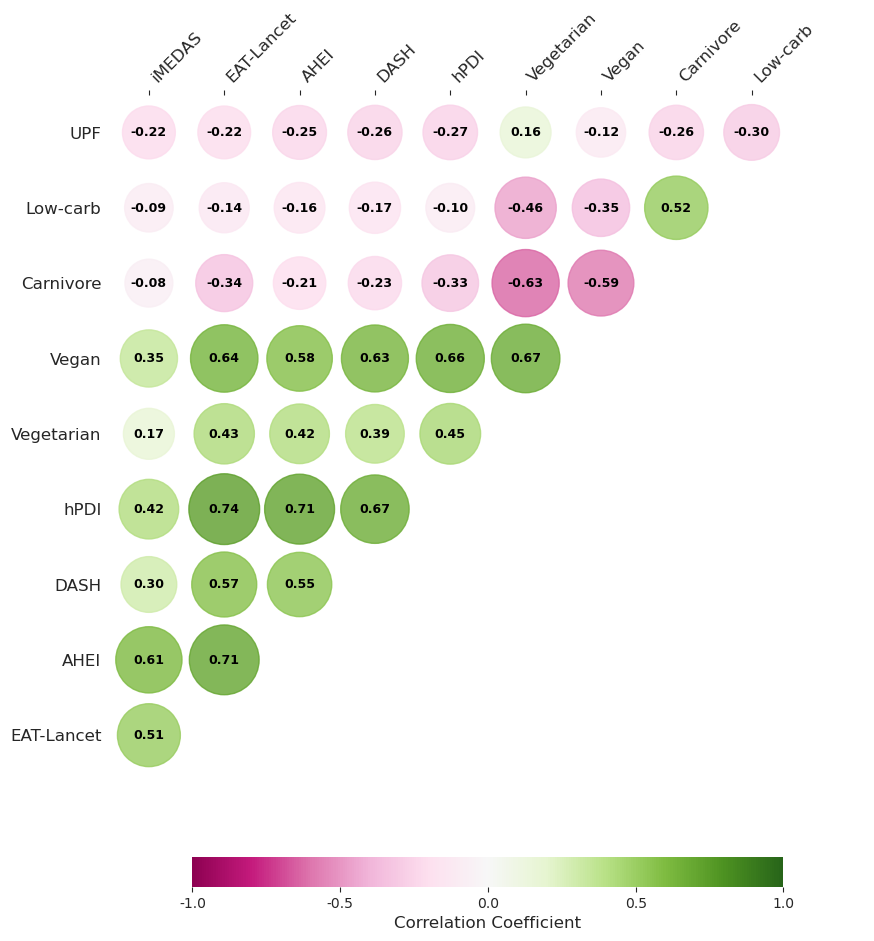

In [419]:
fig = plot_correlation_circles(diet_features, diet_scores, corr_method='pearson', figsize=(12, 10), cmap='PiYG')
fig.savefig(FIGS_DIR + '/diet_scores_correlation_heatmap_circles_final.pdf', dpi=600)

In [ ]:
plot_correlation_heatmap(joined_diet_mpa_serrf_nightinglae, nutrients, corr_method='pearson', color_palette='coolwarm', figsize=(12, 10), annot=False)
plt.savefig(FIGS_DIR + '/nutrients_correlation_heatmap.png', dpi=300)

In [ ]:
plot_correlation_heatmap(joined_diet_mpa_serrf_nightinglae, pct_macros, corr_method='pearson', color_palette='coolwarm', figsize=(12, 10), annot=True)
plt.savefig(FIGS_DIR + '/macros_correlation_heatmap.png', dpi=300)

In [72]:
never_eaters

['never_eat__Dairy products',
 'never_eat__Eggs or foods that contain eggs',
 'never_eat__I eat everything above',
 'never_eat__Sugar or foods / beverages that contain sugar',
 'never_eat__Wheat products']

## Genetics Analysis

In [509]:
from LabData.DataLoaders.PRSLoader import PRSLoader
prs_loader = PRSLoader()

In [510]:
prs_data = prs_loader.get_data().df
prs_metadata = prs_loader.get_data().df_metadata
prs_col_metadata = prs_loader.get_data().df_columns_metadata

In [511]:
prs_data.shape

(8958, 4587)

In [888]:
prs_col_metadata.to_csv(DIET_PAPER_DIR + '/prs_col_metadata.csv')

In [913]:
# Get the filtered column indices
filtered_cols = prs_col_metadata[prs_col_metadata['h2_h2_sig'].eq('z7')].index
filtered_cols_nominal = prs_col_metadata[prs_col_metadata['h2_h2_sig'].isin(['z7', 'z4', 'nominal'])].index
# Get only the columns that exist in prs_data
valid_cols = filtered_cols_nominal.intersection(prs_data.columns)
# Now use these columns to index prs_data
prs_data_sig = prs_data[valid_cols]

In [914]:
filtered_cols_nominal.shape

(1051,)

In [916]:
prs_data_sig_diet = prs_data_sig.join(diet_features, how='inner')
prs_data_sig_agb_height = prs_data_sig.join(agb_baseline, how='inner').join(height_baseline, how='inner')

In [917]:
prs_data_sig_diet_agb = prs_data_sig_diet.join(agb_baseline, how='inner')

In [918]:
prs_data_sig_diet_agb[list(prs_data_sig.columns) + ['age', 'gender', 'bmi']].to_csv(output_data_dir + '/Genetics/x_prs_data_sig_diet_nominal.csv')
prs_data_sig_agb_height[prs_data_sig.columns].to_csv(output_data_dir + '/Genetics/x_prs_data_sig_nominal.csv')

In [919]:
prs_data_sig_diet_agb[diet_scores].to_csv(output_data_dir + '/Genetics/y_prs_diet_scores.csv')
prs_data_sig_diet_agb[nutrients].to_csv(output_data_dir + '/Genetics/y_prs_nutrients.csv')
prs_data_sig_agb_height[['age', 'gender', 'bmi', 'height']].to_csv(output_data_dir + '/Genetics/y_prs_agb_height.csv')

In [774]:
prs_hr = prs_data_sig.join(hr_clean, how='inner')

In [775]:
prs_hr_clean_ranked = create_age_bin_ranks(prs_hr)

In [777]:
prs_hr_clean_ranked.columns

Index(['102_irnt', '1021', '1031', '1050', '1060', '1070', '1080', '1090',
       '1100', '110001',
       ...
       'sex', 'StudyTypeID', 'predicted', 'logprob', 'phenotypic_age',
       'active_features', 'age_bin', 'age_bin_label', 'pheno_age_rank',
       'pheno_age_rank_pct'],
      dtype='object', length=512)

In [780]:
cols_prs_age = list(prs_data_sig.columns) + ['age_bin']
prs_hr_clean_ranked[cols_prs_age].to_csv(output_data_dir + '/Genetics/x_prs_hr_ranked.csv')
prs_hr_clean_ranked[['pheno_age_rank', 'pheno_age_rank_pct','age', 'phenotypic_age']].to_csv(output_data_dir + '/Genetics/y_prs_hr_ranked.csv')

## Longitudinal Analysis

In [59]:
clusterd_09_v2 = clusterd_09[clusterd_09['research_stage'] == '02_00_visit'].copy()
clusterd_09_baseline = clusterd_09[clusterd_09['research_stage'] == 'baseline'].copy()
clusterd_09_v2.drop(columns=['research_stage'], inplace=True)
clusterd_09_baseline.drop(columns=['research_stage'], inplace=True)
# serf_full_visit2.set_index('RegistrationCode', inplace=True)

In [60]:
clusterd_09_v2_diet = clusterd_09_v2.merge(diet_features_v2, how='inner', left_on='RegistrationCode', right_index=True)
clusterd_09_base_diet = clusterd_09_baseline.merge(diet_features, how='inner', left_on='RegistrationCode', right_index=True)

In [61]:
ms_all_diet = pd.concat([clusterd_09_base_diet, clusterd_09_v2_diet], axis=0)

In [94]:
# Calculate differences between followup and baseline
metabolite_columns = clusterd_09_base_diet.drop(columns=['age', 'gender', 'bmi']).columns
diet_columns = diet_features.columns
ms_cols = clusterd_09_base.columns.to_list() + ['RegistrationCode']
# Calculate differences for metabolites

In [1198]:
#### save concatted table
# ms_all_diet[ms_cols].to_csv(output_data_dir + '/Longitudinal/x_ms_all_diet.csv')

In [1199]:
# ms_all_diet[diet_scores].to_csv(output_data_dir + '/Longitudinal/y_ms_all_diet_scores.csv')

In [88]:
# compute similarity 
diet_type = 'vegan_score_per_day'
predictions = pd.read_csv(DIET_PAPER_DIR + f'/Clustered_Reruns36/x_ms_all_diet/y_ms_all_diet_scores/results/{diet_type}/predictions_{diet_type}.csv', index_col=0)

In [89]:
predictions_baseline = predictions.join(clusterd_09_base_diet['RegistrationCode'], how='inner')
predictions_v2 = predictions.join(clusterd_09_v2_diet['RegistrationCode'], how='inner')

In [96]:
def create_true_sign_series(baseline_df, return_df):
    """
    Create a pandas Series of true sign changes with RegistrationCode as index.
    
    Parameters:
    baseline_df: DataFrame with columns ['RegistrationCode', 'true_values']
    return_df: DataFrame with columns ['RegistrationCode', 'true_values']
    
    Returns:
    pd.Series: Series with RegistrationCode as index and binary sign changes as values
               1 = positive change (improvement)
               0 = negative change (decline)
    """
    
    # Find common RegistrationCodes
    common_codes = set(baseline_df['RegistrationCode']) & set(return_df['RegistrationCode'])
    
    if len(common_codes) == 0:
        print("No common RegistrationCodes found!")
        return None
    
    # Filter to common codes and sort
    baseline_filtered = baseline_df[baseline_df['RegistrationCode'].isin(common_codes)].copy()
    return_filtered = return_df[return_df['RegistrationCode'].isin(common_codes)].copy()
    
    # Sort by RegistrationCode for proper alignment
    baseline_filtered = baseline_filtered.sort_values('RegistrationCode').reset_index(drop=True)
    return_filtered = return_filtered.sort_values('RegistrationCode').reset_index(drop=True)
    
    # Calculate true changes (return - baseline)
    delta_true = return_filtered['true_values'].values - baseline_filtered['true_values'].values
    
    # Convert to binary: 1 for positive change, 0 for negative change
    # Since you mentioned there are no zero changes, we don't need to handle them
    binary_signs = (delta_true > 0).astype(int)
    
    # Create Series with RegistrationCode as index
    sign_series = pd.Series(
        data=binary_signs,
        index=baseline_filtered['RegistrationCode'].values,
        name='true_sign_changes'
    )
    
    print(f"Created sign series for {len(sign_series)} patients")
    print(f"Positive changes (1): {np.sum(binary_signs)} ({np.mean(binary_signs)*100:.1f}%)")
    print(f"Negative changes (0): {len(binary_signs) - np.sum(binary_signs)} ({(1-np.mean(binary_signs))*100:.1f}%)")
    
    return sign_series

In [98]:
baseline_signs = create_true_sign_series(predictions_baseline, predictions_v2)

Created sign series for 2243 patients
Positive changes (1): 1002 (44.7%)
Negative changes (0): 1241 (55.3%)


In [100]:
ms_all_diet_signs = ms_all_diet.merge(baseline_signs, how='inner', left_on='RegistrationCode', right_index=True)

In [104]:
ms_all_diet_signs[ms_cols].to_csv(output_data_dir + '/Longitudinal/x_ms_all_diet_signs.csv')

In [105]:
ms_all_diet_signs['true_sign_changes'].to_csv(output_data_dir + '/Longitudinal/y_ms_all_diet_signs.csv')

In [90]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_diet_score_sign_similarity(baseline_df, return_df):
    """
    Calculate cosine similarity between signs of diet score changes.
    
    Parameters:
    baseline_df: DataFrame with columns ['index', 'true_values', 'predictions', 'RegistrationCode']
    return_df: DataFrame with columns ['index', 'true_values', 'predictions', 'RegistrationCode']
    
    Returns:
    float: Cosine similarity between sign vectors
    """
    
    # Find common RegistrationCodes between both tables
    common_codes = set(baseline_df['RegistrationCode']) & set(return_df['RegistrationCode'])
    print(f"Found {len(common_codes)} common RegistrationCodes")
    
    if len(common_codes) == 0:
        print("No common RegistrationCodes found!")
        return None
    
    # Filter both dataframes to only include common RegistrationCodes
    baseline_filtered = baseline_df[baseline_df['RegistrationCode'].isin(common_codes)].copy()
    return_filtered = return_df[return_df['RegistrationCode'].isin(common_codes)].copy()
    
    # Sort by RegistrationCode to ensure proper alignment
    baseline_filtered = baseline_filtered.sort_values('RegistrationCode').reset_index(drop=True)
    return_filtered = return_filtered.sort_values('RegistrationCode').reset_index(drop=True)
    
    # Calculate deltas (return - baseline) for both true values and predictions
    delta_true = return_filtered['true_values'].values - baseline_filtered['true_values'].values
    delta_predicted = return_filtered['predictions'].values - baseline_filtered['predictions'].values
    
    # Get signs of the deltas
    sign_delta_true = np.sign(delta_true)
    sign_delta_predicted = np.sign(delta_predicted)
    
    # Handle zero values (sign returns 0 for zero values)
    # You might want to exclude these or treat them differently
    print(f"Zero changes in true values: {np.sum(sign_delta_true == 0)}")
    print(f"Zero changes in predicted values: {np.sum(sign_delta_predicted == 0)}")
    
    # Calculate cosine similarity
    # Reshape to 2D arrays as required by sklearn
    sign_true_2d = sign_delta_true.reshape(1, -1)
    sign_pred_2d = sign_delta_predicted.reshape(1, -1)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(sign_true_2d, sign_pred_2d)[0, 0]
    
    # Alternative manual calculation for verification
    dot_product = np.dot(sign_delta_true, sign_delta_predicted)
    norm_true = np.linalg.norm(sign_delta_true)
    norm_pred = np.linalg.norm(sign_delta_predicted)
    
    if norm_true == 0 or norm_pred == 0:
        manual_similarity = 0
    else:
        manual_similarity = dot_product / (norm_true * norm_pred)
    
    print(f"Cosine similarity (sklearn): {similarity:.4f}")
    print(f"Cosine similarity (manual): {manual_similarity:.4f}")
    
    # Additional metrics for insight
    agreement = np.sum(sign_delta_true == sign_delta_predicted)
    total = len(sign_delta_true)
    agreement_rate = agreement / total
    
    print(f"Sign agreement rate: {agreement}/{total} = {agreement_rate:.4f}")
    
    return similarity, {
        'cosine_similarity': similarity,
        'sign_agreement_rate': agreement_rate,
        'total_pairs': total,
        'sign_agreements': agreement,
        'delta_true_signs': sign_delta_true,
        'delta_predicted_signs': sign_delta_predicted,
        'common_registration_codes': sorted(list(common_codes))
    }   

In [91]:
# UPDATED: Now includes comprehensive metrics
def comprehensive_sign_agreement_metrics(sign_true, sign_pred):
    """
    Calculate multiple metrics for sign agreement between two vectors.
    """
    from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
    from sklearn.metrics.pairwise import cosine_similarity
    
    results = {}
    
    # 1. Simple accuracy
    results['simple_accuracy'] = np.mean(sign_true == sign_pred)
    
    # 2. Cohen's Kappa (RECOMMENDED)
    results['cohens_kappa'] = cohen_kappa_score(sign_true, sign_pred)
    
    # 3. Matthews Correlation Coefficient
    results['matthews_corr'] = matthews_corrcoef(sign_true, sign_pred)
    
    # 4. Cosine similarity
    if np.linalg.norm(sign_true) > 0 and np.linalg.norm(sign_pred) > 0:
        results['cosine_similarity'] = cosine_similarity(
            sign_true.reshape(1, -1), sign_pred.reshape(1, -1))[0, 0]
    else:
        results['cosine_similarity'] = 0
    
    # 5. Directional agreement (ignoring zeros)
    non_zero_mask = (sign_true != 0) & (sign_pred != 0)
    if np.sum(non_zero_mask) > 0:
        results['directional_agreement'] = np.mean(sign_true[non_zero_mask] == sign_pred[non_zero_mask])
        results['non_zero_pairs'] = np.sum(non_zero_mask)
    else:
        results['directional_agreement'] = np.nan
        results['non_zero_pairs'] = 0
    
    # 6. Breakdown by categories
    results['breakdown'] = {
        'both_positive': np.sum((sign_true > 0) & (sign_pred > 0)),
        'both_negative': np.sum((sign_true < 0) & (sign_pred < 0)),
        'both_zero': np.sum((sign_true == 0) & (sign_pred == 0)),
        'opposite_signs': np.sum((sign_true * sign_pred) < 0),
        'mixed_with_zero': np.sum(((sign_true == 0) & (sign_pred != 0)) | 
                                 ((sign_true != 0) & (sign_pred == 0)))
    }
    
    return results

In [92]:
def analyze_diet_score_predictions(baseline_df, return_df, detailed_output=True):
    """
    Complete workflow for analyzing sign agreement between predicted and true diet score changes.
    
    Returns comprehensive metrics and detailed analysis.
    """
    
    print("?? DIET SCORE PREDICTION ANALYSIS")
    print("=" * 60)
    
    # Step 1: Get the basic similarity results
    print("Step 1: Calculating basic sign similarity...")
    similarity, details = calculate_diet_score_sign_similarity(baseline_df, return_df)
    
    if similarity is None:
        print("? No common registration codes found!")
        return None
    
    # Step 2: Extract sign vectors for comprehensive analysis
    print("Step 2: Running comprehensive sign agreement analysis...")
    sign_true = details['delta_true_signs']
    sign_pred = details['delta_predicted_signs']
    
    # Step 3: Get comprehensive metrics
    comprehensive_results = comprehensive_sign_agreement_metrics(sign_true, sign_pred)
    
    # Step 4: Print results
    print("\n?? COMPREHENSIVE RESULTS")
    print("=" * 60)
    
    print("?? RECOMMENDED METRICS:")
    print(f"   Cohen's Kappa: {comprehensive_results['cohens_kappa']:.4f}")
    print(f"   Matthews Correlation: {comprehensive_results['matthews_corr']:.4f}")
    
    print("\n?? OTHER METRICS:")
    print(f"   Simple Accuracy: {comprehensive_results['simple_accuracy']:.4f}")
    print(f"   Cosine Similarity: {comprehensive_results['cosine_similarity']:.4f}")
    if not np.isnan(comprehensive_results['directional_agreement']):
        print(f"   Directional Agreement: {comprehensive_results['directional_agreement']:.4f} "
              f"({comprehensive_results['non_zero_pairs']} non-zero pairs)")
    
    # Step 5: Detailed breakdown
    if detailed_output:
        print("\n?? DETAILED BREAKDOWN:")
        print("=" * 40)
        
        breakdown = comprehensive_results['breakdown']
        total = sum(breakdown.values())
        
        print(f"Total patient pairs analyzed: {total}")
        print(f"Common registration codes: {len(details['common_registration_codes'])}")
        
        print("\nSign Agreement Categories:")
        for category, count in breakdown.items():
            pct = (count/total)*100 if total > 0 else 0
            emoji = {"both_positive": "??", "both_negative": "??", "both_zero": "?", 
                    "opposite_signs": "??", "mixed_with_zero": "?"}.get(category, "")
            print(f"  {emoji} {category.replace('_', ' ').title()}: {count} ({pct:.1f}%)")
    
    # Step 6: Interpretation
    print("\n?? INTERPRETATION:")
    print("=" * 40)
    
    kappa = comprehensive_results['cohens_kappa']
    if kappa < 0:
        interpretation = "Worse than random (systematic disagreement)"
    elif kappa < 0.2:
        interpretation = "Slight agreement"
    elif kappa < 0.4:
        interpretation = "Fair agreement"
    elif kappa < 0.6:
        interpretation = "Moderate agreement"
    elif kappa < 0.8:
        interpretation = "Substantial agreement"
    else:
        interpretation = "Almost perfect agreement"
    
    print(f"Cohen's Kappa ({kappa:.4f}): {interpretation}")
    
    accuracy = comprehensive_results['simple_accuracy']
    print(f"Simple Accuracy ({accuracy:.4f}): {accuracy*100:.1f}% of predictions match true direction")
    
    # Return all results
    return {
        'basic_results': details,
        'comprehensive_metrics': comprehensive_results,
        'interpretation': interpretation,
        'summary': {
            'cohens_kappa': kappa,
            'simple_accuracy': accuracy,
            'total_pairs': total,
            'recommendation': 'cohens_kappa'  # Best metric to report
        }
    }

# QUICK USAGE FUNCTION
def quick_sign_agreement_analysis(baseline_df, return_df):
    """
    Quick function that returns just the key metrics
    """
    similarity, details = calculate_diet_score_sign_similarity(baseline_df, return_df)
    
    if similarity is None:
        return None
    
    comprehensive_results = comprehensive_sign_agreement_metrics(
        details['delta_true_signs'], 
        details['delta_predicted_signs']
    )
    
    return {
        'cohens_kappa': comprehensive_results['cohens_kappa'],
        'simple_accuracy': comprehensive_results['simple_accuracy'],
        'matthews_correlation': comprehensive_results['matthews_corr'],
        'total_pairs': len(details['delta_true_signs'])
    }


In [93]:
# Full analysis
results = analyze_diet_score_predictions(predictions_baseline, predictions_v2)
print(f"Best metric (Cohen's Kappa): {results['summary']['cohens_kappa']:.4f}")

?? DIET SCORE PREDICTION ANALYSIS
Step 1: Calculating basic sign similarity...
Found 2243 common RegistrationCodes
Zero changes in true values: 0
Zero changes in predicted values: 0
Cosine similarity (sklearn): 0.1939
Cosine similarity (manual): 0.1939
Sign agreement rate: 1339/2243 = 0.5970
Step 2: Running comprehensive sign agreement analysis...

?? COMPREHENSIVE RESULTS
?? RECOMMENDED METRICS:
   Cohen's Kappa: 0.1812
   Matthews Correlation: 0.1814

?? OTHER METRICS:
   Simple Accuracy: 0.5970
   Cosine Similarity: 0.1939
   Directional Agreement: 0.5970 (2243 non-zero pairs)

?? DETAILED BREAKDOWN:
Total patient pairs analyzed: 2243
Common registration codes: 2243

Sign Agreement Categories:
  ?? Both Positive: 528 (23.5%)
  ?? Both Negative: 811 (36.2%)
  ? Both Zero: 0 (0.0%)
  ?? Opposite Signs: 904 (40.3%)
  ? Mixed With Zero: 0 (0.0%)

?? INTERPRETATION:
Cohen's Kappa (0.1812): Slight agreement
Simple Accuracy (0.5970): 59.7% of predictions match true direction
Best metric (C

In [107]:
import pandas as pd
import numpy as np

def create_metabolite_diet_tables(baseline_metabolites, baseline_diet, followup_metabolites, followup_diet, diet_cols):
    """
    Create three tables linking metabolites and diet features:
    1. Baseline metabolites with diet feature changes
    2. Followup metabolites with diet feature changes
    3. Changes in metabolites with changes in diet features
    
    Parameters:
    -----------
    baseline_metabolites: pandas DataFrame
        DataFrame containing baseline metabolite measurements with registration code as index
    baseline_diet: pandas DataFrame
        DataFrame containing baseline diet features with registration code as index
    followup_metabolites: pandas DataFrame
        DataFrame containing followup metabolite measurements with registration code as index
    followup_diet: pandas DataFrame
        DataFrame containing followup diet features with registration code as index
    diet_cols: list
        List of diet column names to include
        
    Returns:
    --------
    tuple of three pandas DataFrames:
        (baseline_ms_diet, followup_ms_diet, diff_ms_diet)
    """
    # Create copies to avoid modifying original dataframes
    baseline_metabolites = baseline_metabolites.copy()
    baseline_diet = baseline_diet.copy()
    followup_metabolites = followup_metabolites.copy()
    followup_diet = followup_diet.copy()
    
    # drop age, gender, bmi columns from metabolites
    baseline_metabolites.drop(columns=['age', 'gender', 'bmi'], inplace=True)
    followup_metabolites.drop(columns=['age', 'gender', 'bmi'], inplace=True)
    
    # Find common subjects across all datasets
    common_subjects = list(set(baseline_metabolites.index) & 
                          set(baseline_diet.index) & 
                          set(followup_metabolites.index) & 
                          set(followup_diet.index))
    
    # Filter DataFrames to include only common subjects
    baseline_metabolites = baseline_metabolites.loc[common_subjects]
    baseline_diet = baseline_diet.loc[common_subjects]
    followup_metabolites = followup_metabolites.loc[common_subjects]
    followup_diet = followup_diet.loc[common_subjects]
    
    # Calculate differences for metabolites
    metabolite_columns = baseline_metabolites.columns
    diff_metabolites = followup_metabolites[metabolite_columns] - baseline_metabolites[metabolite_columns]
    
    # Calculate differences for diet features
    diff_diet = followup_diet[diet_cols] - baseline_diet[diet_cols]
    
    # Add prefix to distinguish baseline and followup metabolite columns
    baseline_metabolites_prefixed = baseline_metabolites.add_prefix('baseline_')
    followup_metabolites_prefixed = followup_metabolites.add_prefix('followup_')
    diff_metabolites_prefixed = diff_metabolites.add_prefix('diff_')
    
    # Create first table: both baseline and followup metabolites with diet differences
    combined_metabolites = pd.concat([baseline_metabolites_prefixed, followup_metabolites_prefixed], axis=1)
    combined_ms_diet = pd.concat([combined_metabolites, diff_diet], axis=1)
    combined_base_diff = pd.concat([baseline_metabolites_prefixed, diff_metabolites_prefixed, diff_diet], axis=1)
    
    combined_ms_diet_w_diff = pd.concat([combined_ms_diet, diff_metabolites_prefixed], axis=1)
    
    return combined_ms_diet,  combined_ms_diet_w_diff, combined_base_diff

In [108]:
combined_ms_diet, combined_ms_diet_w_diff, combined_base_diff = create_metabolite_diet_tables(
    clusterd_09_base,
    diet_features,
    clusterd_09_v2,
    diet_features_v2,
    diet_scores
)
#### TODO: NOVA food score in v2 in equivalent to baseline

In [110]:
combined_ms_diet_w_diff.shape

(0, 4704)

In [1120]:
# save all columns with baseline or followup prefix
metabo_cols = [col for col in combined_ms_diet.columns if 'baseline_' in col or 'followup_' in col]
combined_ms_diet[metabo_cols].to_csv(output_data_dir + '/Longitudinal/combined_ms_diet.csv')
metabo_cols_w_diff = [col for col in combined_ms_diet_w_diff.columns if 'baseline_' in col or 'followup_' in col or 'diff_' in col]
combined_ms_diet_w_diff[metabo_cols_w_diff].to_csv(output_data_dir + '/Longitudinal/combined_ms_diet_w_diff.csv')
metabo_cols_base_diff = [col for col in combined_base_diff.columns if 'baseline_' in col or 'diff_' in col]
combined_base_diff[metabo_cols_base_diff].to_csv(output_data_dir + '/Longitudinal/combined_base_diff.csv')
combined_ms_diet[diet_scores].to_csv(output_data_dir + '/Longitudinal/diff_diet_scores.csv')

OSError: Cannot save file into a non-existent directory: '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/no_cluster/Longitudinal'

In [1335]:
diff_ms_diet_diff[metabolite_columns].join(agb_baseline, how='inner').to_csv(output_data_dir + '/Longitudinal/diff_ms_diet_agb.csv')

In [1125]:
import lightgbm as lgb
def train_and_evaluate_model(baseline_df, visit2_df, feature_columns, target_columns, 
                           output_path, scale_features=True, run_suffix=''):
    """
    Train LightGBM models on baseline data and evaluate on visit 2 data.
    Also evaluates correlation between predicted dietary changes and actual target value changes.
    
    Parameters:
    -----------
    baseline_df : pandas DataFrame
        DataFrame containing baseline measurements
    visit2_df : pandas DataFrame
        DataFrame containing visit 2 measurements
    feature_columns : list
        List of column names to use as features
    target_columns : list
        List of column names to predict
    output_path : str
        Path where results will be saved
    scale_features : bool, default=True
        Whether to scale features using StandardScaler
    """
    results = {}
    
    # Verify all columns exist in both dataframes
    all_columns = feature_columns + target_columns
    if not all(col in baseline_df.columns for col in all_columns):
        raise ValueError("Not all specified columns found in baseline DataFrame")
    if not all(col in visit2_df.columns for col in all_columns):
        raise ValueError("Not all specified columns found in visit 2 DataFrame")
    
    # Create output directory if it doesn't exist
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    base_output_path = os.path.join(output_path, f'run_{timestamp}{run_suffix}')
    os.makedirs(base_output_path, exist_ok=True)
    
    # Prepare feature data
    X_train = baseline_df[feature_columns].copy()
    X_test = visit2_df[feature_columns].copy()
    
    if scale_features:
        scaler = StandardScaler()
        X_train = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=feature_columns,
            index=X_train.index
        )
        X_test = pd.DataFrame(
            scaler.transform(X_test),
            columns=feature_columns,
            index=X_test.index
        )
    
    # Model parameters
    params = {
        # 'objective': 'regression',
        'metric': 'r2',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'feature_fraction': 0.75,
        'n_estimators': 1000,
        'verbose': -1,
        'num_threads': 30
    }
    
    # # Save parameters
    # with open(os.path.join(base_output_path, 'model_params.json'), 'w') as f:
    #     json.dump(params, f, indent=4)
    
    # Initialize run metrics dictionary
    run_metrics = {
        'timestamp': timestamp,
        'n_features': len(feature_columns),
        'scaled_features': scale_features
    }
    
    # Create a DataFrame to store all difference R² scores
    diff_performance_df = pd.DataFrame(columns=['target', 'diff_r', 'diff_r2', 'diff_pvalue', 'test_r2', 'train_r2'])
    
    # Train a model for each target
    for target in tqdm(target_columns, desc="Training models"):
        target_dir = os.path.join(base_output_path, target)
        os.makedirs(target_dir, exist_ok=True)
        
        # Prepare target data
        y_train = baseline_df[target].values
        y_test = visit2_df[target].values
        
        # Create dataset
        train_data = lgb.Dataset(X_train, label=y_train)
        
        # Train model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=params['n_estimators']
        )
        
        # Make predictions for both training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate metrics for both sets
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_rmse = np.sqrt(train_mse)
        train_r2 = r2_score(y_train, y_train_pred)
        
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # SHAP Analysis and Plot
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        
        # Save SHAP plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, show=False)
        plt.title(f'SHAP Summary Plot for {target}')
        plt.tight_layout()
        plt.savefig(os.path.join(target_dir, 'shap_summary.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        # Calculate and evaluate dietary differences vs target differences
        # Get baseline and visit2 true values for targets (ensure they're matched by participant ID)
        common_indices = baseline_df.index.intersection(visit2_df.index)
        baseline_targets = baseline_df.loc[common_indices, target]
        visit2_targets = visit2_df.loc[common_indices, target]
        
        # Calculate actual target differences (visit2 - baseline)
        actual_diff = visit2_targets - baseline_targets
        
        # Use true baseline values and visit2 predictions for these participants
        visit2_pred = pd.Series(y_test_pred, index=X_test.index)
        visit2_pred_common = visit2_pred.loc[common_indices]
        
        # Calculate predicted differences (visit2_pred - baseline_true)
        # We're now using the true baseline values instead of predictions
        predicted_diff = visit2_pred_common - baseline_targets
        
        # Calculate correlation between actual and predicted differences
        diff_corr, diff_pvalue = pearsonr(actual_diff, predicted_diff)
        # Use r2_score from sklearn instead of calculating from Pearson's r
        diff_r2 = r2_score(actual_diff, predicted_diff)
        
        # Create and save the correlation plot
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_diff, predicted_diff, alpha=0.6)
        plt.xlabel('Actual Difference (Visit 2 - Baseline)')
        plt.ylabel('Predicted Difference (Visit 2 - Baseline)')
        plt.title(f'Correlation of Actual vs Predicted Differences for {target}\nR={diff_corr:.4f}, R²={diff_r2:.4f}, p={diff_pvalue:.4f}')
        
        # Add a best fit line
        m, b = np.polyfit(actual_diff, predicted_diff, 1)
        plt.plot(actual_diff, m*actual_diff + b, 'r-')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(target_dir, 'difference_correlation.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        # Save difference data
        difference_df = pd.DataFrame({
            'actual_diff': actual_diff,
            'predicted_diff': predicted_diff
        })
        difference_df.to_csv(os.path.join(target_dir, 'differences.csv'))
        
        # Store results
        results[target] = {
            'model': model,
            'train_rmse': train_rmse,
            'train_r2': train_r2,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'diff_r': diff_corr,
            'diff_r2': diff_r2,
            'diff_pvalue': diff_pvalue
        }
        
        # Update the difference performance DataFrame
        diff_performance_df = pd.concat([diff_performance_df, pd.DataFrame({
            'target': [target],
            'diff_r': [diff_corr],
            'diff_r2': [diff_r2],
            'diff_pvalue': [diff_pvalue],
            'test_r2': [test_r2],
            'train_r2': [train_r2]
        })], ignore_index=True)
        
        # Save individual target results
        # 1. Save model
        model.save_model(os.path.join(target_dir, 'model.txt'))
        
        # 2. Save predictions and true values
        train_results_df = pd.DataFrame({
            'true_values': y_train,
            'predictions': y_train_pred
        }, index=X_train.index)
        train_results_df.to_csv(os.path.join(target_dir, 'train_predictions.csv'))
        
        test_results_df = pd.DataFrame({
            'true_values': y_test,
            'predictions': y_test_pred
        }, index=X_test.index)
        test_results_df.to_csv(os.path.join(target_dir, 'test_predictions.csv'))
        
        # 3. Save metrics as text
        metrics = {
            'train_rmse': train_rmse,
            'train_r2': train_r2,
            'train_size': len(y_train),
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'test_size': len(y_test),
            'diff_correlation_r': diff_corr,
            'diff_correlation_r2': diff_r2,
            'diff_correlation_pvalue': diff_pvalue
        }
        metrics_text = format_metrics(metrics)
        with open(os.path.join(target_dir, 'metrics.txt'), 'w') as f:
            f.write(metrics_text)
        
        print(f"\nResults for {target}:")
        print(f"Training RMSE: {train_rmse:.4f}")
        print(f"Training R2 Score: {train_r2:.4f}")
        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test R2 Score: {test_r2:.4f}")
        print(f"Difference Correlation R: {diff_corr:.4f}")
        print(f"Difference Correlation R2: {diff_r2:.4f}")
        print(f"Difference Correlation p-value: {diff_pvalue:.4f}")
    
    # Update metrics files
    update_metrics_log(base_output_path, output_path, run_metrics)
    
    # Save the aggregated difference performance metrics
    diff_performance_df = diff_performance_df.sort_values(by='diff_r2', ascending=False)
    
    # Save to the run-specific directory
    diff_performance_path = os.path.join(base_output_path, 'difference_performance_summary.csv')
    diff_performance_df.to_csv(diff_performance_path, index=False)
    
    # Also save to the root output directory with timestamp included in filename
    root_diff_performance_path = os.path.join(output_path, f'difference_performance_summary_{timestamp}{run_suffix}.csv')
    diff_performance_df.to_csv(root_diff_performance_path, index=False)
    
    # Create a visualization of the difference R² scores
    plt.figure(figsize=(12, 8))
    bars = plt.barh(diff_performance_df['target'], diff_performance_df['diff_r2'], color='skyblue')
    plt.xlabel('Difference R² Score')
    plt.ylabel('Target')
    plt.title('R² Score of Predicted vs Actual Differences Across Targets')
    plt.grid(axis='x', alpha=0.3)
    plt.xlim(0, max(1.0, diff_performance_df['diff_r2'].max() * 1.1))
    
    # Add value labels to the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
                 va='center', fontsize=8)
    
    plt.tight_layout()
    
    # Save to run-specific directory
    plt.savefig(os.path.join(base_output_path, 'difference_performance_summary.png'), dpi=300, bbox_inches='tight')
    
    # Also save to root output directory
    plt.savefig(os.path.join(output_path, f'difference_performance_summary_{timestamp}{run_suffix}.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    return results

In [1130]:
metabolite_cols = list(serrf_full_base.columns)

# Train and evaluate models
results = train_and_evaluate_model(
    baseline_df=ms_joined_diet_features,
    visit2_df=serf_full_visit2_diet,
    feature_columns=metabolite_cols,
    target_columns=diet_scores,
    output_path=DIET_PAPER_DIR + '/Visit2_validation',
    scale_features=False,
    run_suffix="_1000trees_realr2_score_NEW"
)

Training models:   0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'lgb' is not defined

In [ ]:
# Train and evaluate models
results = train_and_evaluate_model(
    baseline_df=ms_joined_diet_features,
    visit2_df=serf_full_visit2_diet,
    feature_columns=metabolite_cols,
    target_columns=food_categories,
    output_path=DIET_PAPER_DIR + '/Visit2_validation',
    scale_features=False,
    run_suffix="_1000trees_realr2_score_food_categories"
)

In [1164]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

def create_diet_alluvial(baseline_df, followup_df, diet_score_col):
    """
    Create an alluvial plot showing transitions between diet adherence quartiles
    Only includes participants with both baseline and follow-up measurements
    
    Parameters:
    -----------
    baseline_df : pandas DataFrame
        DataFrame containing baseline diet scores
    followup_df : pandas DataFrame
        DataFrame containing follow-up diet scores
    diet_score_col : str
        Name of the column containing diet adherence scores
    """
    
    # Get common participants (those with both measurements)
    common_indices = baseline_df.index.intersection(followup_df.index)
    n_participants = len(common_indices)
    
    # Filter both dataframes to include only common participants
    baseline_df = baseline_df.loc[common_indices]
    followup_df = followup_df.loc[common_indices]
    
    # Print information about filtering
    print(f"Total participants at baseline: {len(baseline_df.index)}")
    print(f"Total participants at follow-up: {len(followup_df.index)}")
    print(f"Participants with both measurements: {len(common_indices)}")
    
    # Calculate quartiles for both timepoints
    baseline_quartiles = pd.qcut(baseline_df[diet_score_col], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    followup_quartiles = pd.qcut(followup_df[diet_score_col], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    # Create DataFrame with quartile assignments
    flow_df = pd.DataFrame({
        'Baseline': baseline_quartiles,
        'Follow-up': followup_quartiles
    })
    
    # Calculate stability metrics for each quartile
    quartile_metrics = {}
    for q in ['Q1', 'Q2', 'Q3', 'Q4']:
        # Get participants who started in this quartile
        q_participants = flow_df[flow_df['Baseline'] == q]
        total_in_q = len(q_participants)
        
        # Calculate how many stayed in same quartile
        stayed = len(q_participants[q_participants['Follow-up'] == q])
        stability_pct = round((stayed / total_in_q) * 100)
        
        # Calculate average quartile change
        q_num = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}
        quartile_changes = [q_num[end] - q_num[start] 
                          for start, end in zip(q_participants['Baseline'], 
                                              q_participants['Follow-up'])]
        avg_change = round(np.mean(quartile_changes), 1)
        
        quartile_metrics[q] = {
            'stability': stability_pct,
            'avg_change': avg_change
        }
    
    # Calculate flows between quartiles
    flows = flow_df.groupby(['Baseline', 'Follow-up']).size().reset_index(name='Count')
    
    # Create source-target pairs for Sankey diagram
    quartile_labels = ['Q1', 'Q2', 'Q3', 'Q4']
    label_to_id = {label: idx for idx, label in enumerate(quartile_labels)}
    
    # Create source, target, and value lists for the Sankey diagram
    source = []
    target = []
    value = []
    
    for _, row in flows.iterrows():
        source.append(label_to_id[row['Baseline']])
        target.append(label_to_id[row['Follow-up']] + 4)  # Offset for follow-up nodes
        value.append(row['Count'])
    
    # Create node labels with stability metrics
    node_labels = [
        f'Baseline Q{i+1}<br>{quartile_metrics[f"Q{i+1}"]["stability"]}% stable<br>Avg change: {quartile_metrics[f"Q{i+1}"]["avg_change"]} quartiles'
        for i in range(4)
    ] + [f'Follow-up Q{i+1}' for i in range(4)]
    
    # # Create more distinct warm colors
    # colors = [
    #     'rgba(255, 99, 71, 0.7)',    # Tomato red
    #     'rgba(255, 140, 0, 0.7)',    # Dark orange
    #     'rgba(218, 165, 32, 0.7)',   # Goldenrod
    #     'rgba(139, 69, 19, 0.7)',    # Saddle brown
    # ]
    
            # Create pastel colors for quartiles
    colors = [
        'rgba(255, 182, 193, 0.7)',  # Light pink
        'rgba(173, 216, 230, 0.7)',  # Light blue
        'rgba(144, 238, 144, 0.7)',  # Light green
        'rgba(221, 160, 221, 0.7)',  # Light purple
    ]
    
    # Assign colors to nodes (same color for matching quartiles)
    node_colors = colors + colors
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = node_labels,
            color = node_colors
        ),
        link = dict(
            source = source,
            target = target,
            value = value,
            color = [colors[s % 4] for s in source]  # Color flows based on source quartile
        )
    )])
    
    # Update layout with column name and sample size in title
    fig.update_layout(
        title_text=f"Diet Adherence Quartile Transitions for {diet_score_col}<br>N = {n_participants} participants",
        font_size=12,
        height=600,
        width=800
    )
    
    return fig

In [1174]:
# Example usage:
# Assuming your dataframes are named baseline_df and followup_df
# and they have columns 'diet_score' and 'participant_id'

# diet_type = 'med_score_per_day'
diet_type = '3.17_481.2085m/z'
fig = create_diet_alluvial(
    baseline_df=ms_joined_diet_features,
    followup_df=serf_full_visit2_diet,
    diet_score_col=diet_type,
)

# Show the plot
fig.show()

# Optional: save to HTML file
fig.write_html(FIGS_DIR + f"/diet_adherence_alluvial_topSHAP_MED.html")

Total participants at baseline: 2218
Total participants at follow-up: 2218
Participants with both measurements: 2218


/tmp/ipykernel_882/3933771303.py:67: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [1175]:
serf_full_visit2_diet['3.17_481.2085m/z'].to_csv(DIET_PAPER_DIR + '/visit2_3.17_481.2085mz.csv')

In [1172]:
ms_joined_diet_features.columns

Index(['3.99_357.1006m/z', '3.99_479.2644m/z', '3.99_491.2279m/z',
       '3.99_495.2595m/z', '3.99_391.2860m/z', '3.99_257.2506m/z',
       '3.99_505.3349m/z', '3.99_121.1022m/z', '3.99_165.0923m/z',
       '3.99_179.1804m/z',
       ...
       'Vegetables', 'bakedgoods', 'fruitjuicesandsoftdrinks',
       'milkcreamcheeseandyogurts', 'sweetmilkproducts', 'sweets', 'keto',
       'is_vegetarian', 'NOVA_food_score',
       'Energy Expenditure / Consumption Ratio'],
      dtype='object', length=2914)

In [1169]:
serf_full_visit2_diet[['age', 'gender', 'bmi']].to_csv(DIET_PAPER_DIR + '/visit2_agb.csv')

In [1339]:
phipseq_celiac = pd.read_csv('/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/QC/DYsp/For_tomer/phipseq_diet_metadata_merge.csv', index_col=0)

In [1340]:
phipseq_celiac.columns

Index(['agilent_129839', 'agilent_231419', 'agilent_5001', 'agilent_237411',
       'agilent_102872', 'agilent_1167', 'agilent_235512', 'agilent_179435',
       'agilent_6339', 'agilent_79560',
       ...
       'fruitjuicesandsoftdrinks', 'milkcreamcheeseandyogurts',
       'sweetmilkproducts', 'sweets', 'Energy Expenditure / Consumption Ratio',
       'gluten_free_score_foods', 'age', 'gender', 'bmi', 'Class'],
      dtype='object', length=2380)

In [1341]:
# take all columns containing agilent or twist
agilent_cols = [col for col in phipseq_celiac.columns if 'agilent' in col or 'twist' in col]

In [1346]:
phipseq_celiac['Class'] = phipseq_celiac['Class'].apply(lambda x: 1 if x == 'Celiac' else 0)

In [1375]:
phipseq_celiac_healthy_only = phipseq_celiac[phipseq_celiac['Class'] == 1].copy()

In [1380]:
par_corrs = calculate_partial_correlations(phipseq_celiac, agilent_cols, ['gluten_free_score_foods'], ['age', 'gender', 'bmi', 'Class'])

In [1385]:
par_corrs.to_csv('/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/QC/DYsp/celiac/par_corrs_agilent_twist.csv')

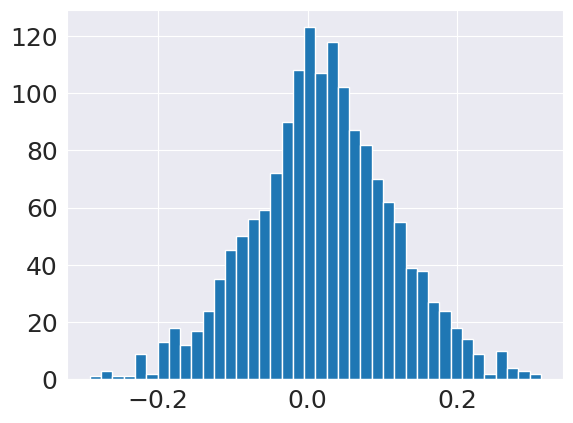

In [1386]:
fig = par_corrs['Partial_Correlation'].hist(bins=40)

In [1387]:
# save the fig 
fig.get_figure().savefig('/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/QC/DYsp/celiac/par_corrs_hist_agilent_twist.png', dpi=300)

In [1372]:
par_corrs['Class_correlation'].hist(bins=40)

KeyError: 'Class_correlation'

In [1744]:
diet_features_agb = diet_features.join(agb_baseline, how='inner')
diet_features_agb[diet_features.columns].drop(columns=['Energy / BMR', 'Energy']).to_csv(output_data_dir + '/Diet_Tests/diet_features_baseline.csv')
diet_features_agb[agb_baseline.columns].to_csv(output_data_dir + '/Diet_Tests/agb_baseline.csv')
diet_features_agb[diet_scores].to_csv(output_data_dir + '/Diet_Tests/diet_scores_baseline.csv')

### Indoleacrylic acid

In [1025]:
metabo = '1.80_186.0563m/z_143.14'

In [1028]:
# correlate indoleacrylic acid the rest of teh features
indoleacrylic_acid = serrf_full_base[metabo].values

In [1038]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def correlate_feature(df, target_feature, features_to_correlate=None, plot=True, 
                      sort=True, threshold=None, method='pearson'):
    """
    Correlate a target feature with other features in a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data
    target_feature : str
        The name of the feature to correlate with others
    features_to_correlate : list, optional
        List of feature names to correlate with the target feature.
        If None, correlates with all features except the target.
    plot : bool, default=True
        Whether to plot the correlation results
    sort : bool, default=True
        Whether to sort the correlations by absolute value
    threshold : float, optional
        If provided, only show correlations with absolute value above this threshold
    method : str, default='pearson'
        Correlation method to use ('pearson', 'spearman', or 'kendall')
        
    Returns:
    --------
    pandas.Series
        Series containing correlation values between target feature and others
    """
    # Validate target feature is in the DataFrame
    if target_feature not in df.columns:
        raise ValueError(f"Target feature '{target_feature}' not found in DataFrame")
    
    # Determine which features to correlate with
    if features_to_correlate is None:
        features_to_correlate = [col for col in df.columns if col != target_feature]
    else:
        # Validate all specified features exist in the DataFrame
        missing_features = [f for f in features_to_correlate if f not in df.columns]
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")
        
        # Remove target feature from features_to_correlate if it's there
        if target_feature in features_to_correlate:
            features_to_correlate.remove(target_feature)
    
    # Calculate correlations
    correlations = df[features_to_correlate].corrwith(df[target_feature], method=method)
    
    # Apply threshold if specified
    if threshold is not None:
        correlations = correlations[abs(correlations) >= threshold]
    
    # Sort by absolute correlation value if requested
    if sort:
        correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
    
    # Plot results if requested
    if plot and not correlations.empty:
        plt.figure(figsize=(10, len(correlations)/3 + 2))
        
        # Create bar plot
        ax = sns.barplot(x=correlations.values, y=correlations.index, orient='h')
        
        # Add vertical line at x=0
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add correlation values to the end of each bar
        for i, v in enumerate(correlations.values):
            ax.text(v + (0.01 if v >= 0 else -0.07), i, f'{v:.3f}', 
                    va='center', color='black')
        
        plt.title(f"Correlation with {target_feature} ({method})")
        plt.xlabel("Correlation coefficient")
        plt.tight_layout()
        plt.savefig(FIGS_DIR + f"/indoleacrylic_correlation.png", dpi=300)
        plt.show()
    
    return correlations


In [1044]:
mpa_cols

['s__Acidaminococcus_intestini',
 's__Adlercreutzia_equolifaciens',
 's__Agathobaculum_butyriciproducens',
 's__Akkermansia_muciniphila',
 's__Alistipes_communis',
 's__Alistipes_dispar',
 's__Alistipes_finegoldii',
 's__Alistipes_ihumii',
 's__Alistipes_indistinctus',
 's__Alistipes_onderdonkii',
 's__Alistipes_putredinis',
 's__Alistipes_senegalensis',
 's__Alistipes_shahii',
 's__Alistipes_sp_AF17_16',
 's__Alistipes_timonensis',
 's__Anaerobutyricum_hallii',
 's__Anaerobutyricum_soehngenii',
 's__Anaerostipes_hadrus',
 's__Anaerotignum_faecicola',
 's__Anaerotignum_sp_MSJ_24',
 's__Bacteroides_caccae',
 's__Bacteroides_cellulosilyticus',
 's__Bacteroides_clarus',
 's__Bacteroides_eggerthii',
 's__Bacteroides_faecis',
 's__Bacteroides_finegoldii',
 's__Bacteroides_fragilis',
 's__Bacteroides_intestinalis',
 's__Bacteroides_nordii',
 's__Bacteroides_ovatus',
 's__Bacteroides_salyersiae',
 's__Bacteroides_stercoris',
 's__Bacteroides_thetaiotaomicron',
 's__Bacteroides_uniformis',
 's

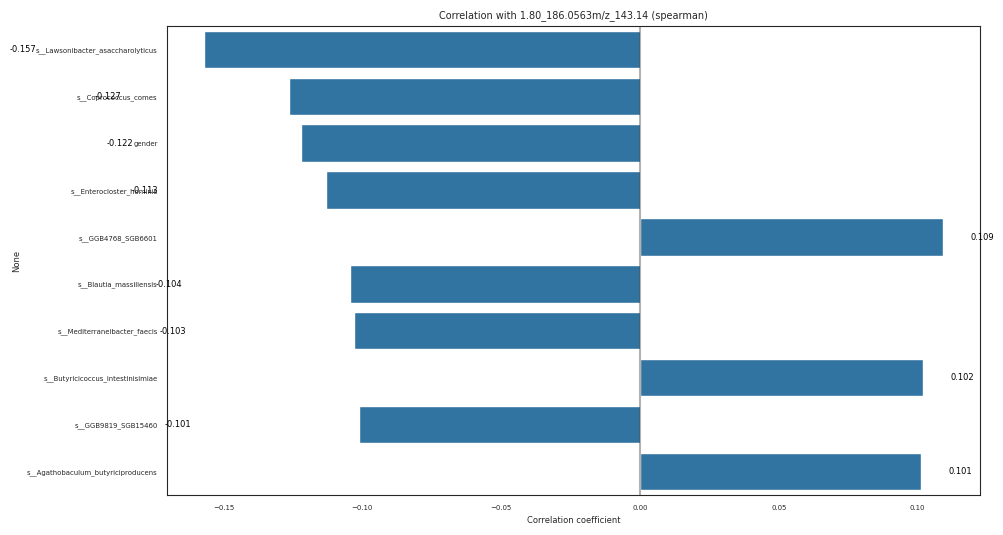

s__Lawsonibacter_asaccharolyticus    -0.156910
s__Coprococcus_comes                 -0.126593
gender                               -0.122078
s__Enterocloster_hominis             -0.113057
s__GGB4768_SGB6601                    0.109012
s__Blautia_massiliensis              -0.104357
s__Mediterraneibacter_faecis         -0.103107
s__Butyricicoccus_intestinisimiae     0.101878
s__GGB9819_SGB15460                  -0.101223
s__Agathobaculum_butyriciproducens    0.101176
dtype: float64

In [1047]:
# Correlate indoleacrylic acid with all other features
correlate_feature(ms_mpa_nmr_diet_oral_filtered, metabo, plot=True, sort=True, threshold=0.1, method='spearman', features_to_correlate=mpa_cols)

In [224]:
# save for genetics
diet_features[diet_scores].to_csv(output_data_dir + 'diet_scores_baseline_healthy.csv')

In [225]:
output_data_dir + 'diet_scores_baseline_healthy.csv'

'/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/diet_scores_baseline_healthy.csv'

In [217]:
diet_scores_updated = [
    'IMEDAS_score_per_day',
    'eatLANCET_score_per_day',
    'aHEI_score_per_day',
    'DASH_score',
    'hPDI_score_per_day',
    'vegetarian_score_per_day',
    'vegan_score_per_day',
    'carnivore_score_per_day',
    'low_carb_diet',
    'NOVA_pct',
]

In [216]:
diet_features_with_disease.columns.to_list()

['Acorn squash',
 'Alfalfa sprouts',
 'Almond Beverage',
 'Almond flour',
 'Almond spread',
 'Almonds',
 'Amba',
 'Apple',
 'Apple Cake',
 'Apple Vinegar',
 'Apple juice',
 'Apricot',
 'Apropo',
 'Artichoke',
 'Arugula',
 'Asparagus',
 'Avocado',
 'Avocado Sandwich',
 'Bagel',
 'Baguette',
 'Baked apple',
 'Baklava',
 'Balsamic vinegar',
 'Bamba',
 'Banana',
 'Banana Cake',
 'Barbecue sauce',
 'Barley soup',
 'Basil',
 'Bean Noodles',
 'Bean soup',
 'Beans',
 'Beans black-eyed peas',
 'Beef',
 'Beef Cholent',
 'Beef Lasagna',
 'Beef Shawarma',
 'Beer',
 'Beet',
 'Beet Salad',
 'Berries',
 'Biscuit',
 'Bissli',
 'Black beans',
 'Blintzes',
 'Blue Cheese',
 'Blueberries',
 'Boiled corn',
 'Bolognese',
 'Bounty',
 'Brazil nuts',
 'Bread',
 'Bread Crumbs',
 'Brioche',
 'Broccoli',
 'Broth',
 'Brown Rice',
 'Brown Sugar',
 'Brownies',
 'Buckwheat Bread',
 'Buckwheat crackers',
 'Bulgur',
 'Burekas',
 'Butter',
 'Butter Cookies',
 'Caesar Salad',
 'Cake',
 'Calamari',
 'Camembert or Brie',
 

In [221]:
diet_features_with_disease[diet_scores_updated].to_csv(output_data_dir + 'diet_scores_baseline_hc_disease.csv')

In [223]:
output_data_dir + 'diet_scores_baseline_hc_disease.csv'

'/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/diet_scores_baseline_hc_disease.csv'

In [230]:
diet_features_with_disease[['milkcreamcheeseandyogurts', 'AlcoholicDrinks', 'Bread_cat', 'MedOilandfats', 'Fishandseafood', 'Fruits', 'Vegetables']].to_csv(output_data_dir + 'food_categories_baseline_hc_disease.csv')

## RNA-Seq

In [235]:
rna_table  = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/10K_Trajectories/biological_age/nastu/rna.csv', index_col=0)

In [507]:
rna_table.shape

(7363, 15344)

In [508]:
prs_data.shape

NameError: name 'prs_data' is not defined

In [269]:
from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
bt_df = BloodTestsLoader().get_data().df
bt_df_meta = BloodTestsLoader().get_data().df_metadata
cbc_lab_ind = bt_df_meta[bt_df_meta['kupat_holim'] == 'tenk-cbc'].index
bt_df_cbc = bt_df.loc[cbc_lab_ind].dropna(how='all', axis=1)
bt_df_cbc_age = bt_df_meta.loc[cbc_lab_ind]['age'].reset_index().set_index("RegistrationCode")
bt_df_cbc = bt_df_cbc.reset_index().set_index("RegistrationCode")
bt_df_cbc = bt_df_cbc.loc[~bt_df_cbc.index.duplicated(keep="first"), :]

In [274]:
bt_df_cbc_diet = bt_df_cbc.join(diet_features_with_disease, how='inner')

In [275]:
columns_cbc_diet = bt_df_cbc_diet.columns.to_list() + diet_scores_updated

In [285]:
corr_cbc = bt_df_cbc_diet[columns_cbc_diet].drop(columns=['Date'], axis=1)

In [286]:
corr_cbc_corr = corr_cbc.corr()

In [294]:
corr_cbc_corr.loc[bt_df_cbc.drop(columns=['Date']).columns, diet_scores_updated]

,IMEDAS_score_per_day,IMEDAS_score_per_day,eatLANCET_score_per_day,eatLANCET_score_per_day,aHEI_score_per_day,aHEI_score_per_day,DASH_score,DASH_score,hPDI_score_per_day,hPDI_score_per_day,vegetarian_score_per_day,vegetarian_score_per_day,vegan_score_per_day,vegan_score_per_day,carnivore_score_per_day,carnivore_score_per_day,low_carb_diet,low_carb_diet,NOVA_pct,NOVA_pct
bt__platelets,-0.094401,-0.094401,-0.037725,-0.037725,-0.076183,-0.076183,-0.018168,-0.018168,-0.029511,-0.029511,0.041383,0.041383,-0.042457,-0.042457,-0.014048,-0.014048,-0.031815,-0.031815,0.065869,0.065869
bt__hct,0.062265,0.062265,-0.092947,-0.092947,-0.063668,-0.063668,-0.118927,-0.118927,-0.127295,-0.127295,-0.184722,-0.184722,-0.070277,-0.070277,0.056967,0.056967,0.029135,0.029135,-0.011034,-0.011034
bt__neutrophils_abs,-0.068720,-0.068720,-0.091664,-0.091664,-0.103885,-0.103885,-0.068847,-0.068847,-0.102049,-0.102049,-0.026704,-0.026704,-0.059679,-0.059679,0.004954,0.004954,-0.028632,-0.028632,0.077467,0.077467
bt__rdw,-0.038445,-0.038445,-0.031449,-0.031449,-0.021404,-0.021404,-0.046973,-0.046973,-0.029606,-0.029606,0.021115,0.021115,-0.041253,-0.041253,0.027863,0.027863,0.008920,0.008920,0.035643,0.035643
bt__eosinophils_%,-0.012380,-0.012380,-0.020786,-0.020786,-0.015217,-0.015217,-0.020885,-0.020885,-0.020900,-0.020900,-0.013083,-0.013083,-0.008581,-0.008581,-0.001273,-0.001273,-0.012388,-0.012388,0.007779,0.007779
bt__mchc,-0.002284,-0.002284,-0.003532,-0.003532,-0.017023,-0.017023,-0.020141,-0.020141,-0.024736,-0.024736,-0.046128,-0.046128,-0.029018,-0.029018,0.012369,0.012369,0.030912,0.030912,-0.004923,-0.004923
bt__lymphocytes_abs,-0.063714,-0.063714,-0.093476,-0.093476,-0.101835,-0.101835,-0.083700,-0.083700,-0.098066,-0.098066,-0.075816,-0.075816,-0.117426,-0.117426,0.071268,0.071268,0.021392,0.021392,0.027670,0.027670
bt__mean_platelet_volume,0.061278,0.061278,0.059924,0.059924,0.054368,0.054368,0.065028,0.065028,0.060302,0.060302,0.021116,0.021116,0.079346,0.079346,-0.042563,-0.042563,-0.028353,-0.028353,-0.024853,-0.024853
bt__eosinophils_abs,-0.032201,-0.032201,-0.061012,-0.061012,-0.060446,-0.060446,-0.059086,-0.059086,-0.062810,-0.062810,-0.042398,-0.042398,-0.043584,-0.043584,0.016160,0.016160,-0.010645,-0.010645,0.036022,0.036022
bt__hemoglobin,0.059263,0.059263,-0.093866,-0.093866,-0.068316,-0.068316,-0.122926,-0.122926,-0.132887,-0.132887,-0.194644,-0.194644,-0.077586,-0.077586,0.059217,0.059217,0.036487,0.036487,-0.011024,-0.011024


In [242]:
rna_table_diet = rna_table.join(diet_features_with_disease, how='inner')

In [241]:
rna_table.shape

(7363, 15344)

In [245]:
rna_table_diet = rna_table_diet.join(agb_baseline, how='inner')

In [295]:
rna_table_diet.to_csv(output_data_dir + 'Genetics/rna_baseline_diet.csv')

In [296]:
output_data_dir + 'Genetics/rna_baseline_diet.csv'

'/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/Genetics/rna_baseline_diet.csv'

In [297]:
diet_scores_updated

['IMEDAS_score_per_day',
 'eatLANCET_score_per_day',
 'aHEI_score_per_day',
 'DASH_score',
 'hPDI_score_per_day',
 'vegetarian_score_per_day',
 'vegan_score_per_day',
 'carnivore_score_per_day',
 'low_carb_diet',
 'NOVA_pct']

In [254]:
rna_table_diet[diet_scores_updated].to_csv(output_data_dir + 'Genetics/rna_diet_scores_baseline_hc_disease.csv')
rna_table_diet[food_categories].to_csv(output_data_dir + 'Genetics/rna_food_categories_baseline_hc_disease.csv')
valid_nutrients = [col for col in nutrients if col in rna_table_diet.columns]
rna_table_diet[valid_nutrients].to_csv(output_data_dir + 'Genetics/rna_nutrients_baseline_hc_disease.csv')

In [261]:
diet_features_with_disease[valid_nutrients].to_csv(output_data_dir + 'diet_nutrients_baseline_hc_disease.csv')

In [264]:
output_data_dir + 'diet_nutrients_baseline_hc_disease.csv'

'/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/diet_nutrients_baseline_hc_disease.csv'

In [255]:
rna_cols = rna_table.columns.to_list() + ['age', 'gender', 'bmi']

In [256]:
rna_table_diet[rna_cols].to_csv(output_data_dir + 'Genetics/rna_baseline.csv')

In [260]:
rna_table_diet[['age', 'gender', 'bmi']].to_csv(output_data_dir + 'Genetics/rna_agb_baseline.csv')

In [496]:
rna_table.columns

Index(['ZAP70', 'TEAD3', 'ELP2', 'PRKG1', 'DLEC1', 'PHF23', 'PROSER1', 'CSPG5',
       'HIVEP2', 'DCTN4',
       ...
       'SMIM33', 'FBXO48', 'TAS2R60', 'TENT5C', 'MIA-RAB4B', 'RPS4Y2', 'OR2B6',
       'RGPD4', 'PGAM2', 'AVP'],
      dtype='object', length=15344)

In [502]:
# add a small constant to avoid log(0) issues
def add_small_constant(df, columns, constant=1e-10):
    """
    Add a small constant to specified columns in a DataFrame to avoid log(0) issues.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame to modify
    columns : list
        List of column names to which the constant will be added
    constant : float, default 1e-10
        The small constant to add
    
    Returns:
    --------
    pandas DataFrame
        Modified DataFrame with the constant added to specified columns
    """
    df[columns] = df[columns] + constant
    return df
rna_table_diet = add_small_constant(rna_table_diet, rna_table.columns.to_list(), constant=1e-6)

In [504]:
rna_table_diet.min()

ZAP70           -9.585172
TEAD3           -0.297833
ELP2            -9.822242
PRKG1           -1.130578
DLEC1           -1.408252
                  ...    
sex              0.000000
Energy / BMR     0.339632
bmi             16.121168
age             21.000000
gender           0.000000
Length: 16046, dtype: float64

Diet Score Variance Explained Results:
Dataset: Unknown
Principal components 1-5 explain 0.0023 (R²) of variance in hPDI_score_per_day
Individual component contributions:
  PC1: R² = 0.0001 (0.01%)
  PC2: R² = 0.0000 (0.00%)
  PC3: R² = 0.0000 (0.00%)
  PC4: R² = 0.0001 (0.01%)
  PC5: R² = 0.0021 (0.21%)
---


/tmp/ipykernel_47486/2354921697.py:503: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


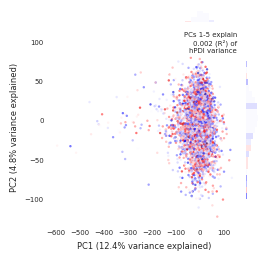

In [506]:
pca, X_pca, fig_pca, permanova_results, corr_results = perform_pca_visualization(
    df=rna_table_diet.dropna(how='any', axis=0),
    columns_for_pca=rna_table.columns,
    color_column=feature_to_color,
    log_transform=False,
    standardize=True,
    log_transform_color=False,
    color_scale='zscore',
    cmap='seismic',
    center_colors=True,
    # title=f"{config['title']} PCA\nColored by {feature_to_color}",
    title="",
    covariates=['age', 'gender', 'bmi'],
    run_permanova=False,
    use_quartiles=False,
    show_histograms=True,
    histogram_bins=30,
    remove_borders=True,
    figsize=(2.8, 2.8),
    fontsize=6,
    show_colorbar=False,
    show_grid=False,
    diet_variance_explained=True,
    n_components_for_variance=5,
    show_correlations=False,
    second_pc=2,
)

# Save figure
output_filename = f'pca_{feature_to_color}_RNA_r2_withVariance.pdf'
fig_pca.savefig(FIGS_DIR + '/' + output_filename, dpi=300)
# save as png
fig_pca.savefig(FIGS_DIR + '/' + output_filename.replace('.pdf', '.png'), dpi=300)

## Ackchol GWAS

In [320]:
snps_raw = pd.read_csv('/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/gwas/per_person_snps.raw', sep='\t', index_col=0)

In [322]:
snps_raw_diet = snps_raw.join(diet_features_with_disease, how='inner')

In [326]:
snps_raw_diet.columns

Index(['IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE', 'rs145452708_G',
       'rs138495951_G', 'rs141973904_C', 'Acorn squash', 'Alfalfa sprouts',
       ...
       'Soupsandsauces', 'Spicesandherbs', 'Vegetables', 'bakedgoods',
       'fruitjuicesandsoftdrinks', 'milkcreamcheeseandyogurts',
       'sweetmilkproducts', 'sweets', 'sex', 'Energy / BMR'],
      dtype='object', length=707)

In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from typing import Optional, Tuple, Dict, Any
from itertools import combinations

def boxplot_logscale_with_mannwhitney(
    df: pd.DataFrame,
    diet_feature: str,
    group_col: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 6),
    log_base: int = 10,
    annotate: bool = True,
    annotation_fontsize: int = 12,
    axis_fontsize: int = 14,
    title_fontsize: int = 16,
    tick_fontsize: int = 12,
    use_log_for_tests: bool = True,
    group_label_map: Optional[Dict[Any, str]] = None
) -> Tuple[Dict[Tuple[str, str], float], pd.DataFrame]:
    """
    Plot a log-scaled boxplot of a diet feature across user-defined groups
    and annotate pairwise Mann-Whitney U test p-values.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe containing the data
    diet_feature : str
        Column name of the diet feature to plot
    group_col : str, optional
        Column name for grouping. If None, creates a single boxplot
    figsize : Tuple[int, int], default (10, 6)
        Figure size as (width, height)
    log_base : int, default 10
        Base for logarithmic transformation
    annotate : bool, default True
        Whether to annotate p-values on the plot
    annotation_fontsize : int, default 12
        Font size for p-value annotations
    axis_fontsize : int, default 14
        Font size for axis labels
    title_fontsize : int, default 16
        Font size for plot title
    tick_fontsize : int, default 12
        Font size for tick labels
    use_log_for_tests : bool, default True
        Whether to perform statistical tests on log-transformed data
        
    Returns:
    --------
    Tuple[Dict[Tuple[str, str], float], pd.DataFrame]
        - Dictionary mapping group pairs to their Mann-Whitney U test p-values
        - DataFrame with log-transformed data used for analysis
    """
    
    # Create a copy to avoid modifying original data
    plot_df = df.copy()
    
    # Remove NaN values and zeros (which can't be log-transformed)
    plot_df = plot_df.dropna(subset=[diet_feature])
    
    # add the minimal non zero to the plot_df to avoid zeros
    min_non_zero = plot_df[diet_feature][plot_df[diet_feature] > 0].min()
    plot_df[diet_feature] = plot_df[diet_feature] + min_non_zero # Add a small value to all entries
    
    if len(plot_df) == 0:
        raise ValueError(f"No valid data remaining after removing NaN and non-positive values from {diet_feature}")
    
    # Apply log transformation
    log_feature = f'log{log_base}_{diet_feature}'
    plot_df[log_feature] = np.log(plot_df[diet_feature]) / np.log(log_base)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # make white background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    
    # Dictionary to store p-values
    pvalue_results = {}
    
    if group_col is None:
        # Single boxplot case
        diet_feature_label = 'Alcholic drinks' if diet_feature == 'AlcoholicDrinks' else diet_feature
        sns.boxplot(data=plot_df, y=log_feature, ax=ax)  # Use log-transformed data for plotting
        ax.set_ylabel(f'$\\log_{{10}}(\\text{{{diet_feature_label}}})$', fontsize=axis_fontsize)


        # ax.set_title(f'Distribution of {diet_feature} (Log Scale)', fontsize=title_fontsize)
        
    else:
        # Multiple groups case
        if group_col not in plot_df.columns:
            raise ValueError(f"Group column '{group_col}' not found in dataframe")
        
        # Remove rows with NaN in group column
        plot_df = plot_df.dropna(subset=[group_col])
        
        # Create boxplot using log-transformed data
        sns.boxplot(
            data=plot_df,
            x=group_col,
            y=log_feature,
            ax=ax,
            width=0.5,
            medianprops=dict(color='black', linewidth=2.5)
        )

        diet_feature_label = 'Alcholic drinks' if diet_feature == 'AlcoholicDrinks' else diet_feature
        ax.set_ylabel(f'$\\log_{{10}}(\\text{{{diet_feature_label}}})$', fontsize=axis_fontsize)

        ax.set_xlabel(group_col, fontsize=axis_fontsize)
        # ax.set_title(f'Distribution of {diet_feature} by {group_col} (Log Scale)', fontsize=title_fontsize)
        
        # Get unique groups
        groups = plot_df[group_col].unique()
        
        if len(groups) < 2:
            print(f"Warning: Only {len(groups)} group(s) found. Mann-Whitney U test requires at least 2 groups.")
            return pvalue_results
        
        # Calculate sample sizes for each group
        group_counts = plot_df[group_col].value_counts().to_dict()
        
        # Add sample size labels under each boxplot
        # Get the actual order of groups as they appear on the x-axis
        x_tick_labels = [label.get_text() for label in ax.get_xticklabels()]
        if group_label_map:
            new_labels = [group_label_map.get(float(lbl), lbl) for lbl in x_tick_labels]
            ax.set_xticklabels(new_labels, fontsize=tick_fontsize)

        
        for i, group_label in enumerate(x_tick_labels):
            # Find the corresponding group in our data (handle type conversion)
            group_key = None
            for group in groups:
                if str(group) == group_label:
                    group_key = group
                    break
            
            if group_key is not None and group_key in group_counts:
                n_count = group_counts[group_key]
                # Position the text below the x-axis using linear spacing on log-transformed scale
                y_min, y_max = ax.get_ylim()
                y_range = y_max - y_min
                ax.text(i, y_min - 0.08 * y_range, f'n={n_count}', 
                       ha='center', va='top', 
                       fontsize=tick_fontsize,
                       weight='bold')
        
        # Perform pairwise Mann-Whitney U tests
        group_data = {}
        for group in groups:
            if use_log_for_tests:
                # Use log-transformed data for statistical tests
                group_data[group] = plot_df[plot_df[group_col] == group][log_feature].values
            else:
                # Use original data for statistical tests
                group_data[group] = plot_df[plot_df[group_col] == group][diet_feature].values
        
        # Calculate p-values for all pairs
        for group1, group2 in combinations(groups, 2):
            try:
                statistic, p_value = mannwhitneyu(
                    group_data[group1], 
                    group_data[group2], 
                    alternative='two-sided'
                )
                pvalue_results[(group1, group2)] = p_value
            except ValueError as e:
                print(f"Warning: Could not perform Mann-Whitney U test between {group1} and {group2}: {e}")
                pvalue_results[(group1, group2)] = np.nan
        
        # Add p-value annotations if requested
        if annotate and len(groups) >= 2:
            # Calculate positions for annotations using linear spacing on log-transformed scale
            y_max = plot_df[log_feature].max()
            y_min = plot_df[log_feature].min()
            y_range = y_max - y_min
            
            # Position annotations above the plot
            annotation_height = y_max + 0.02 * y_range
            line_height = 0.05 * y_range
            
            # Get the actual order of groups as they appear on the x-axis
            # seaborn orders them, so we need to match that order
            x_tick_labels = [label.get_text() for label in ax.get_xticklabels()]
            
            # Create mapping handling potential type conversions
            group_positions = {}
            for i, label in enumerate(x_tick_labels):
                # Try to convert label back to original type if needed
                original_group = label
                # Check if any group matches when converted to string
                for group in groups:
                    if str(group) == label:
                        group_positions[group] = i
                        break
                else:
                    # If no exact match, try numeric conversion
                    try:
                        numeric_label = float(label)
                        if numeric_label in groups:
                            group_positions[numeric_label] = i
                        elif int(numeric_label) in groups:
                            group_positions[int(numeric_label)] = i
                    except (ValueError, TypeError):
                        # Fallback: use string version
                        group_positions[label] = i
            
            pair_idx = 0
            for (group1, group2), p_val in pvalue_results.items():
                if not np.isnan(p_val):
                    # Get x positions for the groups based on actual plot positions
                    try:
                        x1, x2 = group_positions[group1], group_positions[group2]
                    except KeyError as e:
                        print(f"Warning: Could not find position for group {e}. Available positions: {list(group_positions.keys())}")
                        print(f"Original groups: {list(groups)}")
                        print(f"X-tick labels: {x_tick_labels}")
                        continue
                    
                    # Ensure x1 < x2 for proper line drawing
                    if x1 > x2:
                        x1, x2 = x2, x1
                    
                    # Calculate y position using linear spacing on log scale
                    y_line = annotation_height + pair_idx * line_height * 1.5
                    
                    # Draw connecting line
                    ax.plot([x1, x2], [y_line, y_line], 'k-', linewidth=0.8)
                    ax.plot([x1, x1], [y_line - line_height * 0.1, y_line], 'k-', linewidth=0.8)
                    ax.plot([x2, x2], [y_line - line_height * 0.1, y_line], 'k-', linewidth=0.8)
                    
                    # Format p-value
                    if p_val < 0.001:
                        p_text = ""
                    elif p_val < 0.01:
                        p_text = f""
                    else:
                        p_text = f""
                    
                    # Add asterisks for significance levels
                    if p_val < 0.001:
                        p_text += " ***"
                    elif p_val < 0.01:
                        p_text += " **"
                    elif p_val < 0.05:
                        p_text += " *"
                    else:
                        p_text = "ns"
                        
                    # Add text annotation
                    ax.text((x1 + x2) / 2, y_line + line_height * 0.2, p_text, 
                           ha='center', va='bottom', fontsize=annotation_fontsize)
                    
                    pair_idx += 1
            
            # Extend y-axis to accommodate annotations
            if pair_idx > 0:
                ax.set_ylim(ax.get_ylim()[0], annotation_height + pair_idx * line_height * 2)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels if there are many groups
    if group_col is not None and len(groups) > 3:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_fontsize)
    
    # Adjust plot margins to ensure sample size labels are visible
    if group_col is not None:
        # Extend the bottom margin to accommodate n= labels
        current_ylim = ax.get_ylim()
        y_range = current_ylim[1] - current_ylim[0]
        ax.set_ylim(current_ylim[0] - 0.12 * y_range, current_ylim[1])
    
    plt.tight_layout()
    # save the figure
    plt.savefig(FIGS_DIR + f"/{diet_feature}_{group_col}_boxplot_logscale.png", dpi=600, bbox_inches='tight')
    # save as pdf
    plt.savefig(FIGS_DIR + f"/{diet_feature}_{group_col}_boxplot_logscale.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    return pvalue_results, plot_df

In [488]:
# Example usage and helper function
def print_mannwhitney_results(results: Dict[Tuple[str, str], float]):
    """
    Print Mann-Whitney U test results in a formatted way.
    
    Parameters:
    -----------
    results : Dict[Tuple[str, str], float]
        Dictionary of p-values from boxplot_logscale_with_mannwhitney
    """
    if not results:
        print("No statistical tests were performed.")
        return
    
    print("Mann-Whitney U Test Results:")
    print("=" * 40)
    
    for (group1, group2), p_val in results.items():
        if np.isnan(p_val):
            print(f"{group1} vs {group2}: Test failed")
        else:
            significance = ""
            if p_val < 0.001:
                significance = " (***)"
            elif p_val < 0.01:
                significance = " (**)"
            elif p_val < 0.05:
                significance = " (*)"
            
            print(f"{group1} vs {group2}: p = {p_val:.6f}{significance}")

In [489]:
snps_raw.columns

Index(['IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE', 'rs145452708_G',
       'rs138495951_G', 'rs141973904_C'],
      dtype='object')

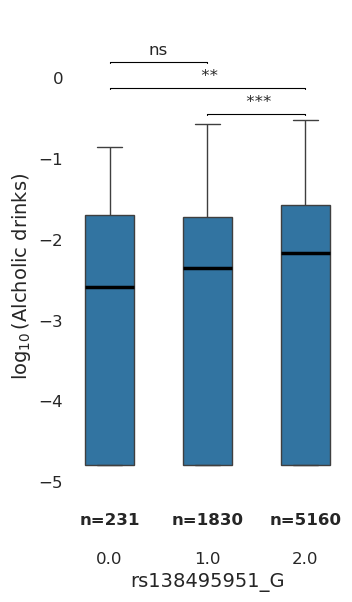

({(2.0, 1.0): 1.5883780933912023e-09,
  (2.0, 0.0): 0.002431429175440327,
  (1.0, 0.0): 0.5599812166603118},
                            IID  PAT  MAT  SEX  PHENOTYPE  rs145452708_G  \
 10K_1000942861  10K_1000942861    0    0    0         -9            2.0   
 10K_1001201093  10K_1001201093    0    0    0         -9            2.0   
 10K_1003113258  10K_1003113258    0    0    0         -9            2.0   
 10K_1007330152  10K_1007330152    0    0    0         -9            2.0   
 10K_1007400622  10K_1007400622    0    0    0         -9            2.0   
 ...                        ...  ...  ...  ...        ...            ...   
 10K_9995623290  10K_9995623290    0    0    0         -9            2.0   
 10K_9995746691  10K_9995746691    0    0    0         -9            2.0   
 10K_9995823183  10K_9995823183    0    0    0         -9            1.0   
 10K_9999226141  10K_9999226141    0    0    0         -9            1.0   
 10K_9999409119  10K_9999409119    0    0    0         

In [493]:
group_label_map = {
    0.0: 'A\\A',
    1.0: 'A\\G',
    2.0: 'G\\G'
}
boxplot_logscale_with_mannwhitney(snps_raw_diet, 'AlcoholicDrinks', 'rs138495951_G', figsize=(3.5,6),
                                  )  # Replace 'rs123456' with an actual SNP column name

In [415]:
snps_raw

,IID,PAT,MAT,SEX,PHENOTYPE,rs145452708_G,rs138495951_G,rs141973904_C
FID,,,,,,,,
10K_1000942861,10K_1000942861,0,0,0,-9,2.0,2.0,2.0
10K_1001201093,10K_1001201093,0,0,0,-9,2.0,2.0,2.0
10K_1002033709,10K_1002033709,0,0,0,-9,2.0,2.0,2.0
10K_1002087123,10K_1002087123,0,0,0,-9,2.0,2.0,2.0
10K_1003113258,10K_1003113258,0,0,0,-9,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...
10K_9995623290,10K_9995623290,0,0,0,-9,2.0,2.0,2.0
10K_9995746691,10K_9995746691,0,0,0,-9,2.0,2.0,2.0
10K_9995823183,10K_9995823183,0,0,0,-9,1.0,1.0,1.0


In [361]:
print_mannwhitney_results(res)

Mann-Whitney U Test Results:
2.0 vs 0.0: p = 0.012885 (*)
2.0 vs 1.0: p = 0.000001 (***)
0.0 vs 1.0: p = 0.589355
